In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random
from scipy.interpolate import splrep, BSpline
# set plot resolution
dpi = 500

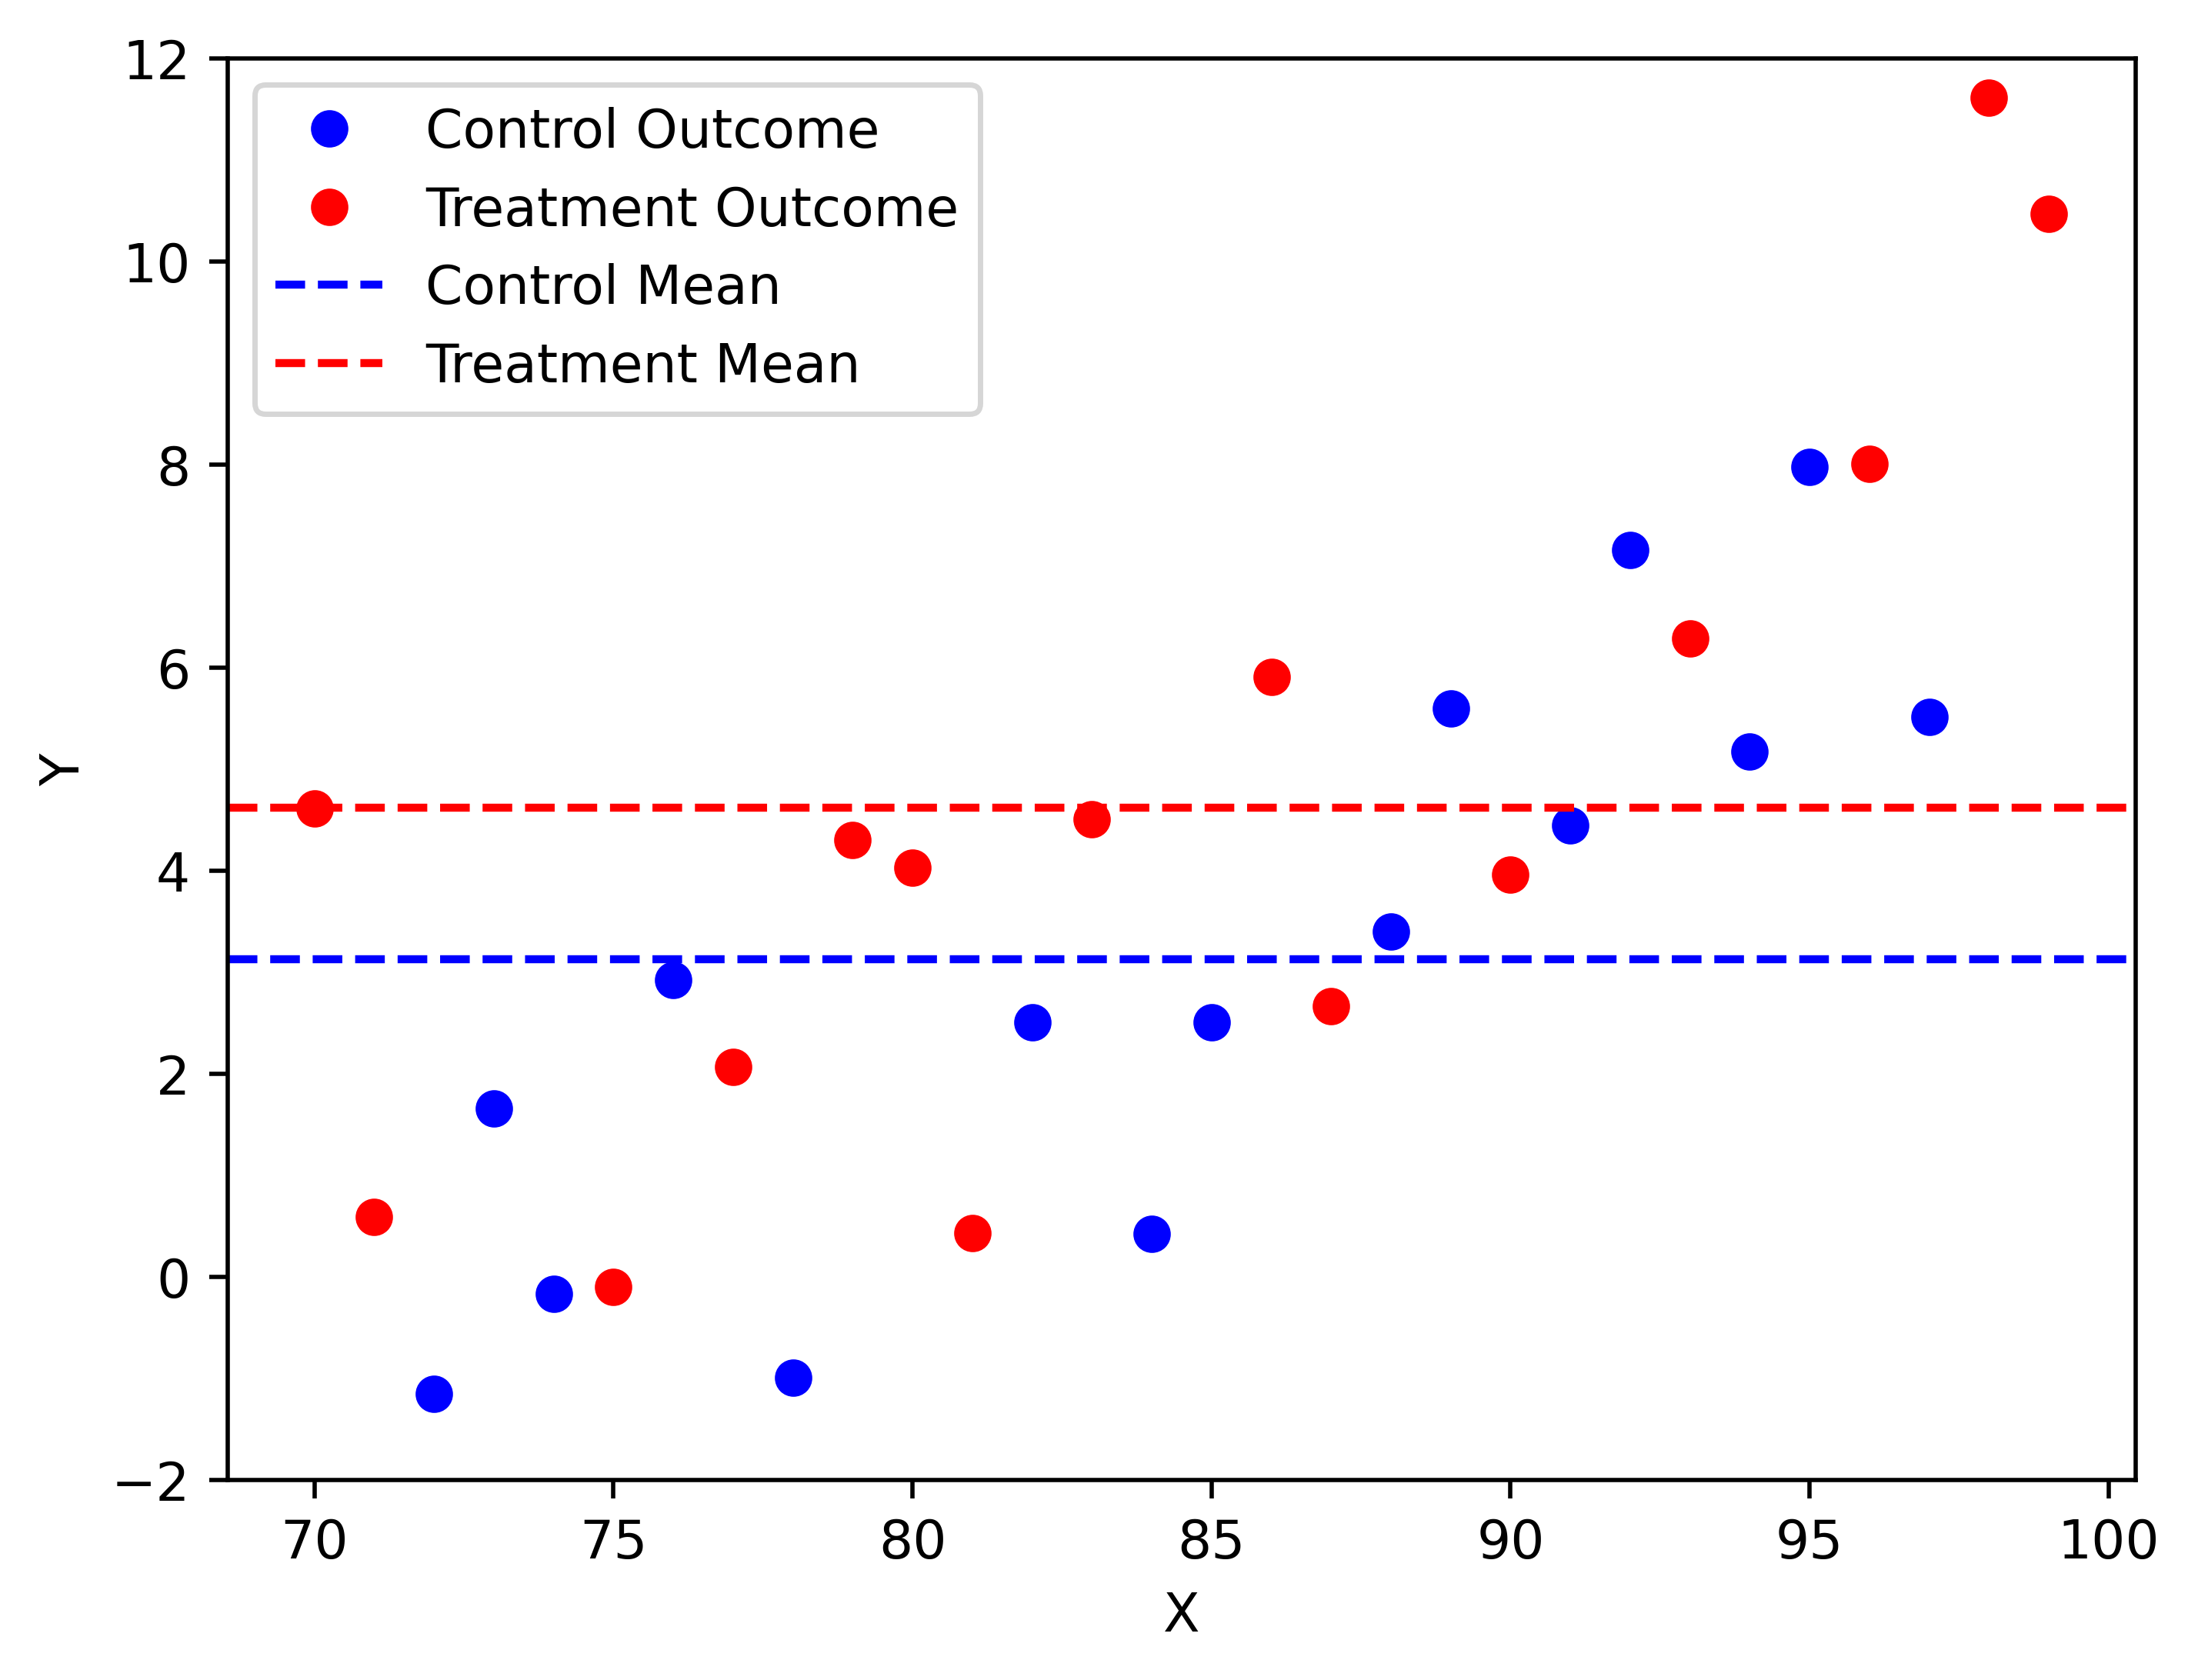

1.4921529374378886 1.1160301206556251


In [2]:
# Experimental plot
plt.figure(dpi=dpi)
np.random.seed(1)
random.seed(1)
x = np.arange(70,100,1)
n = len(x)
error = np.random.normal(0,1,n)
def exp_data(x):
    return 2*np.sin(x*2) + 0.01*((x - 70)**2) + 0.4*error
y = exp_data(x)
te = 2
control_idx = random.sample(range(n),n//2)
treat_idx = list(set(range(n)).difference(control_idx))
control_idx.sort()
treat_idx.sort()
control_x = x[control_idx]
treat_x = x[treat_idx]
control_y = y[control_idx]
treat_y = y[treat_idx] + te
plt.plot(control_x, control_y, 'o', color = 'blue', label='Control Outcome')
plt.plot(treat_x, treat_y, 'o', color = 'red', label = 'Treatment Outcome')
#plt.plot(x_f, y_f, color = 'black')
#plt.plot(x_f, y_f+te, color = 'grey')
plt.axhline(np.mean(control_y), linestyle='--', color='blue', label ='Control Mean')
plt.axhline(np.mean(treat_y), linestyle='--', color='red', label ='Treatment Mean')
plt.ylim([-2,12])
plt.ylabel("Y")
plt.xlabel("X")
plt.legend()
plt.savefig("plots/Simulated_y_base.png")
plt.show()
# covariate accounted for here
ATE = np.mean(treat_y) - np.mean(control_y)
SE = (np.var(treat_y)/len(treat_y) + np.var(control_y)/len(control_y))**0.5
print(ATE,SE)

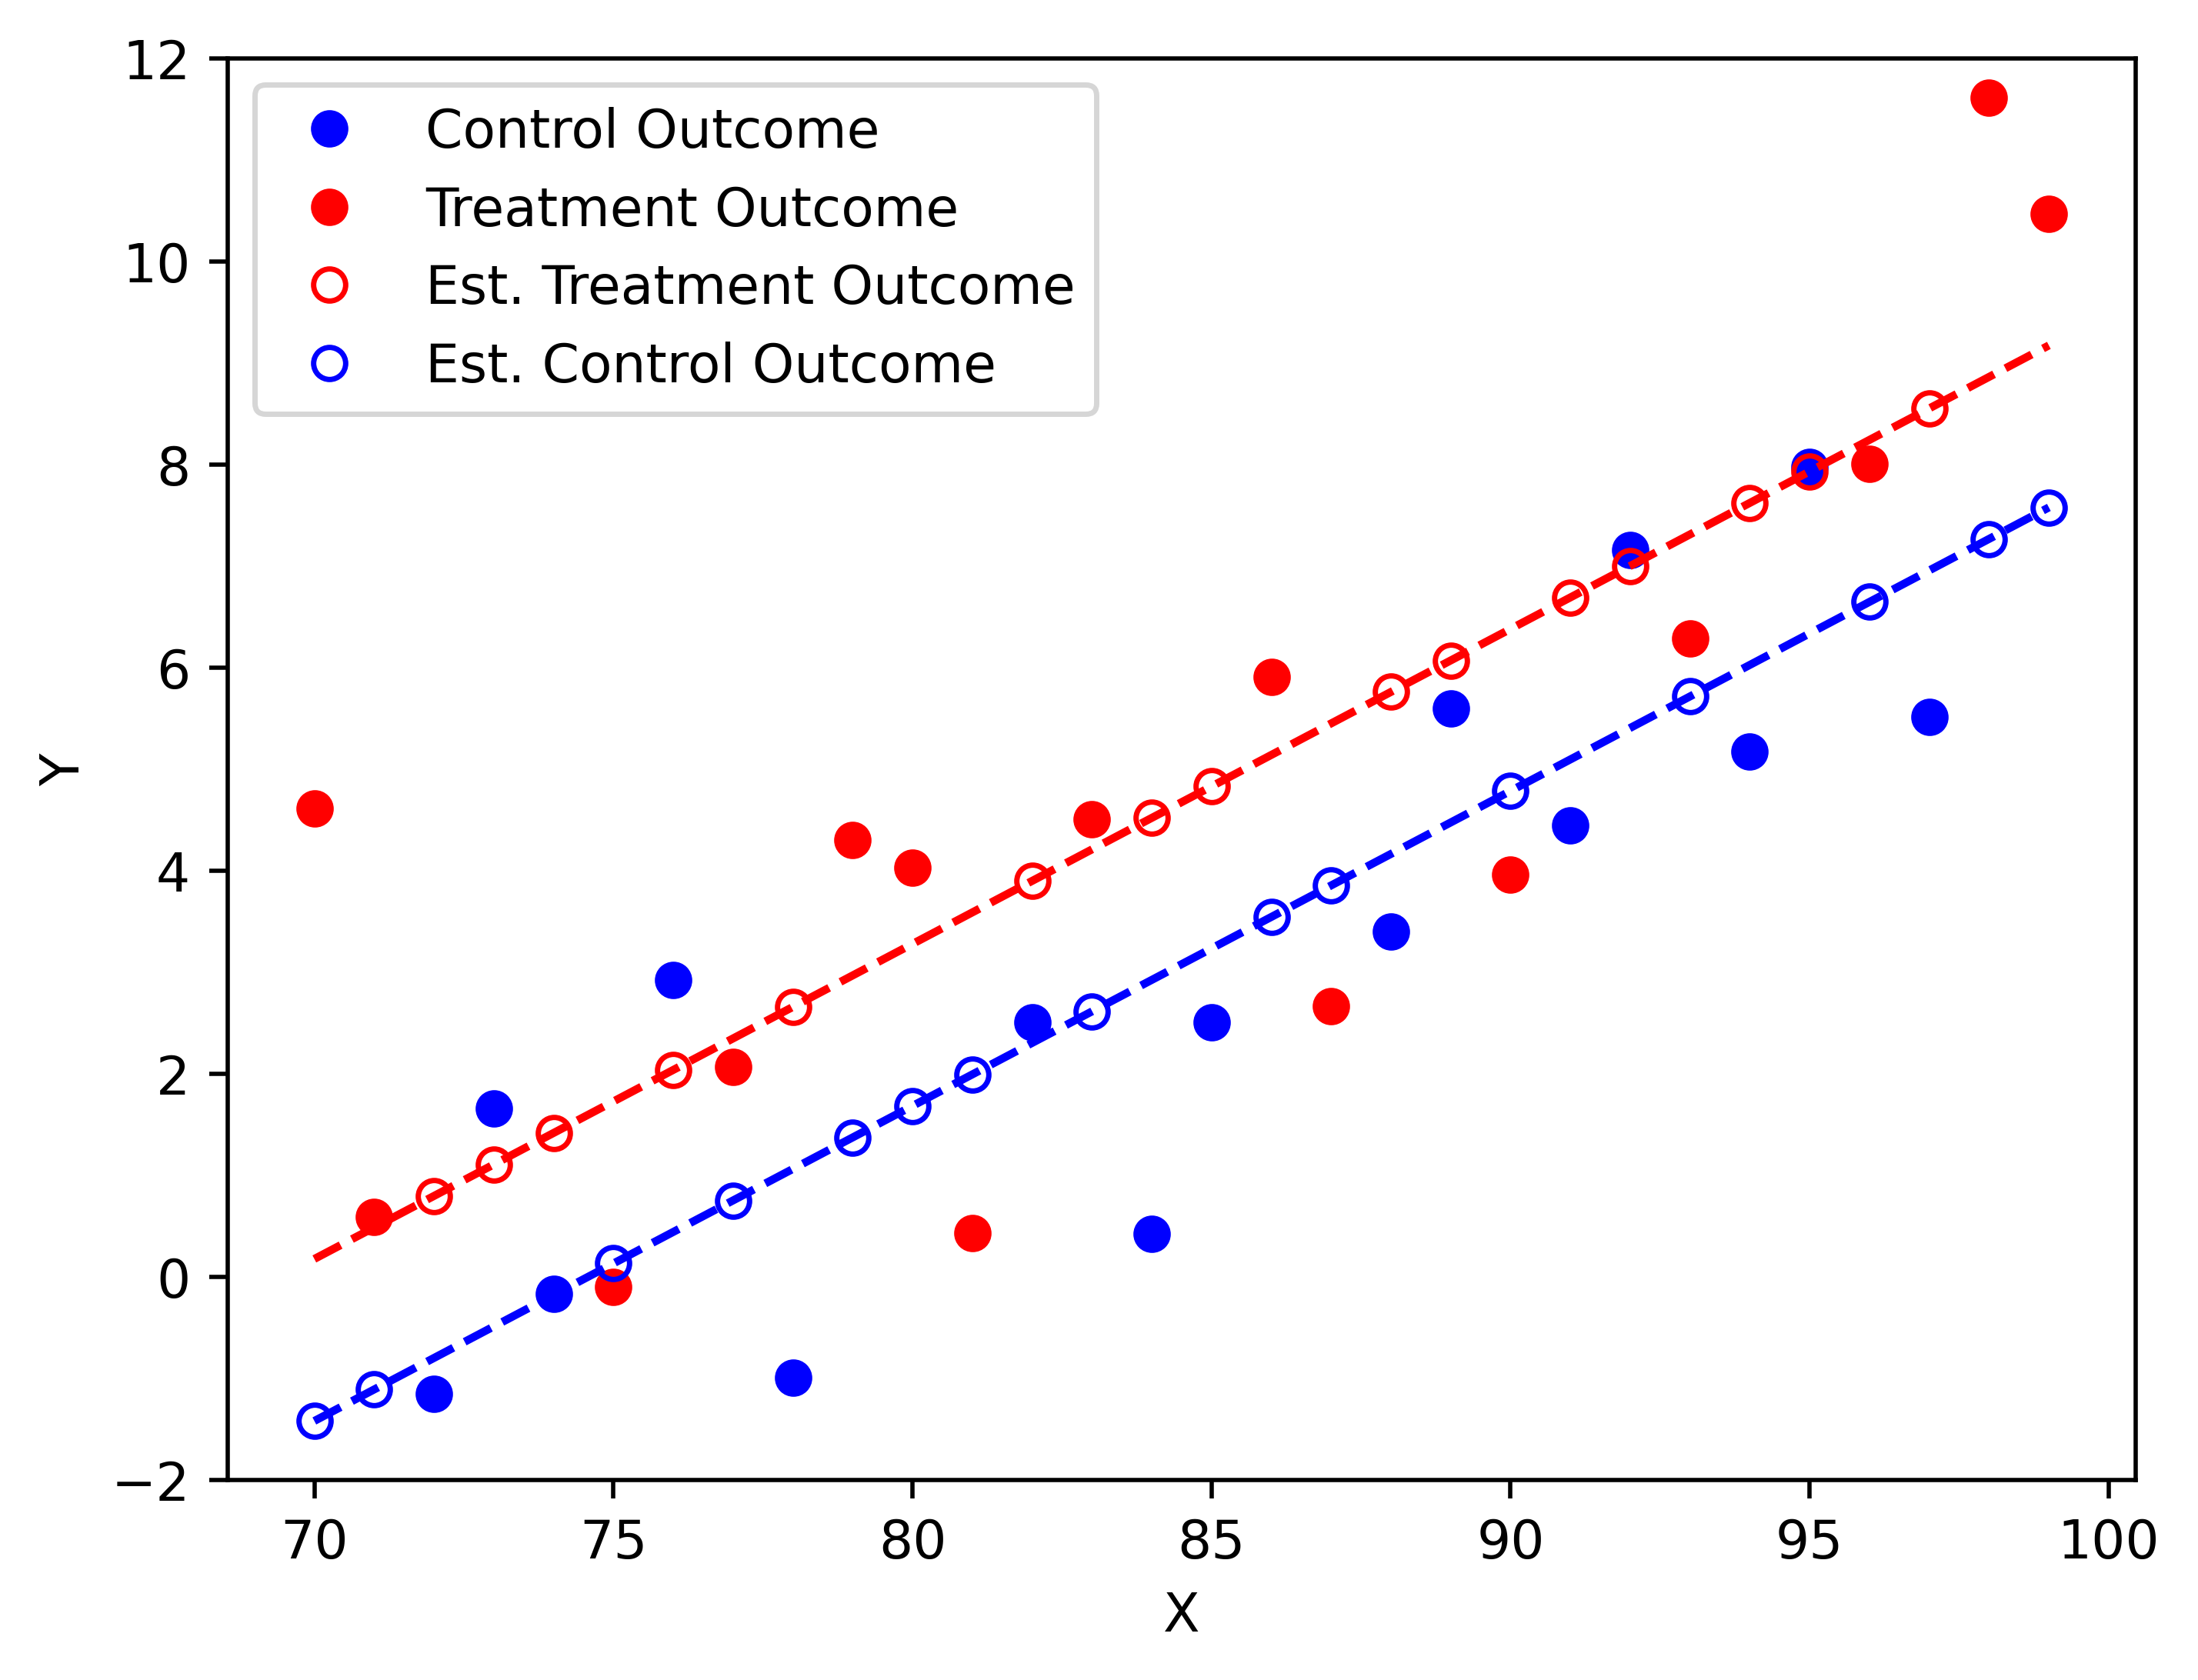

ATE:  1.5955669263162022 SE:  0.642333007257939


In [3]:
# calculate optimal beta
plt.figure(dpi=dpi)
treatxvar = np.var(treat_x)
controlxvar = np.var(control_x)
treatxcov = np.cov(treat_x, treat_y)[0,1]
controlxcov = np.cov(control_x, control_y)[0,1]
beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
alpha1 = np.mean(treat_y) - np.mean(treat_x)*beta
alpha0 = np.mean(control_y) - np.mean(control_x)*beta
treatline = alpha1 + x * beta
controlline = alpha0 + x * beta
plt.plot(control_x, control_y, 'o', color = 'blue', label='Control Outcome')
plt.plot(treat_x, treat_y, 'o', color = 'red', label = 'Treatment Outcome')
#plt.plot(x_f, y_f, color = 'black')
#plt.plot(x_f, y_f+te, color = 'grey')
plt.plot(x, controlline, linestyle='--', color='blue')
plt.plot(x, treatline, linestyle='--', color='red')
plt.plot(control_x, alpha1 + control_x * beta, 'o',fillstyle='none',color = 'red',label='Est. Treatment Outcome')
plt.plot(treat_x, alpha0 + treat_x * beta, 'o',fillstyle='none',color='blue',label='Est. Control Outcome')
plt.ylim([-2,12])
plt.ylabel("Y")
plt.xlabel("X")
plt.legend()
plt.savefig("plots/Simulated_y_regression.png")
plt.show()
ATE = alpha1 - alpha0
SE = (np.var(treat_y - treat_x * beta)/len(treat_y) + np.var(control_y - control_x * beta)/len(control_y))**0.5
print("ATE: ", ATE, "SE: ", SE)

In [4]:
np.random.seed(1)
random.seed(1)
sim_num = 1000
sample_sizes = {1: 10, 2: 40, 3:80}
res = {}
for key in sample_sizes:
    temp = []
    n0 = sample_sizes[key]
    n1 = sample_sizes[key]
    for i in range(sim_num):
        #control_idx = random.sample(range(n),n//2)
        #treat_idx = list(set(range(n)).difference(control_idx))
        # or if with replacement
        control_idx = random.choices(range(n), k=n0)
        treat_idx = random.choices(range(n), k=n1)
        control_idx.sort()
        treat_idx.sort()
        control_x = x[control_idx]
        treat_x = x[treat_idx]
        control_y = y[control_idx]
        treat_y = y[treat_idx] + te

        # perform difference in means
        two_est = np.mean(treat_y) - np.mean(control_y)
        two_se = (np.var(treat_y,ddof=1)/n1 + np.var(control_y,ddof=1)/n0)**0.5

        # perform counterfactual estimator with regression
        treatxvar = np.var(treat_x)
        controlxvar = np.var(control_x)
        treatxcov = np.cov(treat_x, treat_y)[0,1]
        controlxcov = np.cov(control_x, control_y)[0,1]
        beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
        alpha1 = np.mean(treat_y) - np.mean(treat_x)*beta
        alpha0 = np.mean(control_y) - np.mean(control_x)*beta
        reg_est = alpha1 - alpha0
        reg_se = (np.var(treat_y - treat_x * beta,ddof=1)/len(treat_y) + np.var(control_y - control_x * beta,ddof=1)/len(control_y))**0.5

        temp.append([two_est, two_se, reg_est, reg_se])

    res[key] = pd.DataFrame(temp, columns = ['two_est','two_se','reg_est','reg_se'])

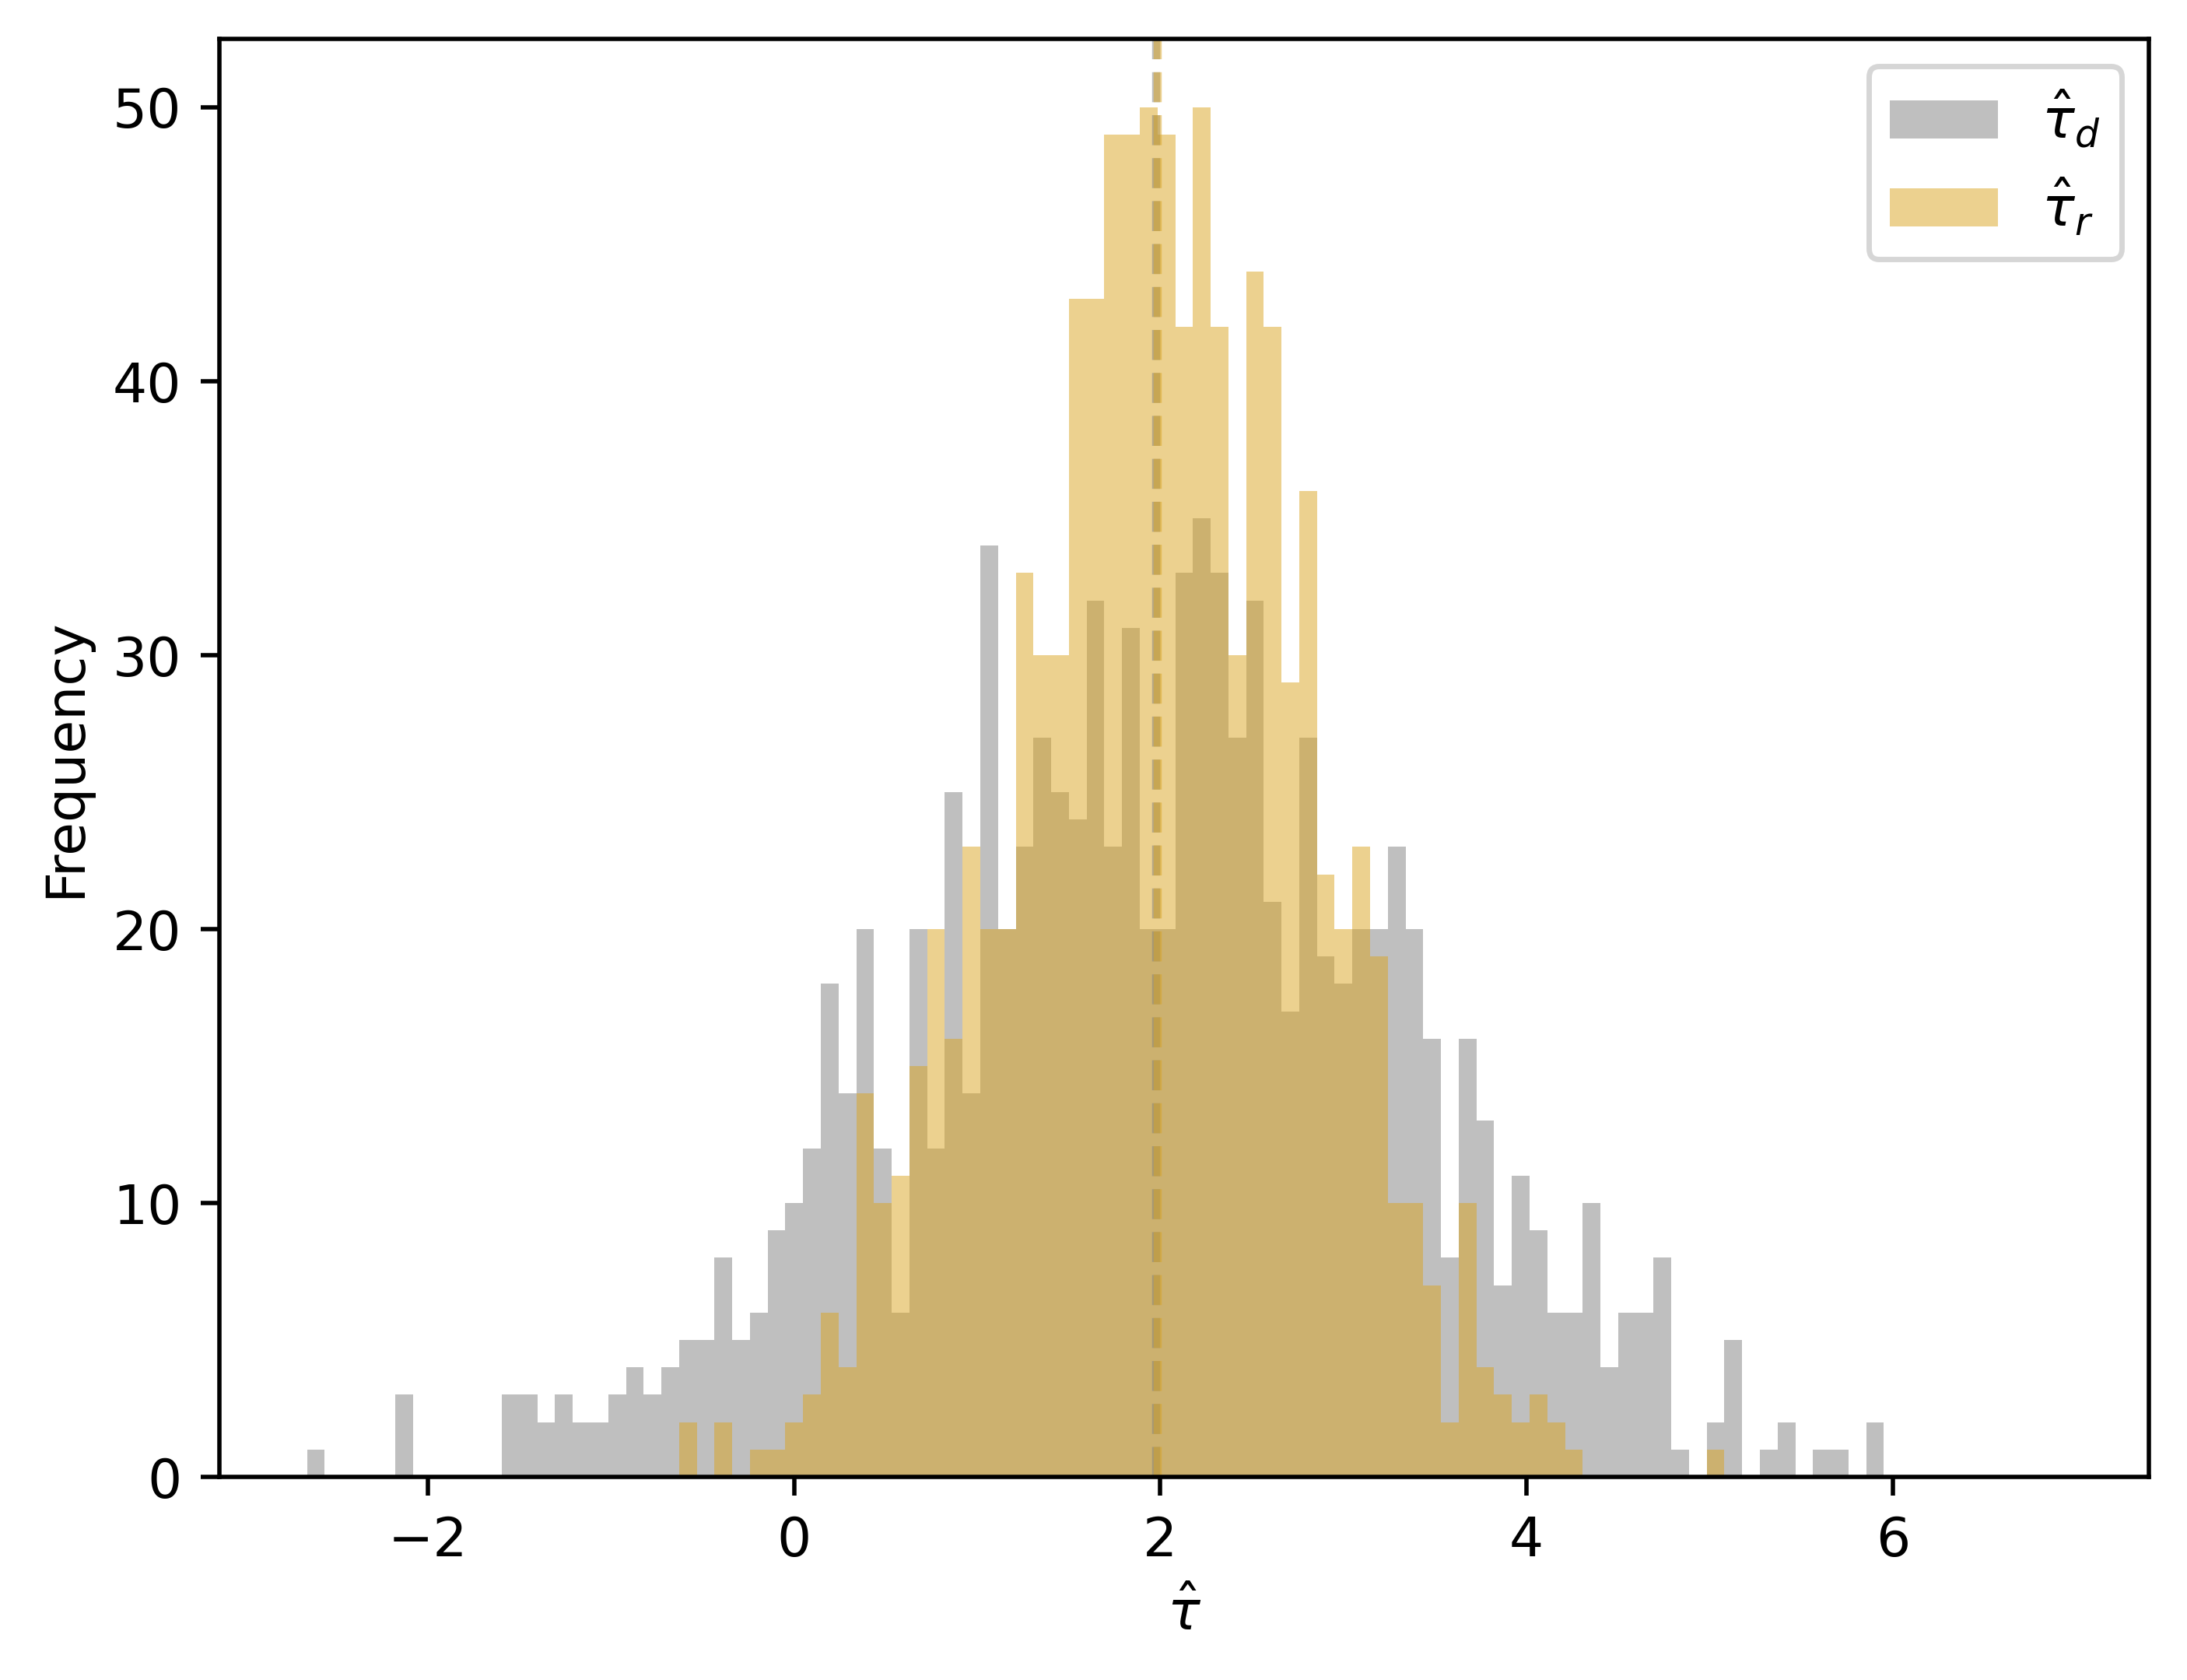

Sample size: 10 ATE_d: 1.9760411207348378 ATE_r: 1.9851764977982755


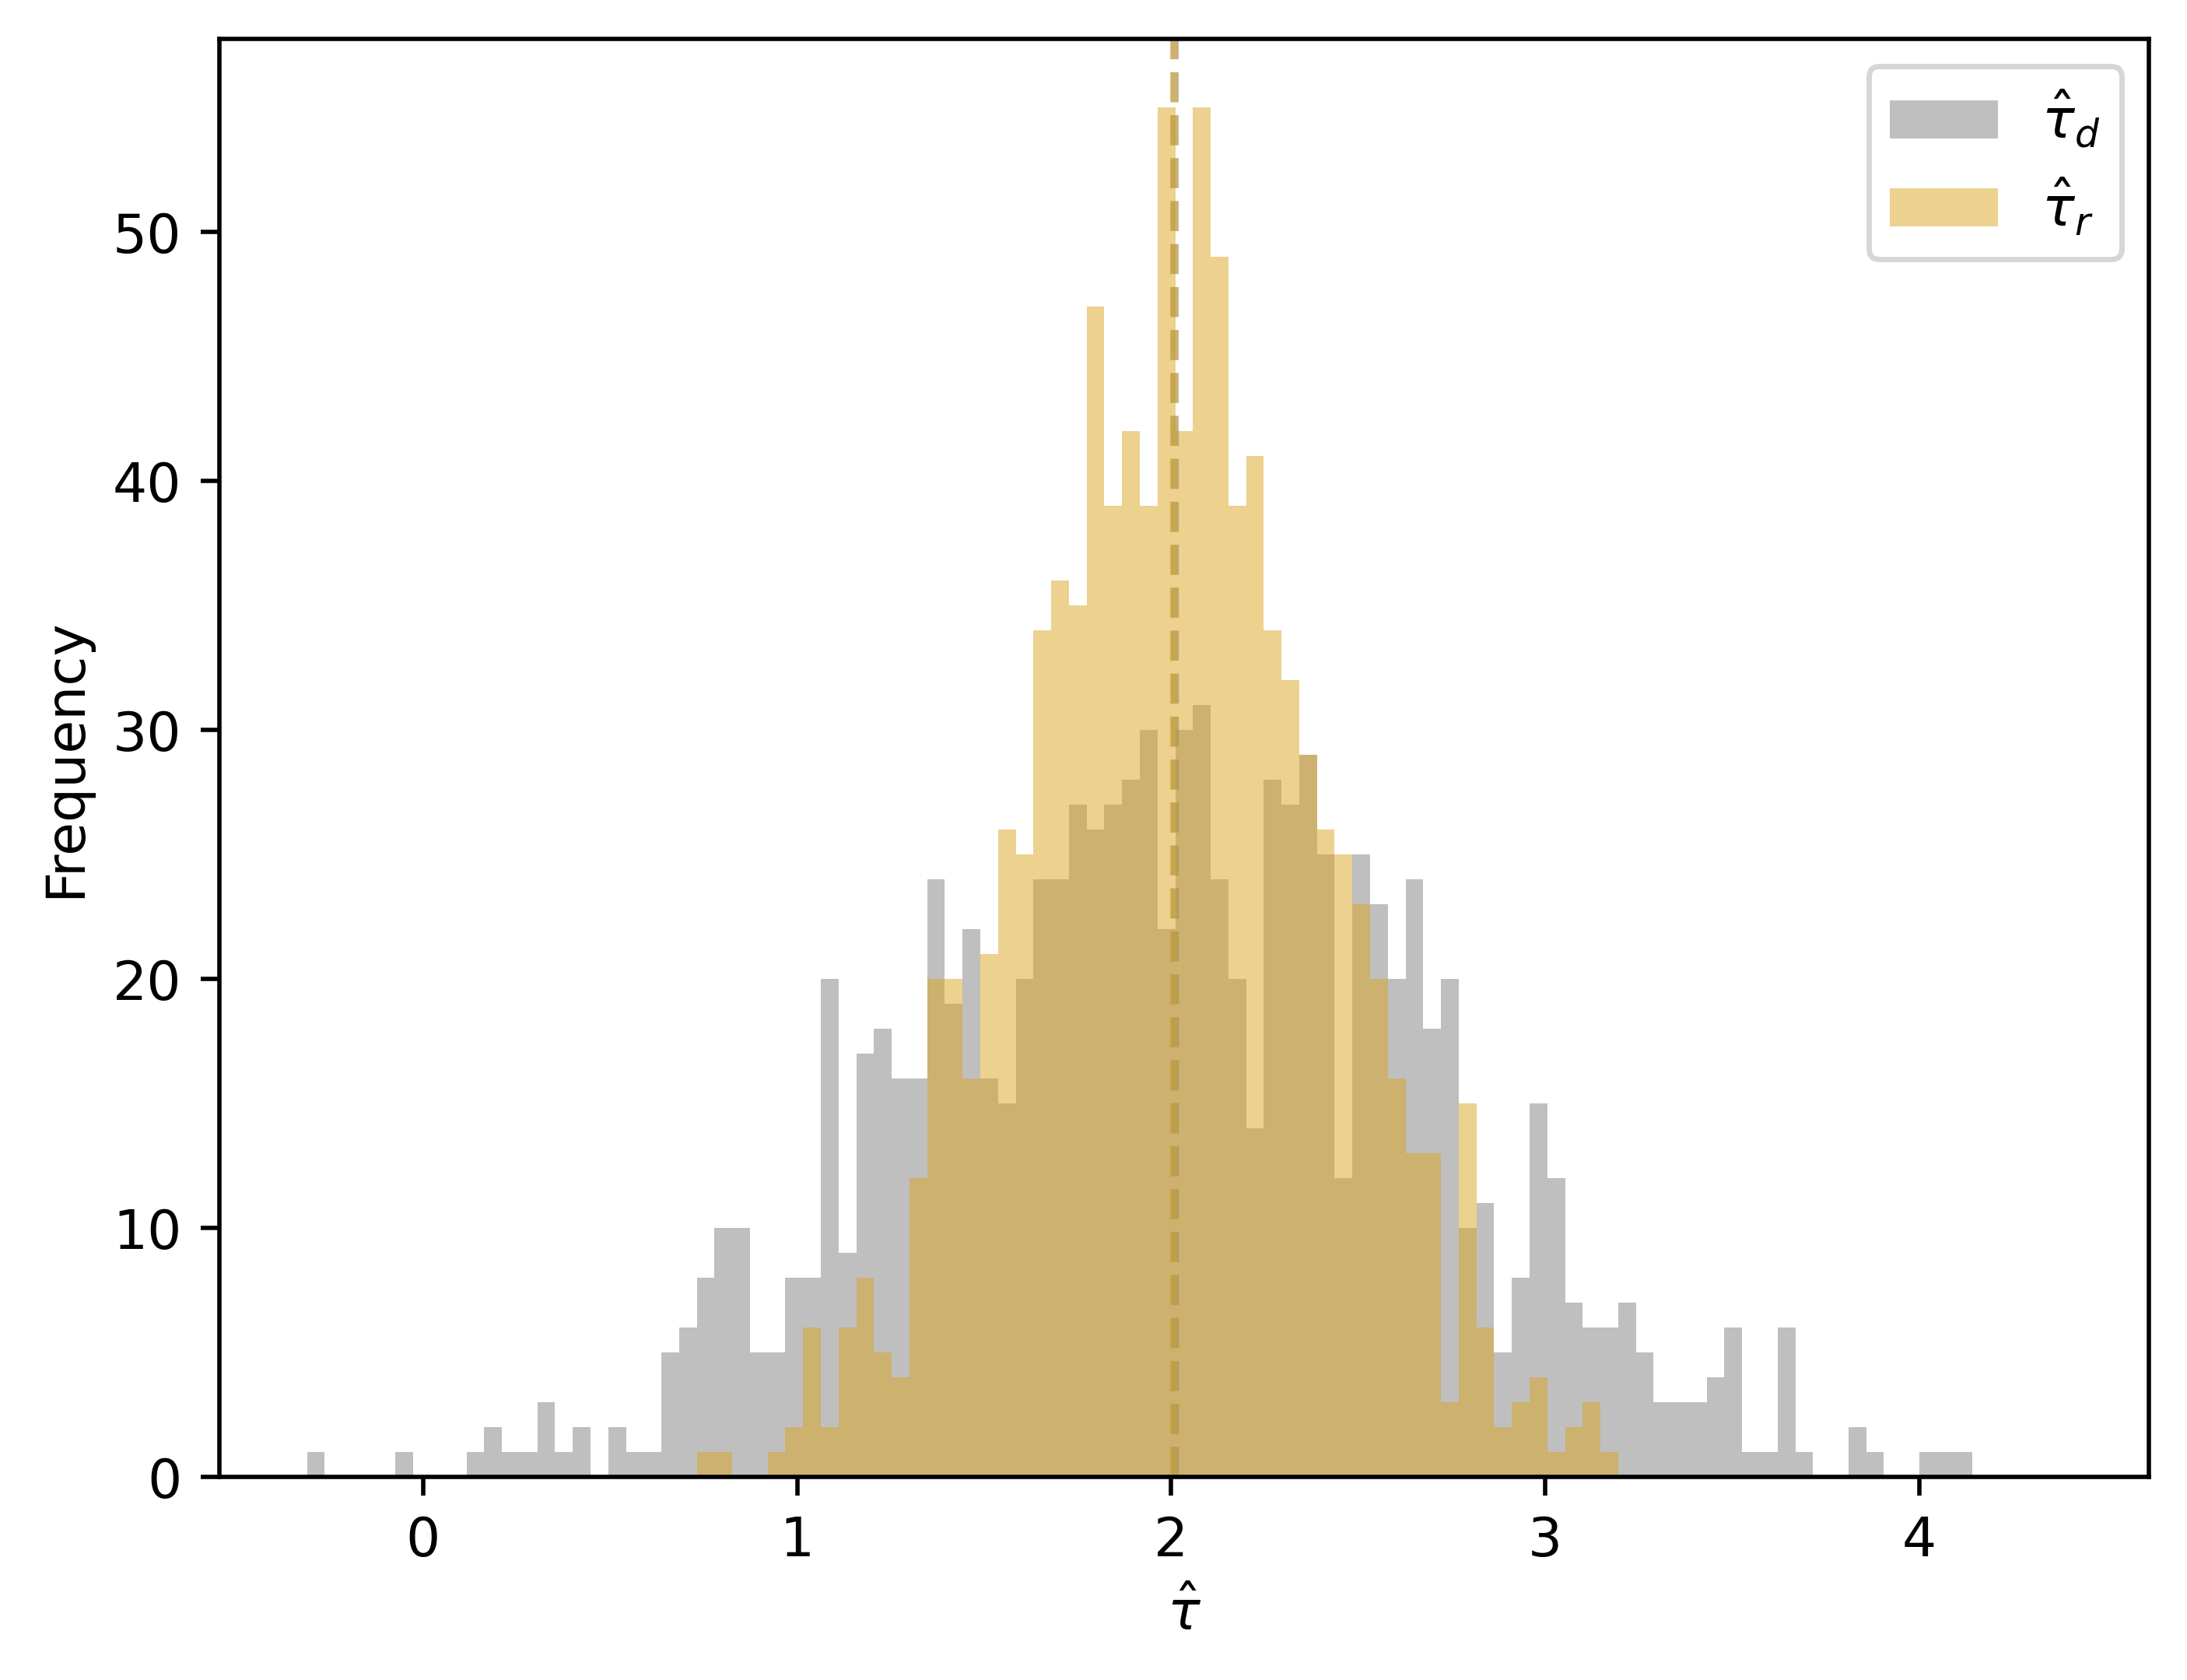

Sample size: 40 ATE_d: 2.0102915887934354 ATE_r: 2.007336601452813


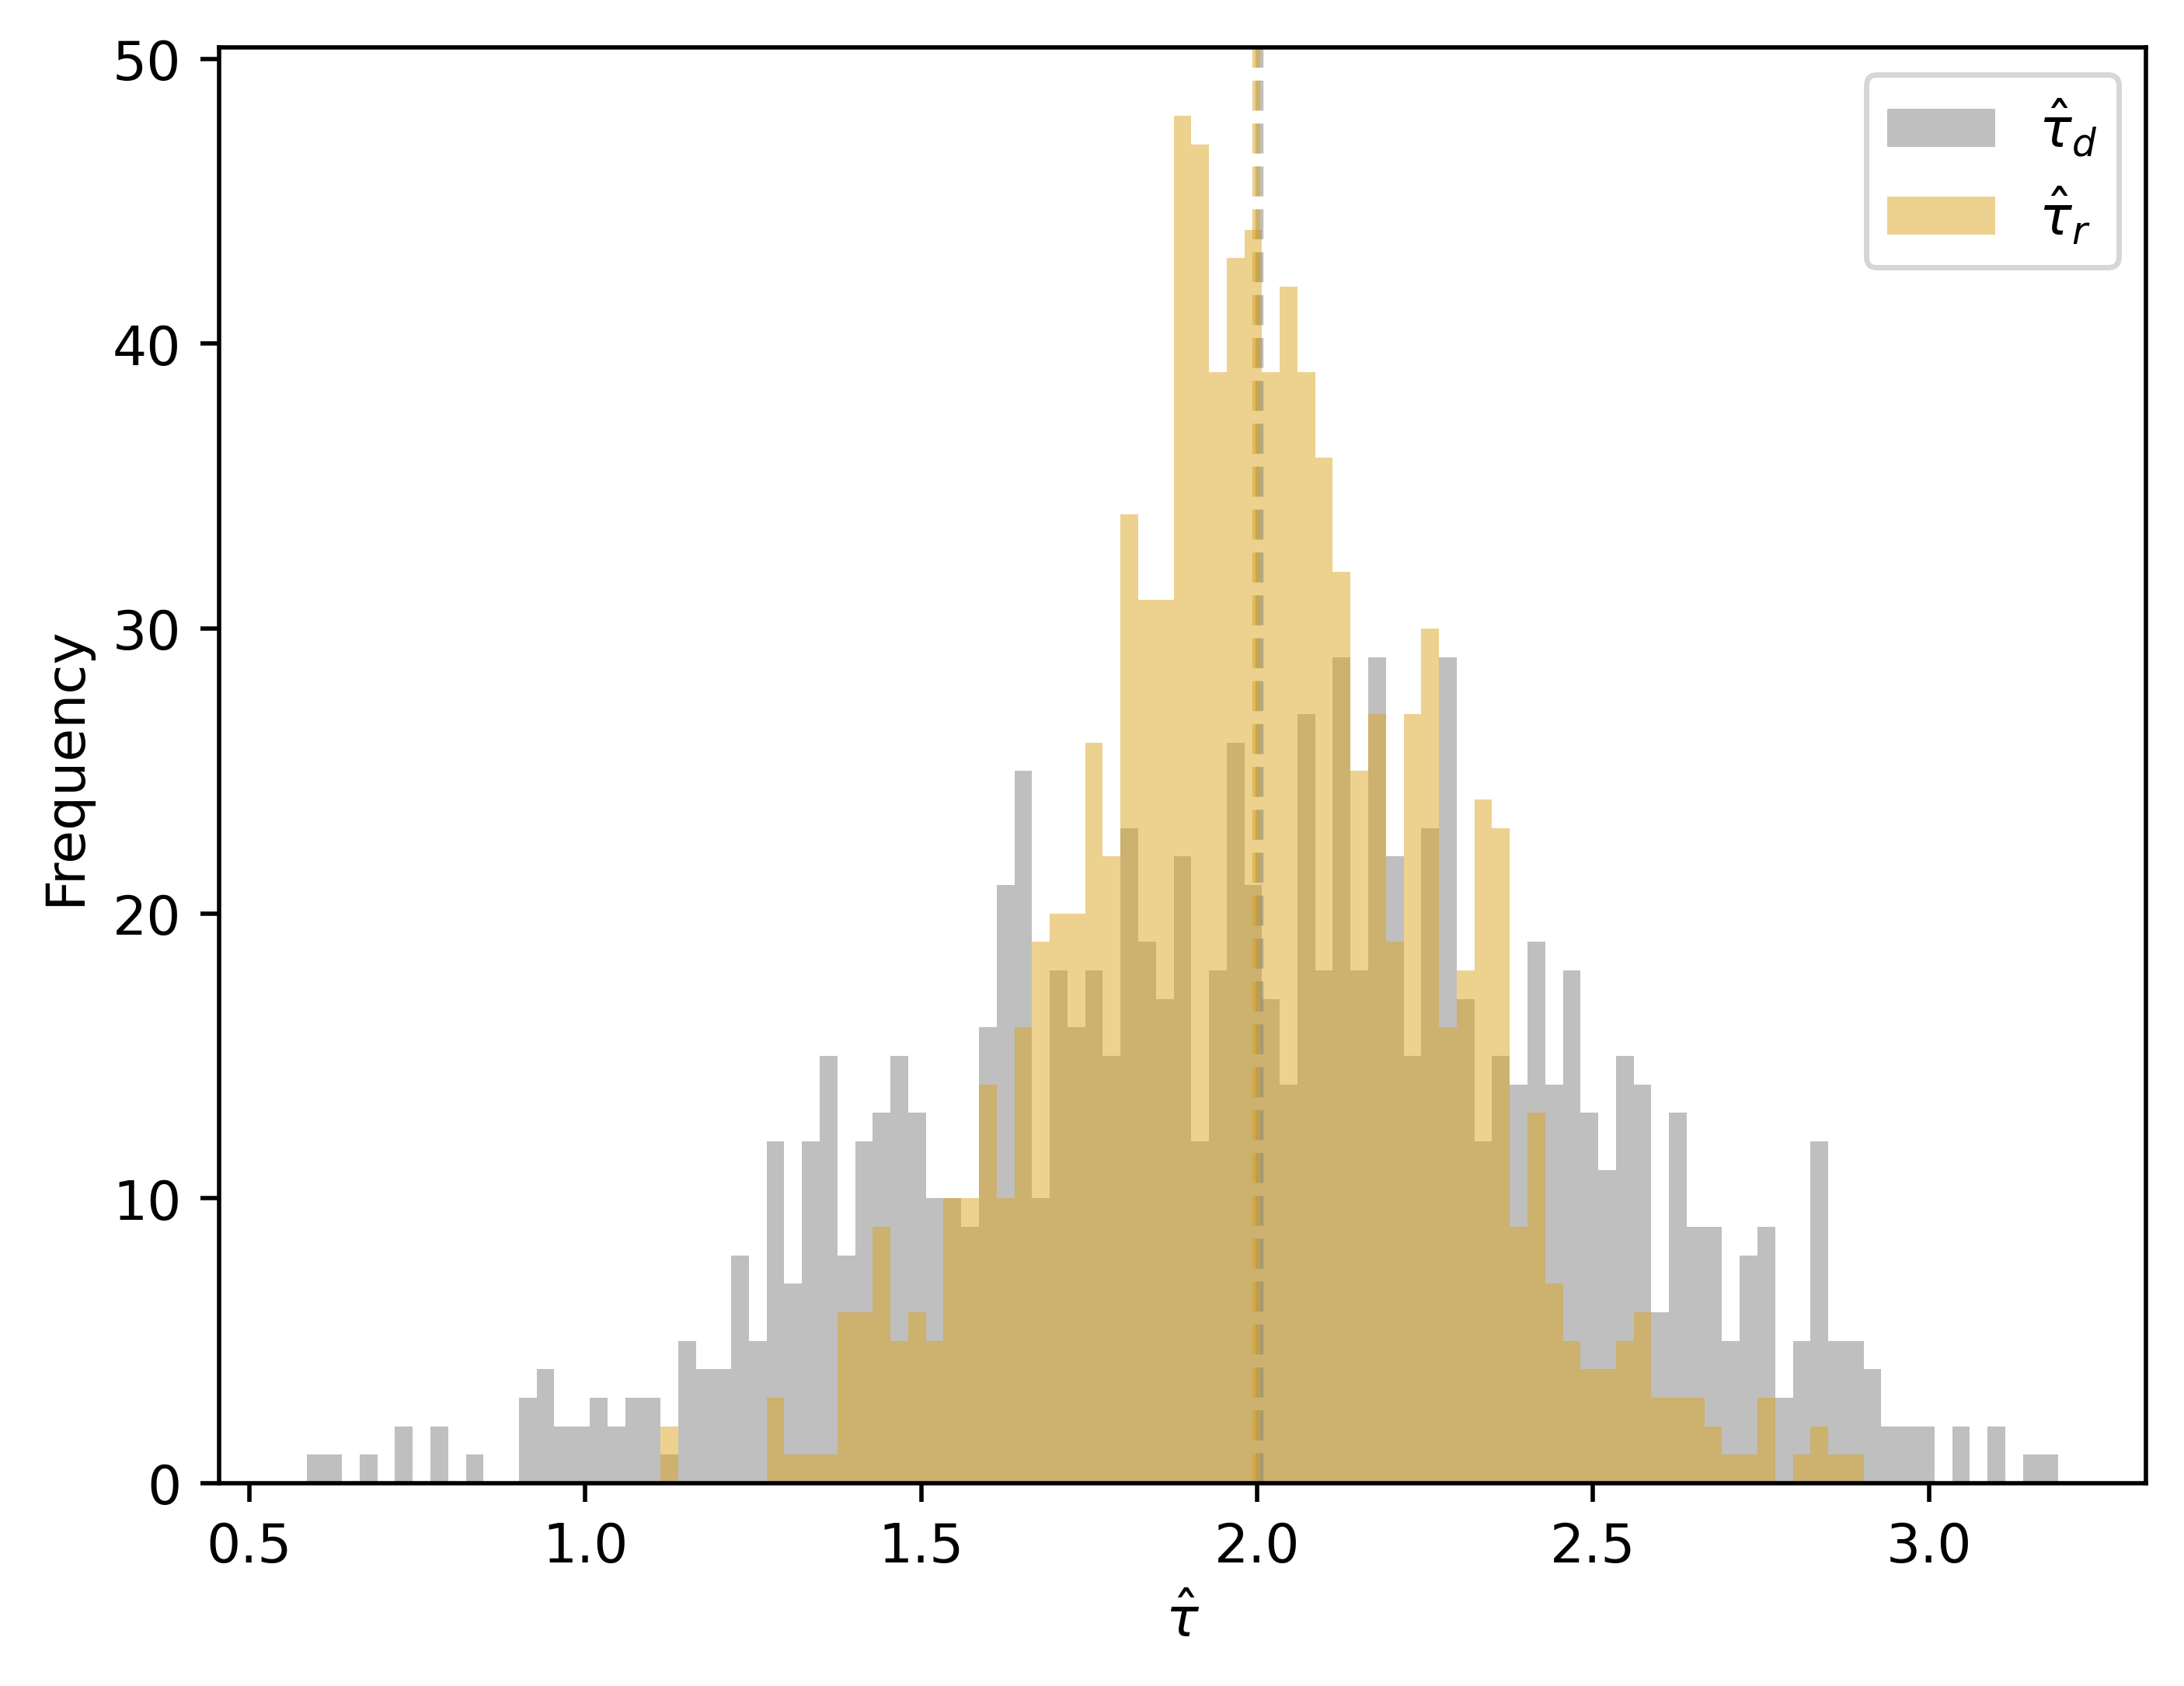

Sample size: 80 ATE_d: 2.003297441806425 ATE_r: 1.9983995110735167


In [5]:
colors = {'two': 'gray', 'reg': 'goldenrod', 'ml': 'cadetblue', 'mix': 'slateblue'}
for key in res:
    plt.figure(dpi=dpi)
    sim_res = res[key]
    # use this to first determine overall range, and manually set max and min with visual analysis
    bins_max = max(max(sim_res['two_est']),max(sim_res['reg_est']))
    bins_min = min(min(sim_res['two_est']),min(sim_res['reg_est']))
    #bins_max = 7
    #bins_min = -3
    bins_freq = 100
    bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
    plt.hist(sim_res['two_est'], bins = bins_range, color = colors['two'], label = r"$\hat{\tau}_d$", alpha=0.5)
    plt.hist(sim_res['reg_est'], bins = bins_range, color = colors['reg'], label=r"$\hat{\tau}_r$",alpha=0.5)
    #plt.hist(sim_res['pair_est2'],bins=np.arange(-1,6,0.1), label='paired_est2',alpha=0.5)
    plt.axvline(np.mean(sim_res['two_est']), color = colors['two'], linestyle='--',alpha=0.5)
    plt.axvline(np.mean(sim_res['reg_est']), color = colors['reg'], linestyle='--',alpha=0.5)
    plt.ylabel("Frequency")
    plt.xlabel(r"$\hat{\tau}$")
    plt.legend(loc=1)
    plt.savefig("plots/reg_" + str(key) + "_ate.png")
    plt.show()
    print("Sample size:",sample_sizes[key], "ATE_d:", np.mean(sim_res['two_est']), "ATE_r:", np.mean(sim_res['reg_est']))

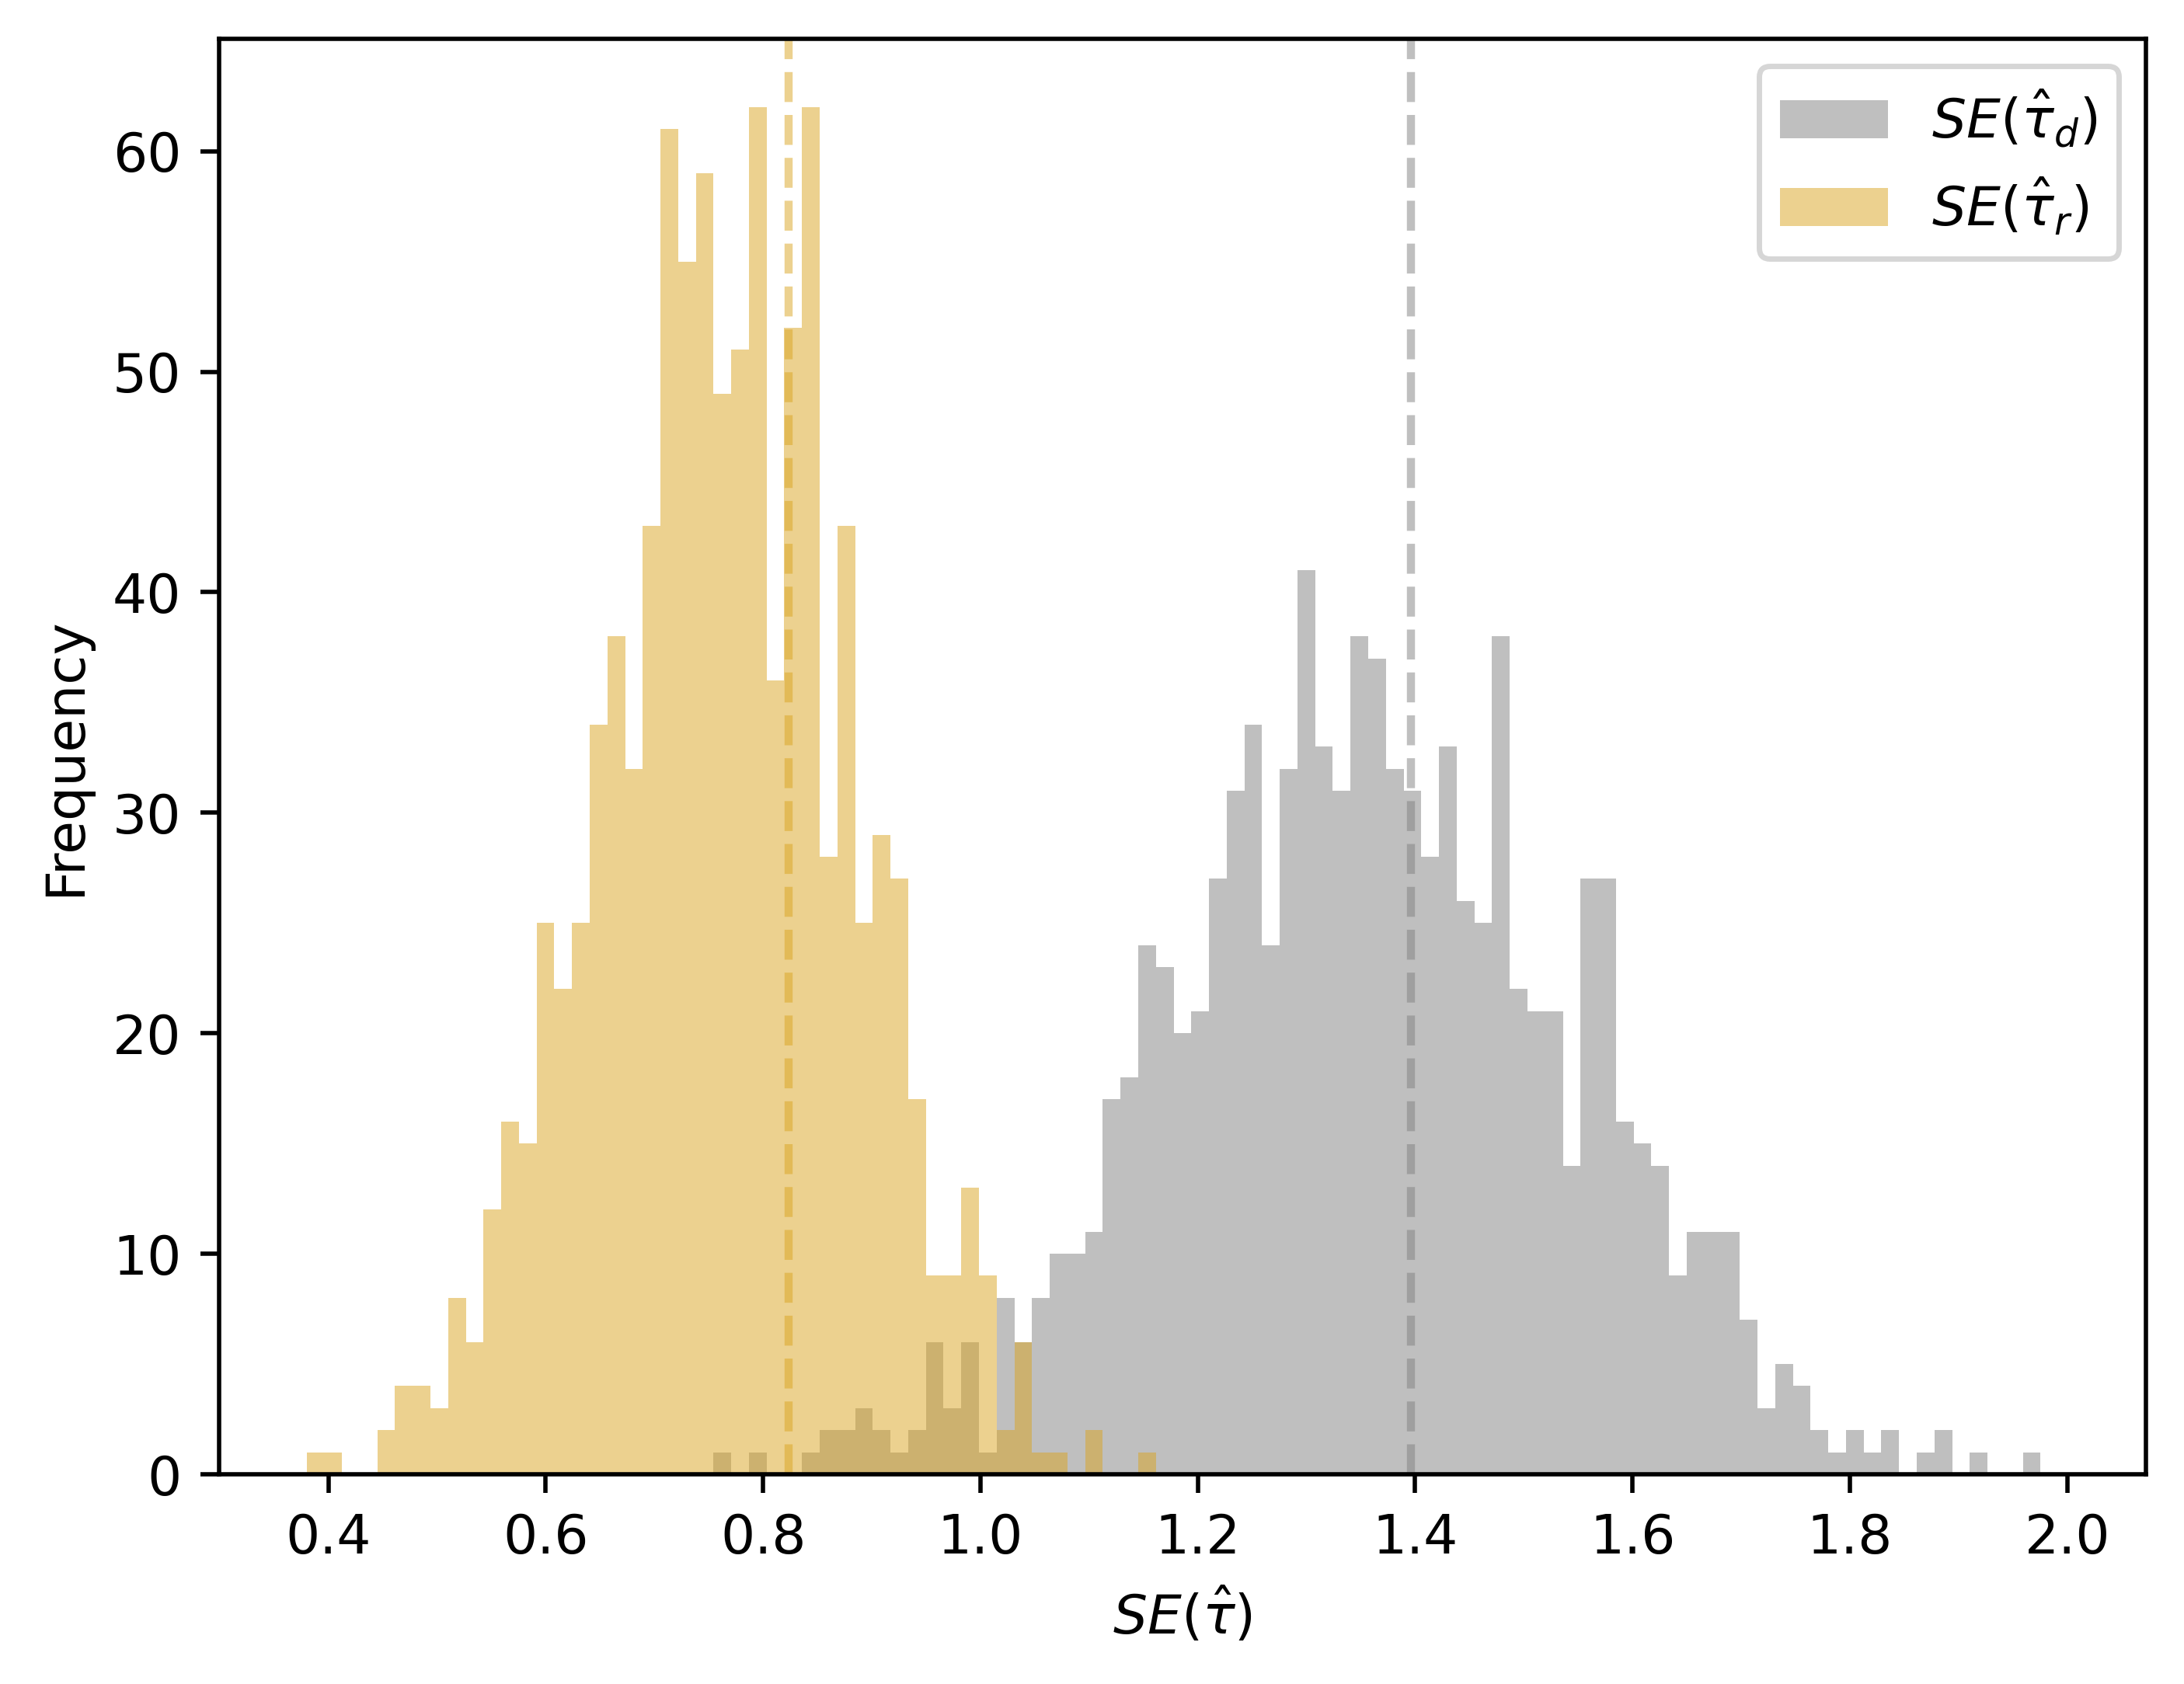

Std_d: 1.3971469144651147 Std_r: 0.8238463668835506 Var_red: 0.41033662361917544


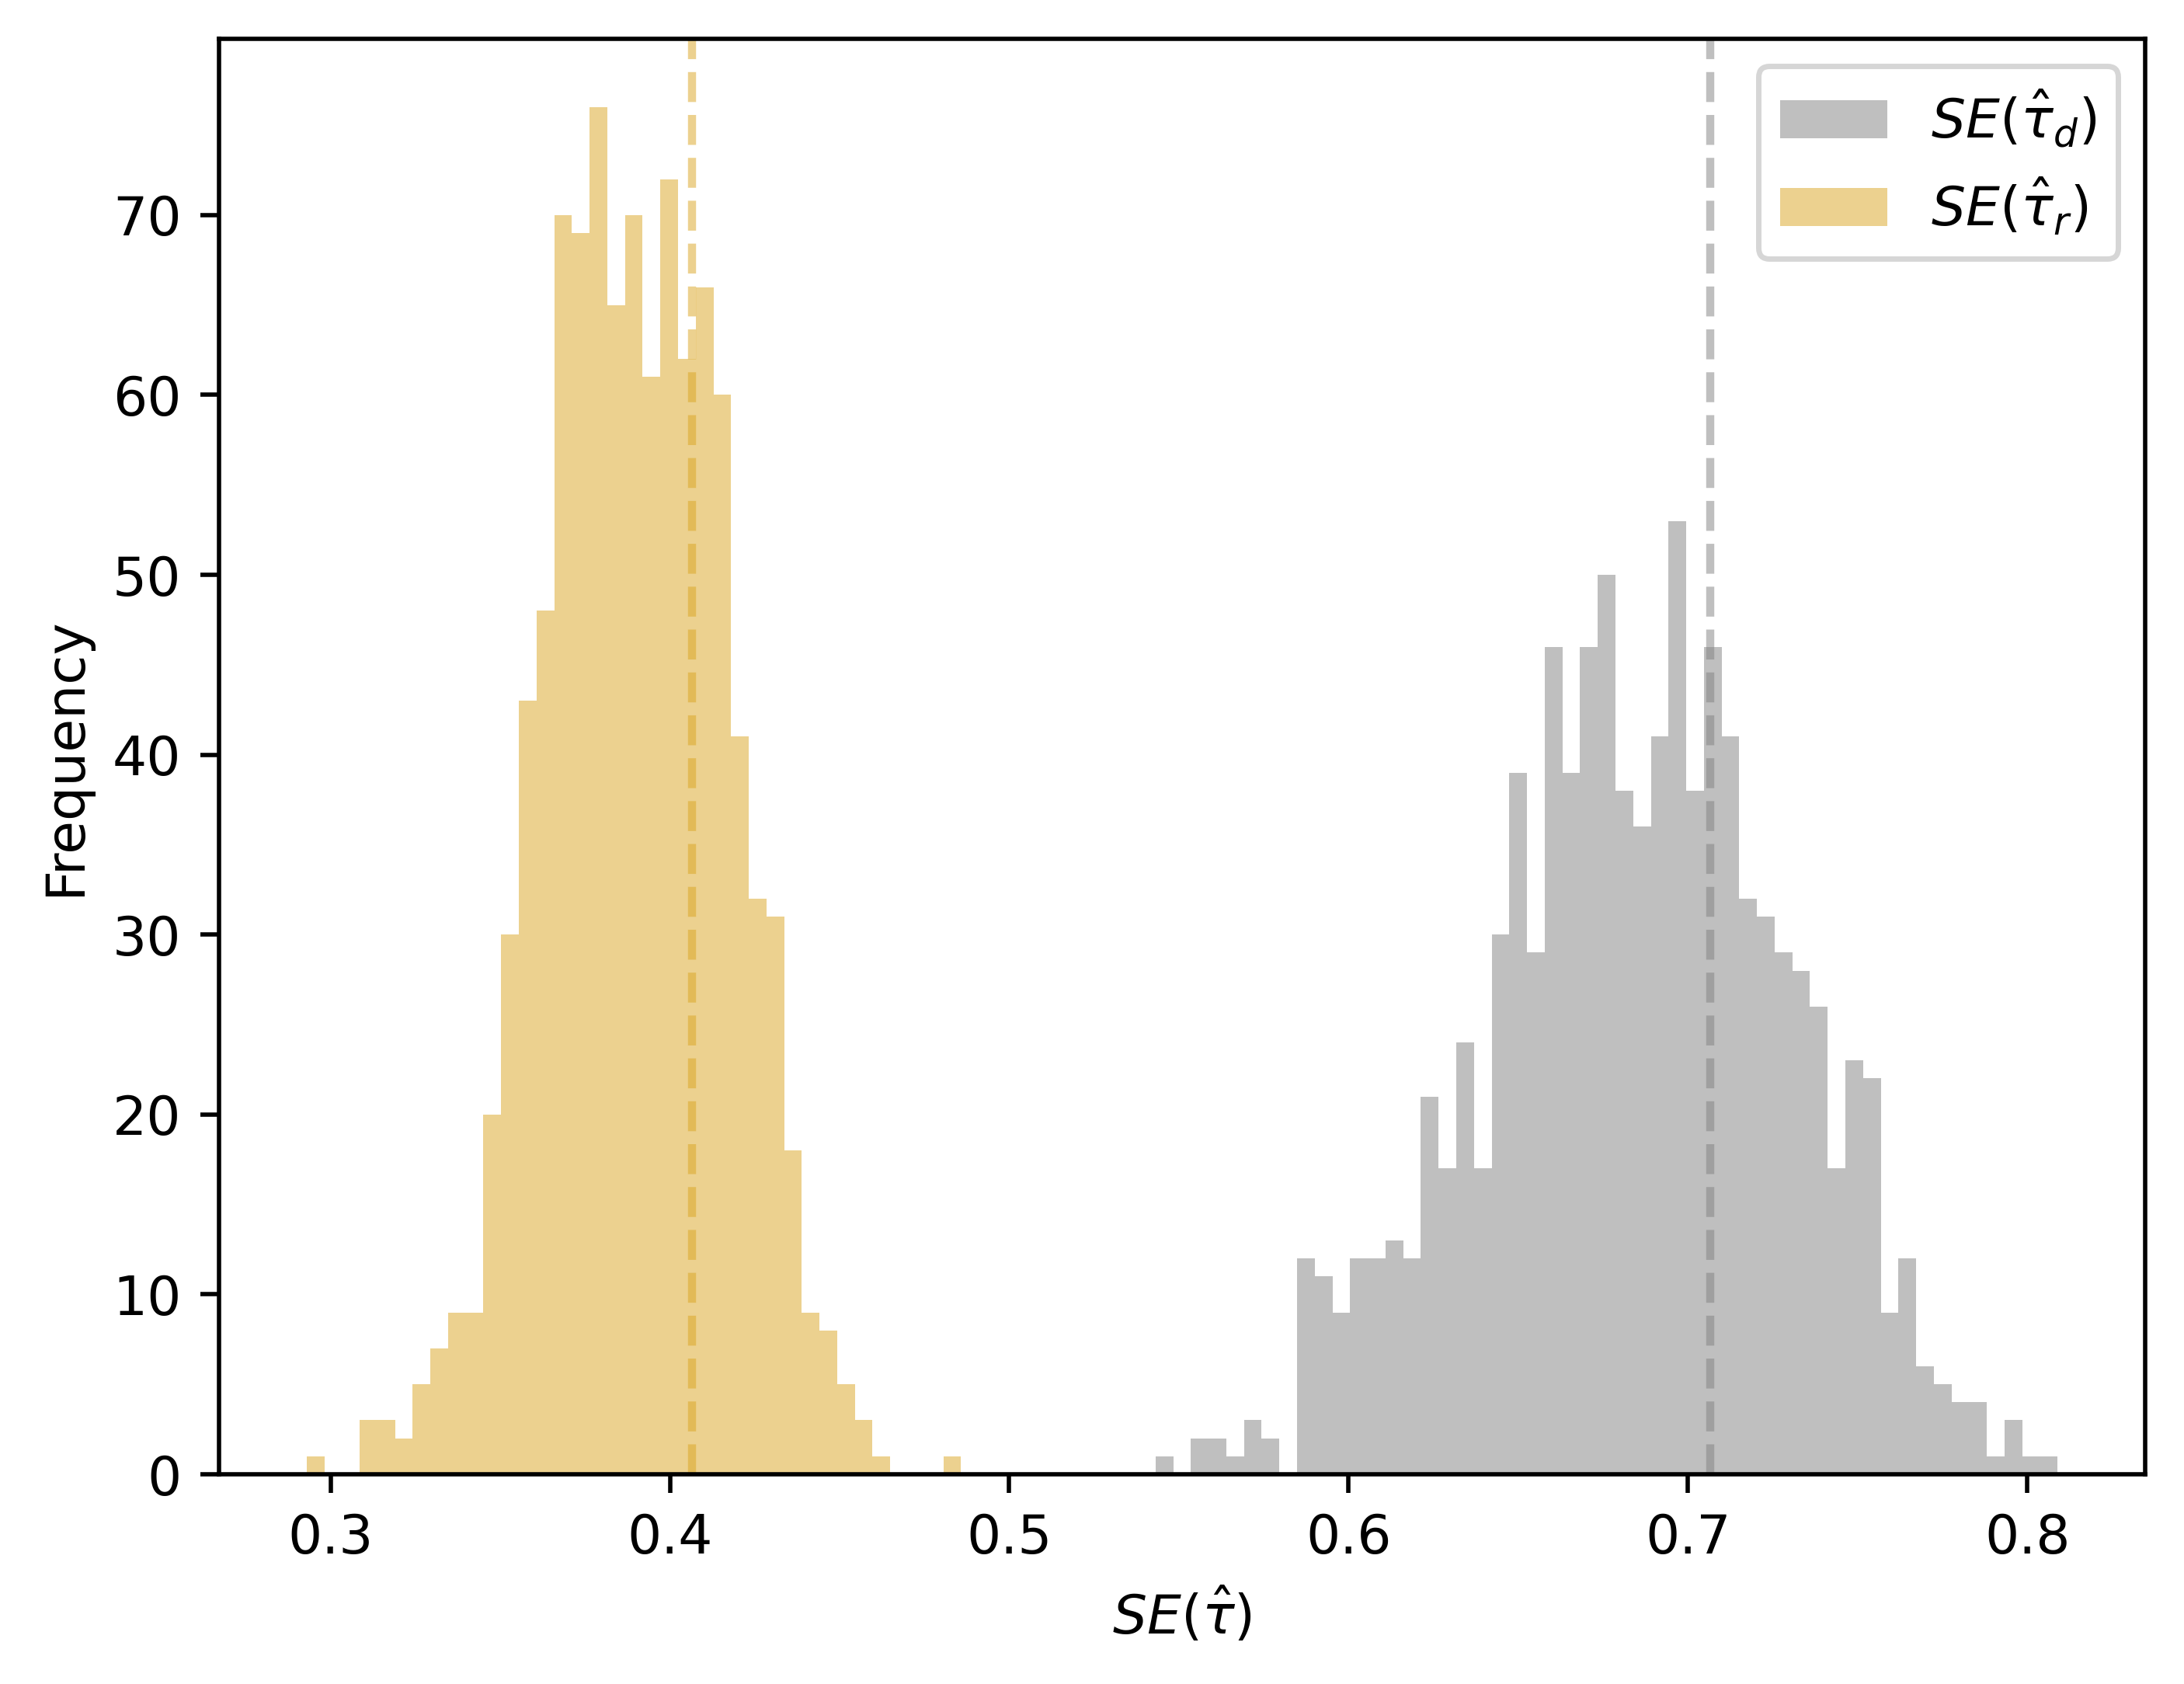

Std_d: 0.7068692647157091 Std_r: 0.40675158400232936 Var_red: 0.42457310806133575


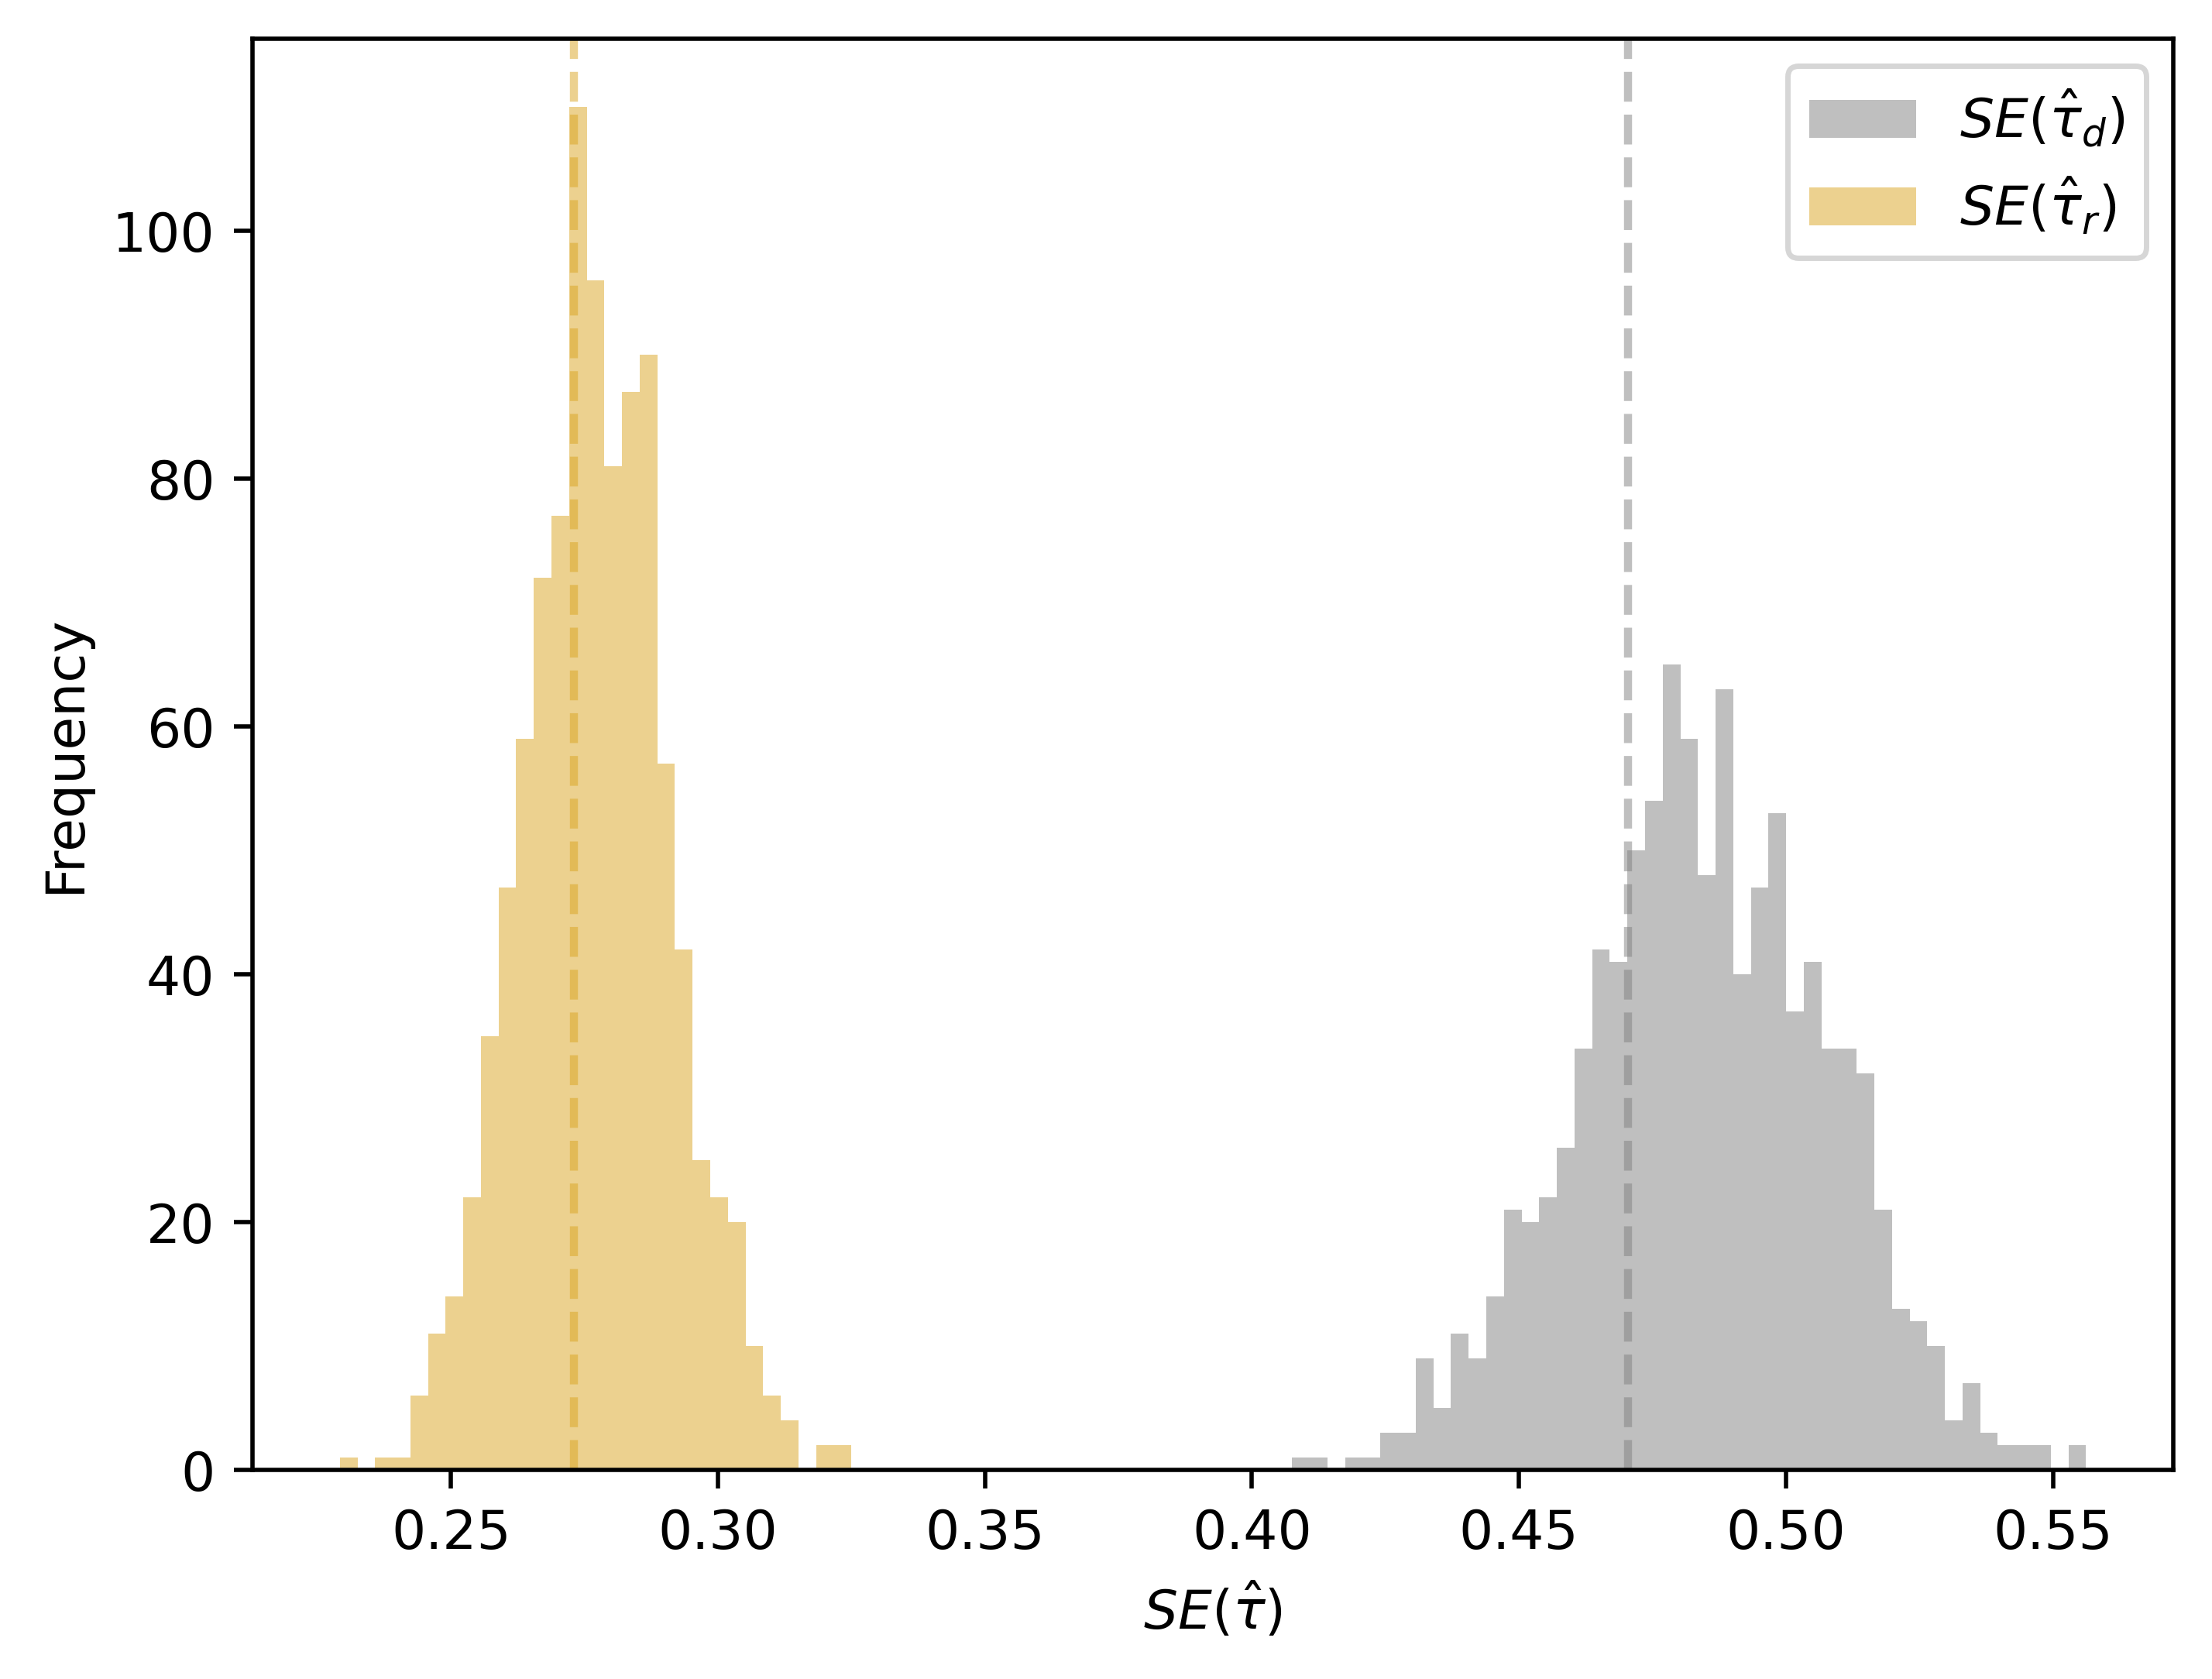

Std_d: 0.4707411297787625 Std_r: 0.27316795929107307 Var_red: 0.4197066242767957


In [6]:
for key in res:
    plt.figure(dpi=dpi)
    sim_res = res[key]
    # use this to first determine overall range, and manually set max and min with visual analysis
    bins_max = max(max(sim_res['two_se']),max(sim_res['reg_se']))
    bins_min = min(min(sim_res['two_se']),min(sim_res['reg_se']))
    #bins_max = 2
    #bins_min = 0.25
    bins_freq = 100
    bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
    plt.hist(sim_res['two_se'], bins = bins_range, color = colors['two'], label = r"$SE(\hat{\tau}_d)$", alpha=0.5)
    plt.hist(sim_res['reg_se'], bins = bins_range, color = colors['reg'], label=r"$SE(\hat{\tau}_r)$",alpha=0.5)
    plt.axvline(np.std(sim_res['two_est']), color = colors['two'], linestyle='--',alpha=0.5)
    plt.axvline(np.std(sim_res['reg_est']), color = colors['reg'], linestyle='--',alpha=0.5)
    plt.ylabel("Frequency")
    plt.xlabel(r"$SE(\hat{\tau})$")
    plt.legend(loc=1)
    plt.savefig("plots/reg_" + str(key) + "_se.png")
    plt.show()
    print("Std_d:", np.std(sim_res['two_est'],ddof=1), "Std_r:", np.std(sim_res['reg_est'],ddof=1), 
          "Var_red:", 1-np.std(sim_res['reg_est'],ddof=1)/np.std(sim_res['two_est'],ddof=1))

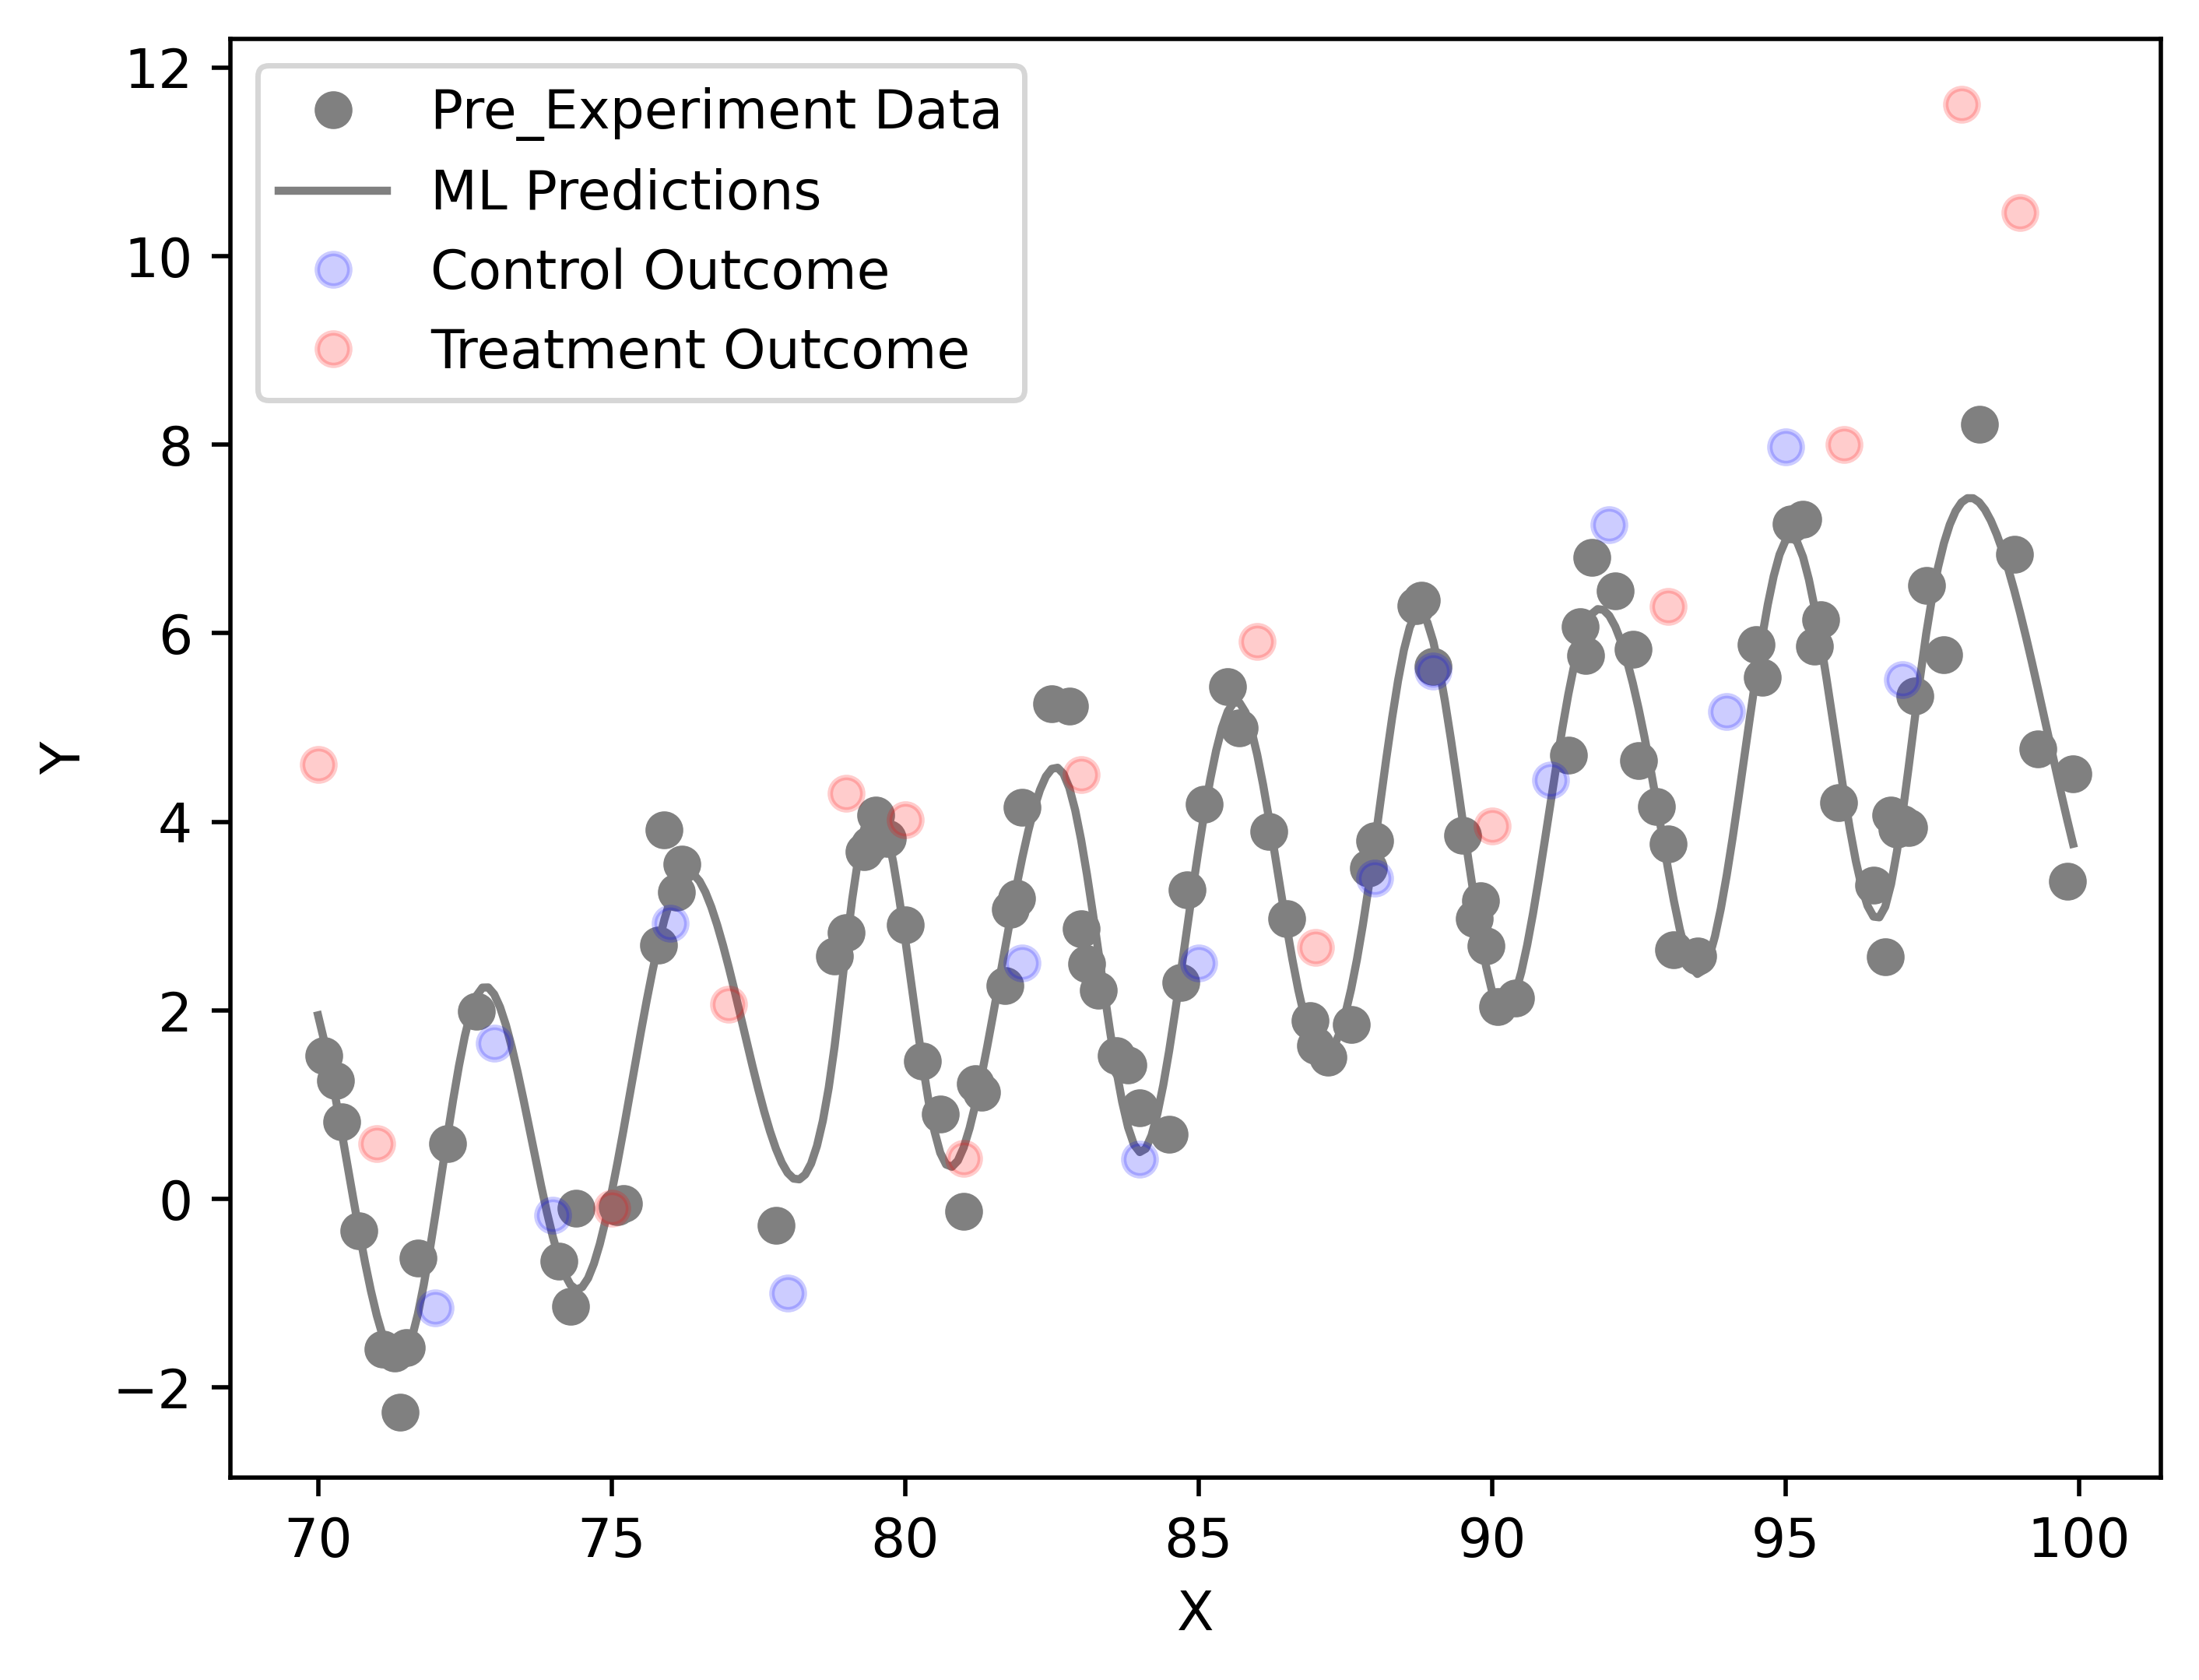

In [7]:
# use the same control/treatment data as the linear model example
plt.figure(dpi=dpi)
np.random.seed(1)
random.seed(1)
x = np.arange(70,100,1)
n = len(x)
error = np.random.normal(0,1,n)
def exp_data(x):
    return 2*np.sin(x*2) + 0.01*((x - 70)**2) + 0.4*error
y = exp_data(x)
te = 2
control_idx = random.sample(range(n),n//2)
treat_idx = list(set(range(n)).difference(control_idx))
control_idx.sort()
treat_idx.sort()
control_x = x[control_idx]
treat_x = x[treat_idx]
control_y = y[control_idx]
treat_y = y[treat_idx] + te

def pre_exp(x):
    return 2*np.sin(x*2) + 0.2*((x - 70))
x = np.arange(70,100,0.1)
#y = pre_exp(x)
#plt.plot(x,y, label = 'ML Predictions',color='grey')
x_pre = np.array(random.sample(list(np.arange(70,100,0.1)), 100))
x_pre.sort()
y_pre = pre_exp(x_pre) + np.random.normal(0,1,len(x_pre)) * 0.5
tck = splrep(x_pre, y_pre, s=20)
plt.plot(x_pre, y_pre, 'o',color='grey',label="Pre_Experiment Data")
plt.plot(x,BSpline(*tck)(x), label = 'ML Predictions',color='grey')
#x2 = np.arange(70,100,0.1)
#y2 = pre_exp(x2)
#plt.plot(x2,y2,color='chocolate',label='Predictions from Pre-Experiment Data')
#plt.axvline(70,color='black',linestyle='--')
plt.plot(control_x, control_y, 'o', color = 'blue', label='Control Outcome',alpha=0.2)
plt.plot(treat_x, treat_y, 'o', color = 'red', label = 'Treatment Outcome',alpha=0.2)
plt.ylabel("Y")
plt.xlabel("X")
plt.legend(loc='upper left')
plt.savefig("plots/preexp_preds.png")

ATE: 1.7936573264735338 SE: 0.44645255255041105


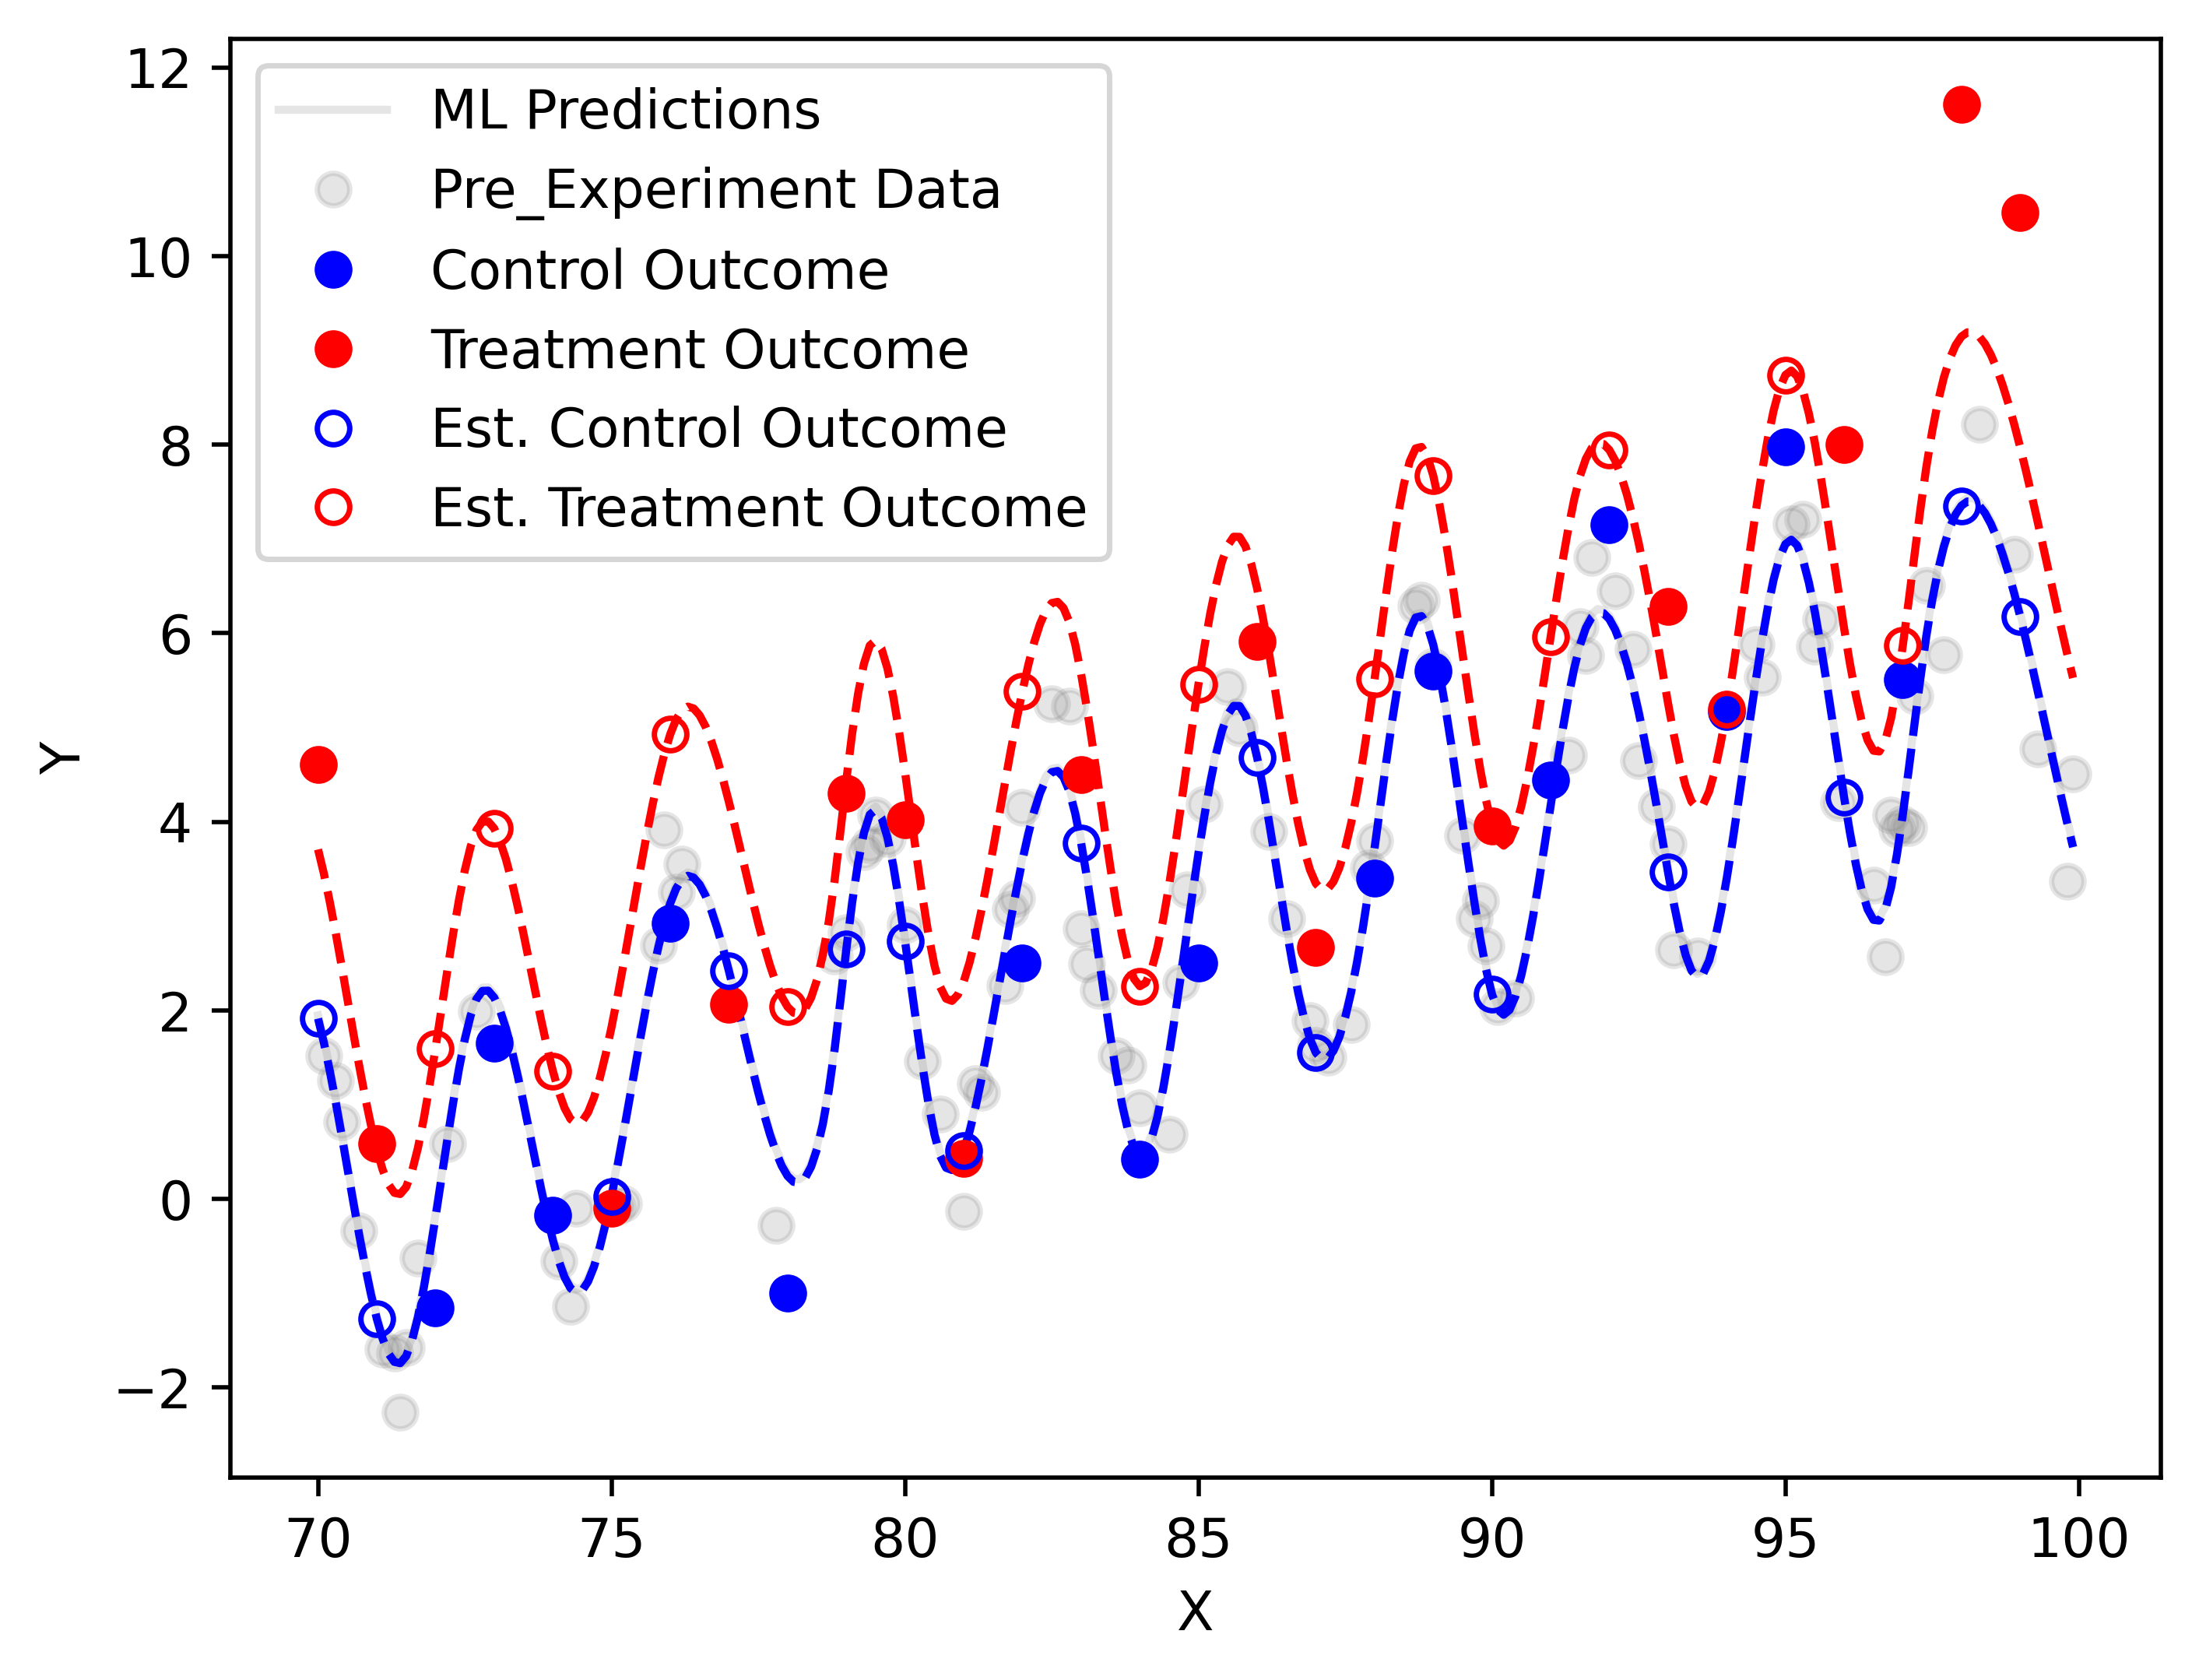

In [8]:
plt.figure(dpi=dpi)
alpha1 = np.mean(treat_y - BSpline(*tck)(treat_x))
alpha0 = np.mean(control_y - BSpline(*tck)(control_x))
treat_line = alpha1 + BSpline(*tck)(x)
control_line = alpha0 + BSpline(*tck)(x)
plt.plot(x,BSpline(*tck)(x), label = 'ML Predictions',color='grey',alpha=0.2)
plt.plot(x_pre, y_pre, 'o',color='grey',label="Pre_Experiment Data",alpha=0.2)
#plt.plot(x2,y2,color='chocolate',label='Predictions from Pre-Experiment Data')
plt.plot(x,treat_line, color='red',linestyle='--')
plt.plot(x,control_line, color='blue',linestyle='--')
#plt.axvline(70,color='black',linestyle='--')
plt.plot(control_x, control_y, 'o', color = 'blue', label='Control Outcome')
plt.plot(treat_x, treat_y, 'o', color = 'red', label = 'Treatment Outcome')
plt.plot(treat_x, alpha0 + BSpline(*tck)(treat_x),'o',fillstyle='none',color='blue',label='Est. Control Outcome')
plt.plot(control_x, alpha1 + BSpline(*tck)(control_x),'o',fillstyle='none',color='red',label='Est. Treatment Outcome')
plt.ylabel("Y")
plt.xlabel("X")
plt.legend(loc='upper left')
plt.savefig("plots/preexp_cf.png")
ATE = alpha1 - alpha0
SE = (np.var(treat_y - BSpline(*tck)(treat_x))/len(treat_y) + np.var(control_y - BSpline(*tck)(control_x))/len(control_y))**0.5
print("ATE:",ATE,"SE:",SE)

In [9]:
np.random.seed(1)
random.seed(1)
sim_num = 1000
sample_sizes = {1: 10, 2: 40, 3:80}
res = {}
# define the original x and y (without treatment)
x = np.arange(70,100,1)
n = len(x)
error = np.random.normal(0,1,n)
def exp_data(x):
    return 2*np.sin(x*2) + 0.01*((x - 70)**2) + 0.4*error
y = exp_data(x)
te = 2
for key in sample_sizes:
    temp = []
    n0 = sample_sizes[key]
    n1 = sample_sizes[key]
    for i in range(sim_num):
        #control_idx = random.sample(range(n),n//2)
        #treat_idx = list(set(range(n)).difference(control_idx))
        # or if with replacement
        control_idx = random.choices(range(n), k=n0)
        treat_idx = random.choices(range(n), k=n1)
        control_idx.sort()
        treat_idx.sort()
        control_x = x[control_idx]
        treat_x = x[treat_idx]
        control_y = y[control_idx]
        treat_y = y[treat_idx] + te

        # perform difference in means
        two_est = np.mean(treat_y) - np.mean(control_y)
        two_se = (np.var(treat_y,ddof=1)/n1 + np.var(control_y,ddof=1)/n0)**0.5

        # perform counterfactual estimator with regression
        treatxvar = np.var(treat_x)
        controlxvar = np.var(control_x)
        treatxcov = np.cov(treat_x, treat_y)[0,1]
        controlxcov = np.cov(control_x, control_y)[0,1]
        beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
        alpha1 = np.mean(treat_y) - np.mean(treat_x)*beta
        alpha0 = np.mean(control_y) - np.mean(control_x)*beta
        reg_est = alpha1 - alpha0
        reg_se = (np.var(treat_y - treat_x * beta,ddof=1)/len(treat_y) + np.var(control_y - control_x * beta,ddof=1)/len(control_y))**0.5
        
        # perform counterfactual estimator with ML
        treat_preds = BSpline(*tck)(treat_x)
        control_preds = BSpline(*tck)(control_x)
        pred_alpha1 = np.mean(treat_y - treat_preds)
        pred_alpha0 = np.mean(control_y - control_preds)
        ml_est = pred_alpha1 - pred_alpha0
        ml_se = (np.var(treat_y - treat_preds,ddof=1)/len(treat_y) + np.var(control_y - control_preds,ddof=1)/len(control_y))**0.5
        temp.append([two_est, two_se, reg_est, reg_se, ml_est, ml_se])

    res[key] = pd.DataFrame(temp, columns = ['two_est','two_se','reg_est','reg_se','ml_est','ml_se'])

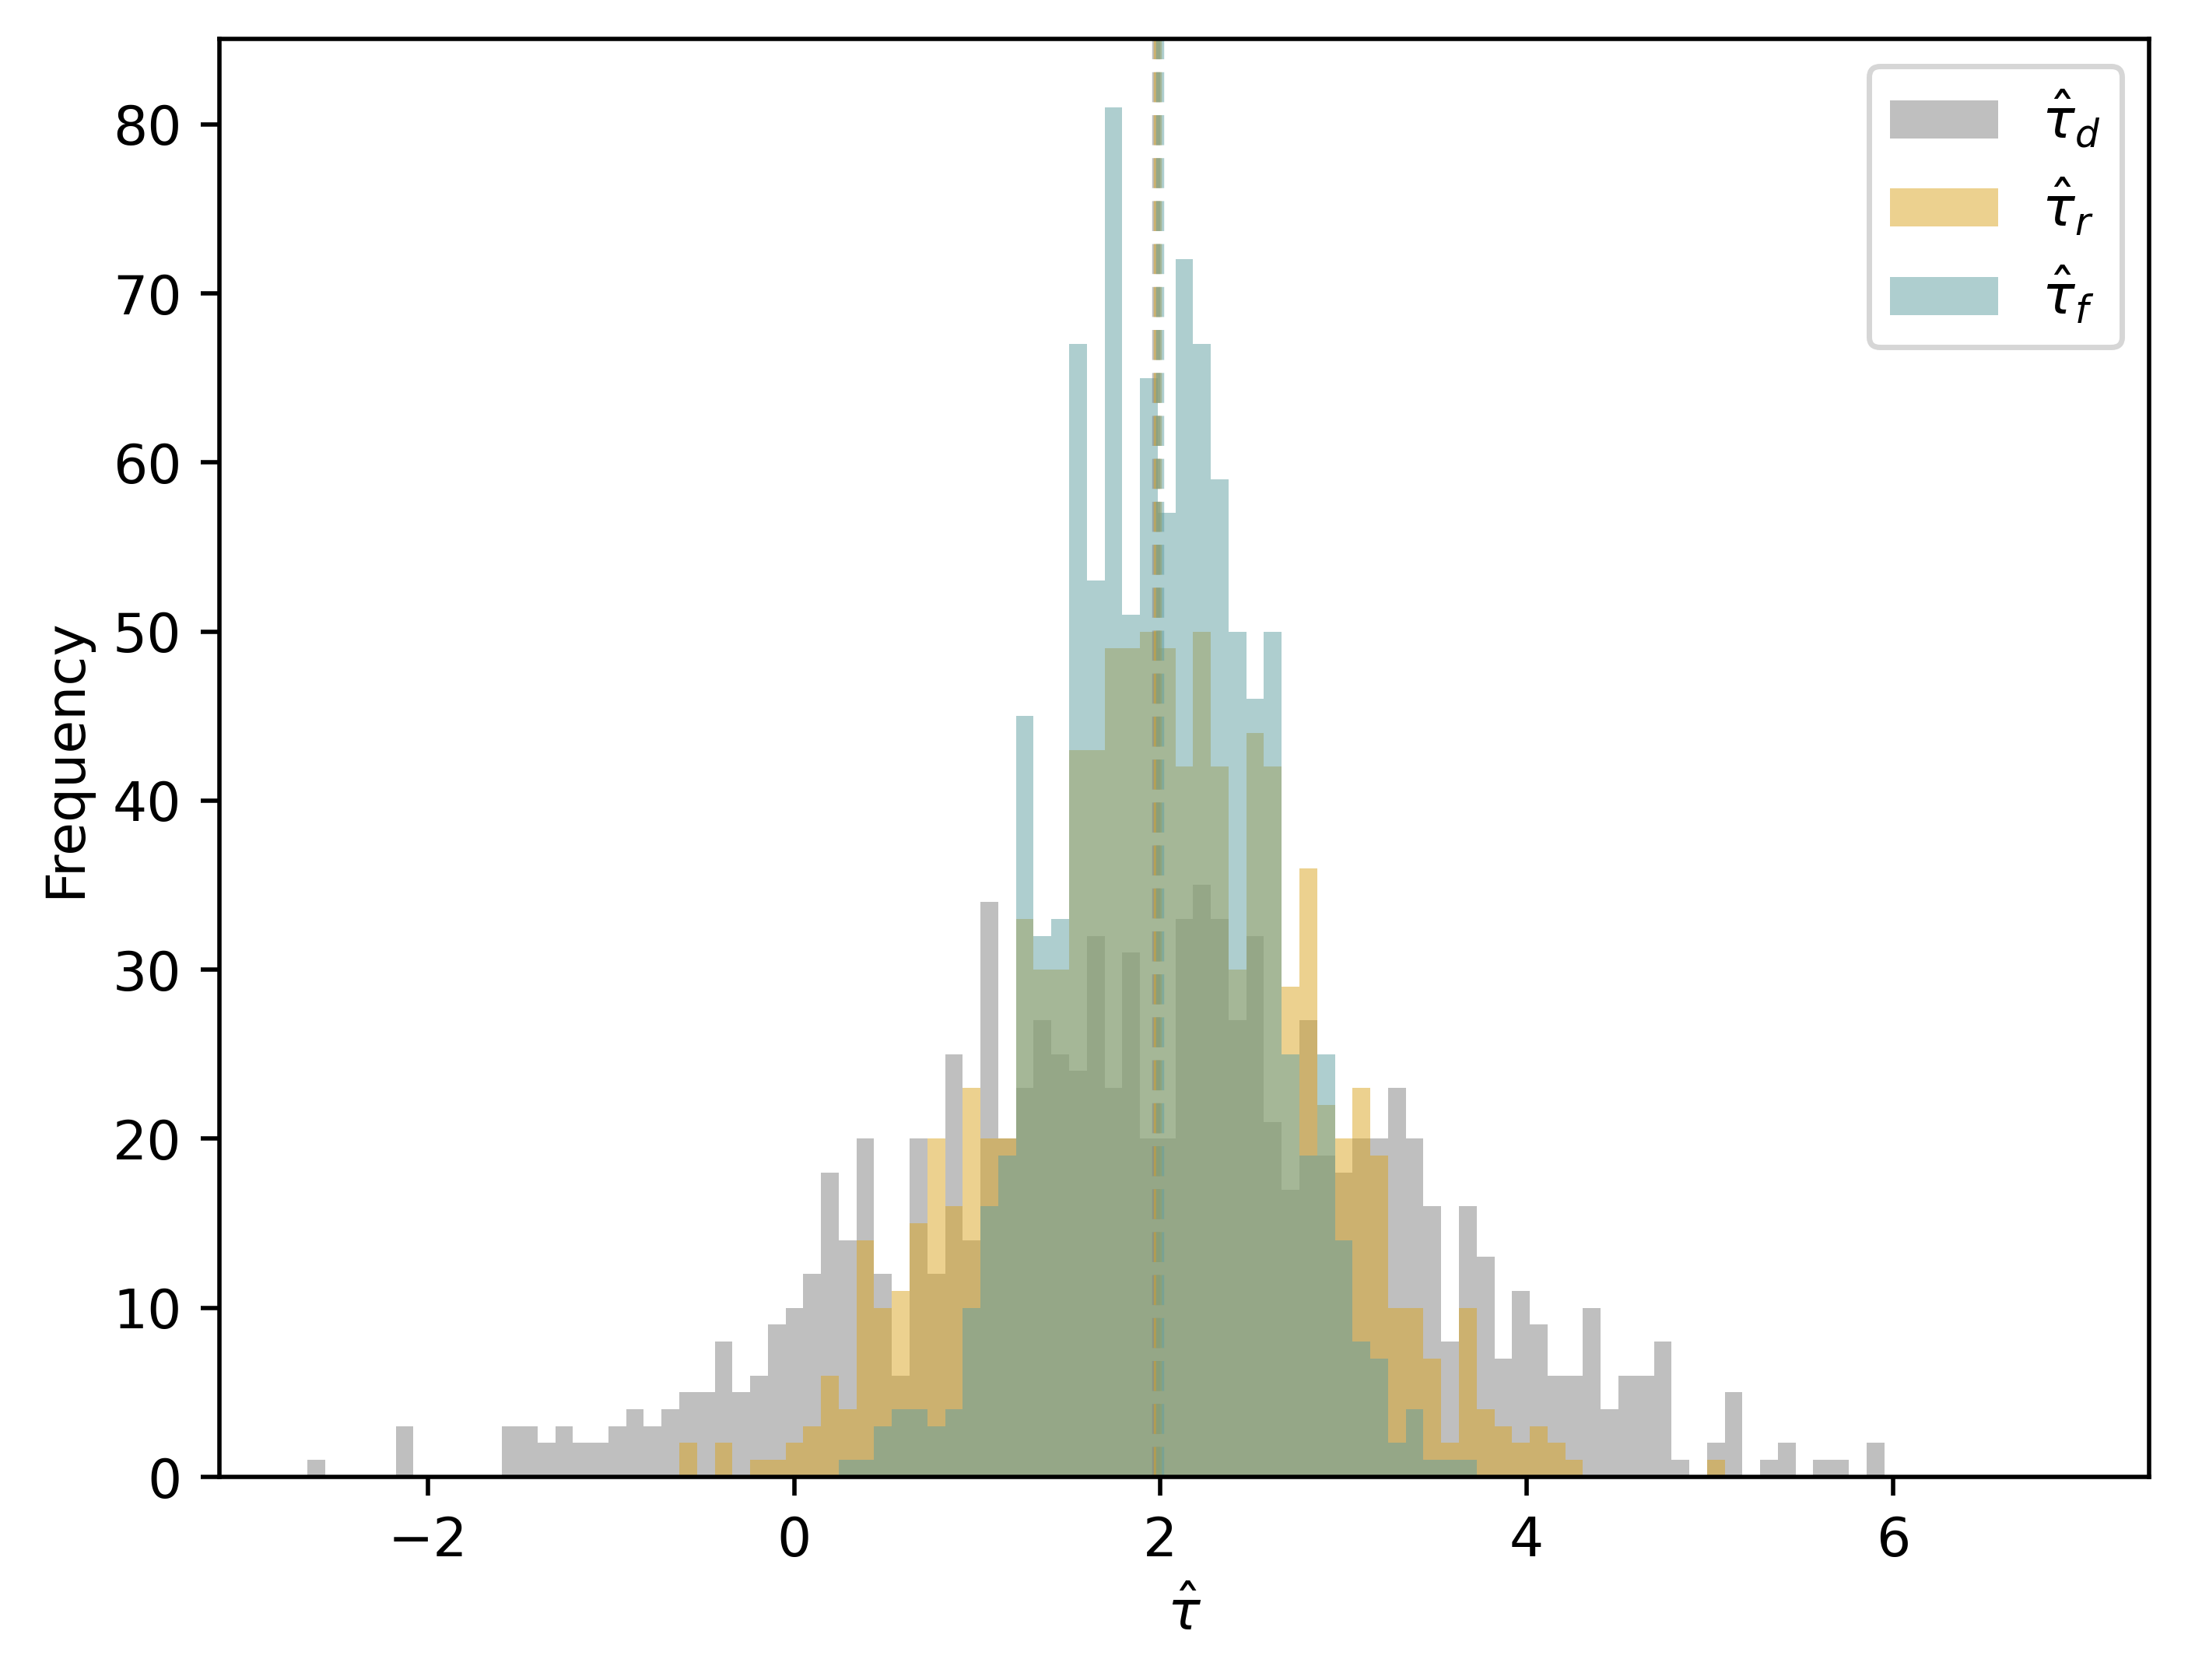

Sample size: 10 ATE_d: 1.9760411207348378 ATE_r: 1.9851764977982755 ATE_ml: 2.0000558956493024


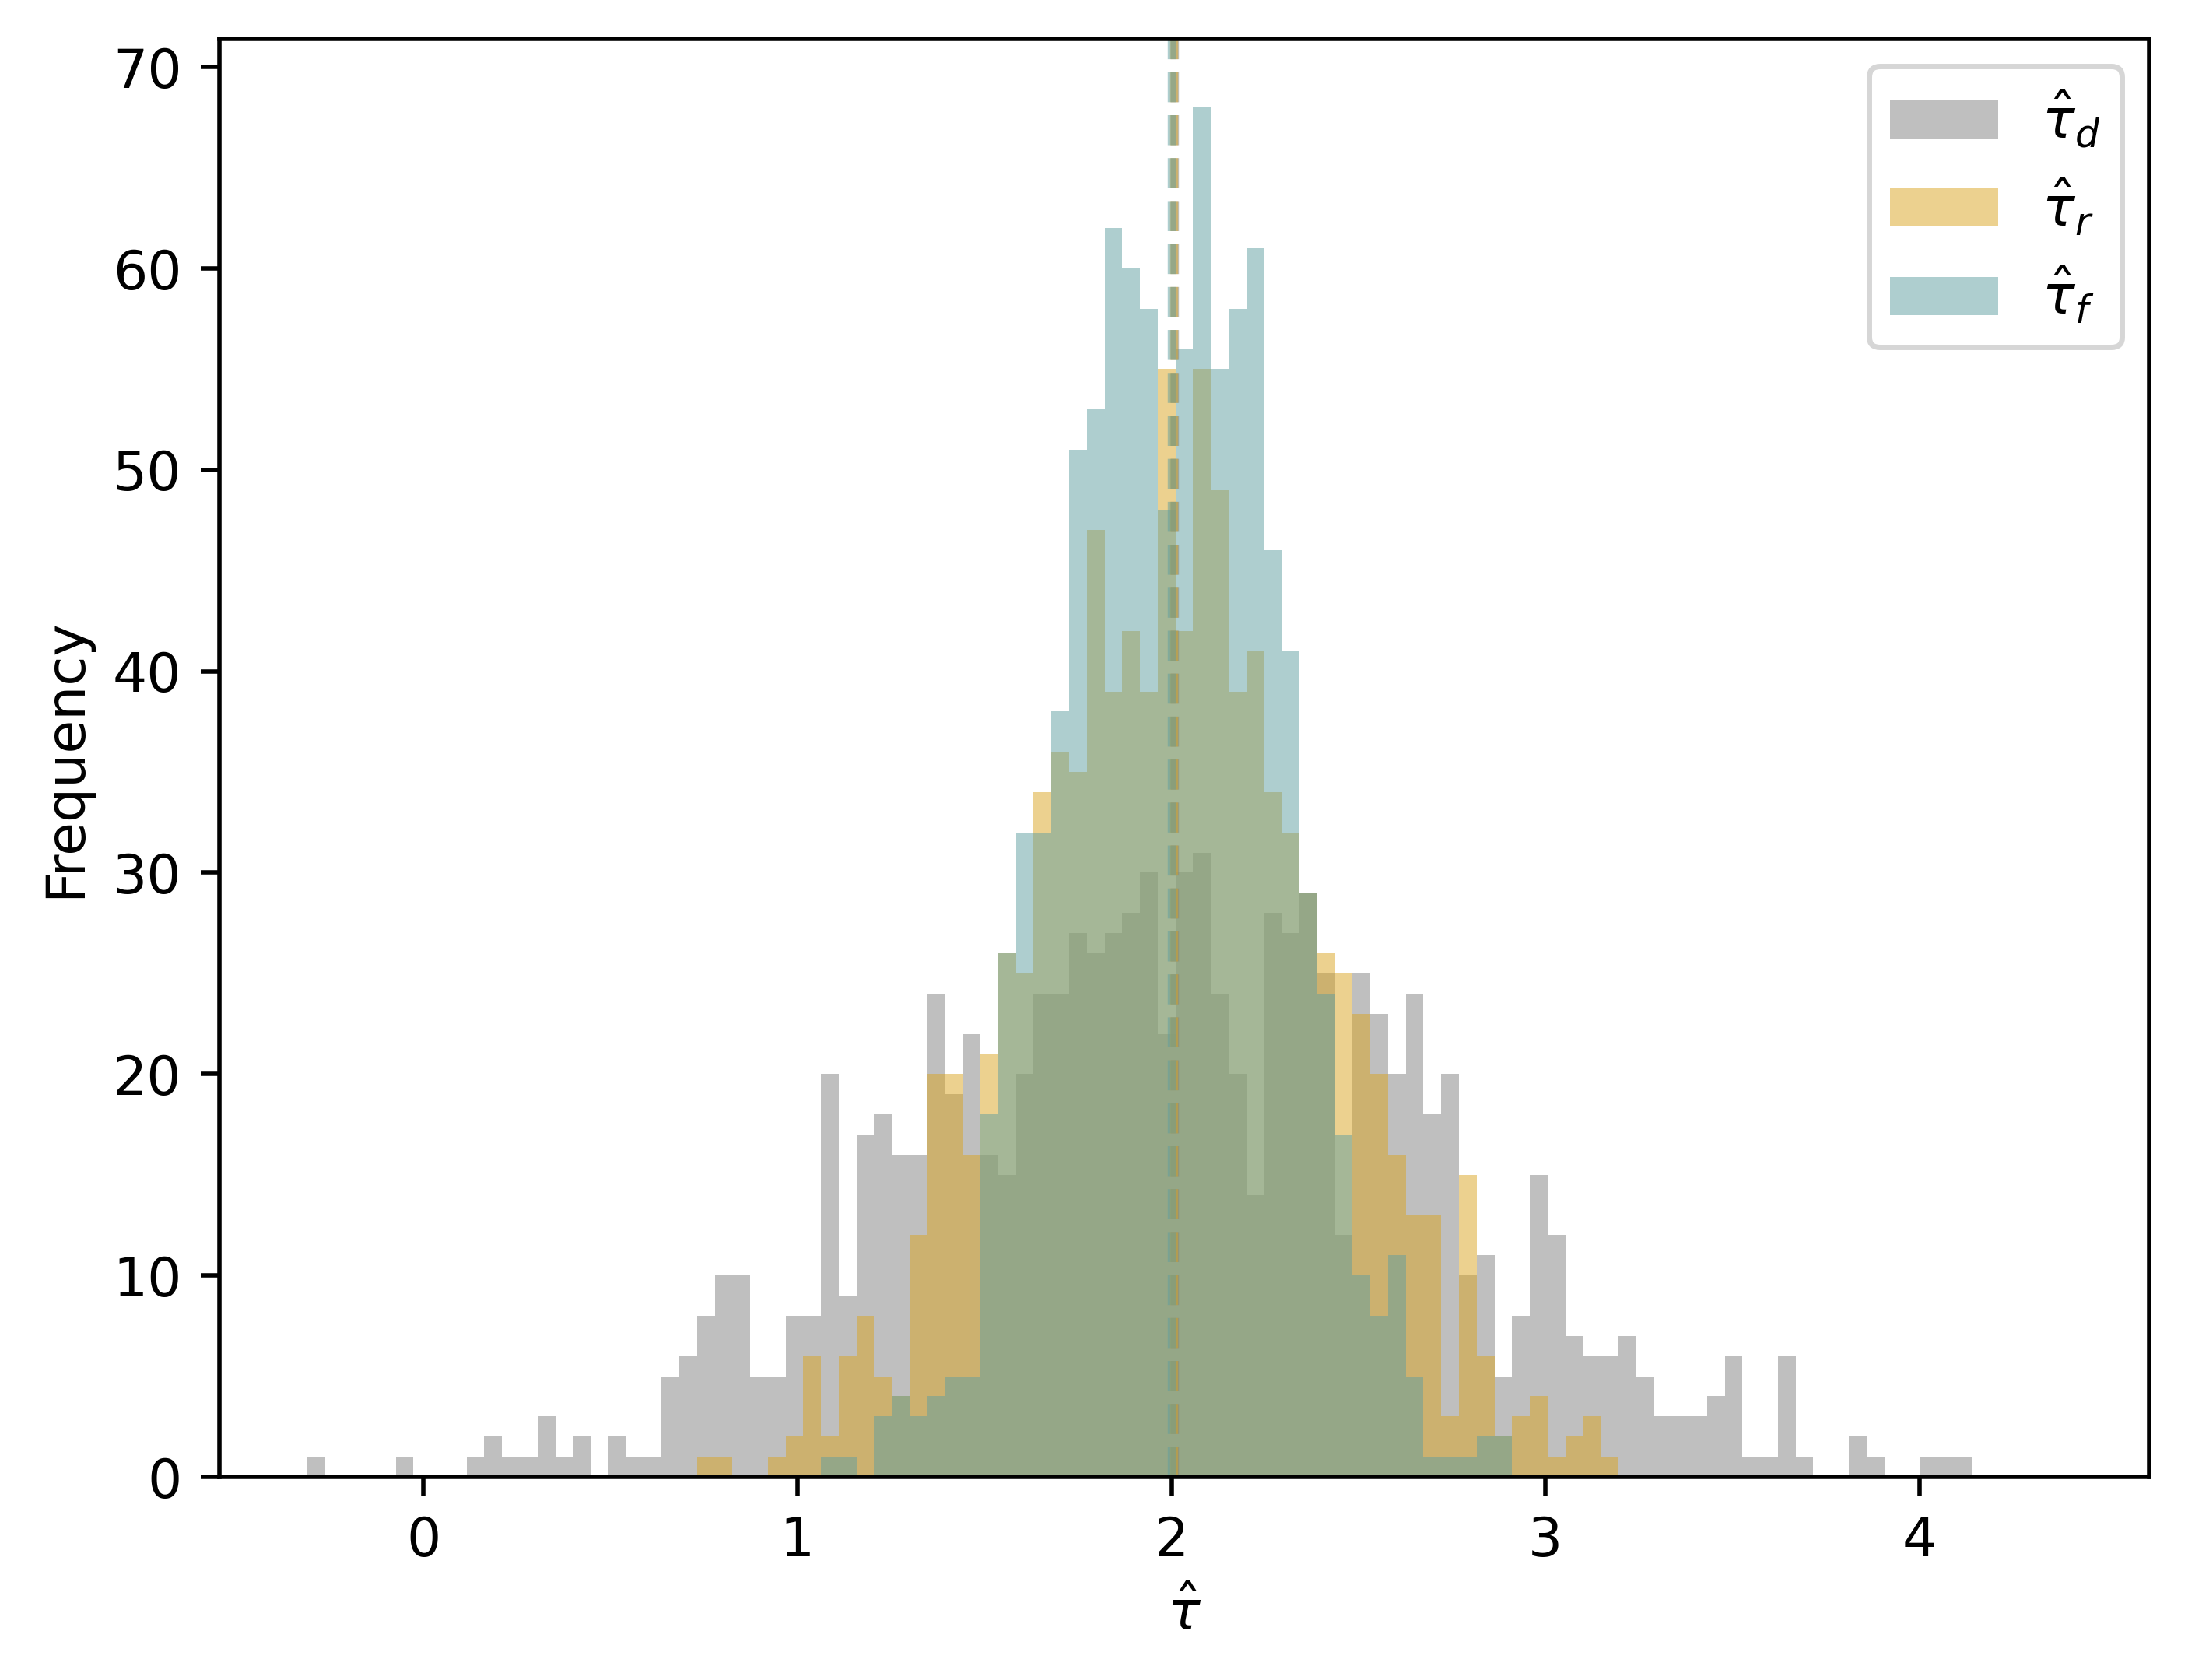

Sample size: 40 ATE_d: 2.0102915887934354 ATE_r: 2.007336601452813 ATE_ml: 2.0016023508930023


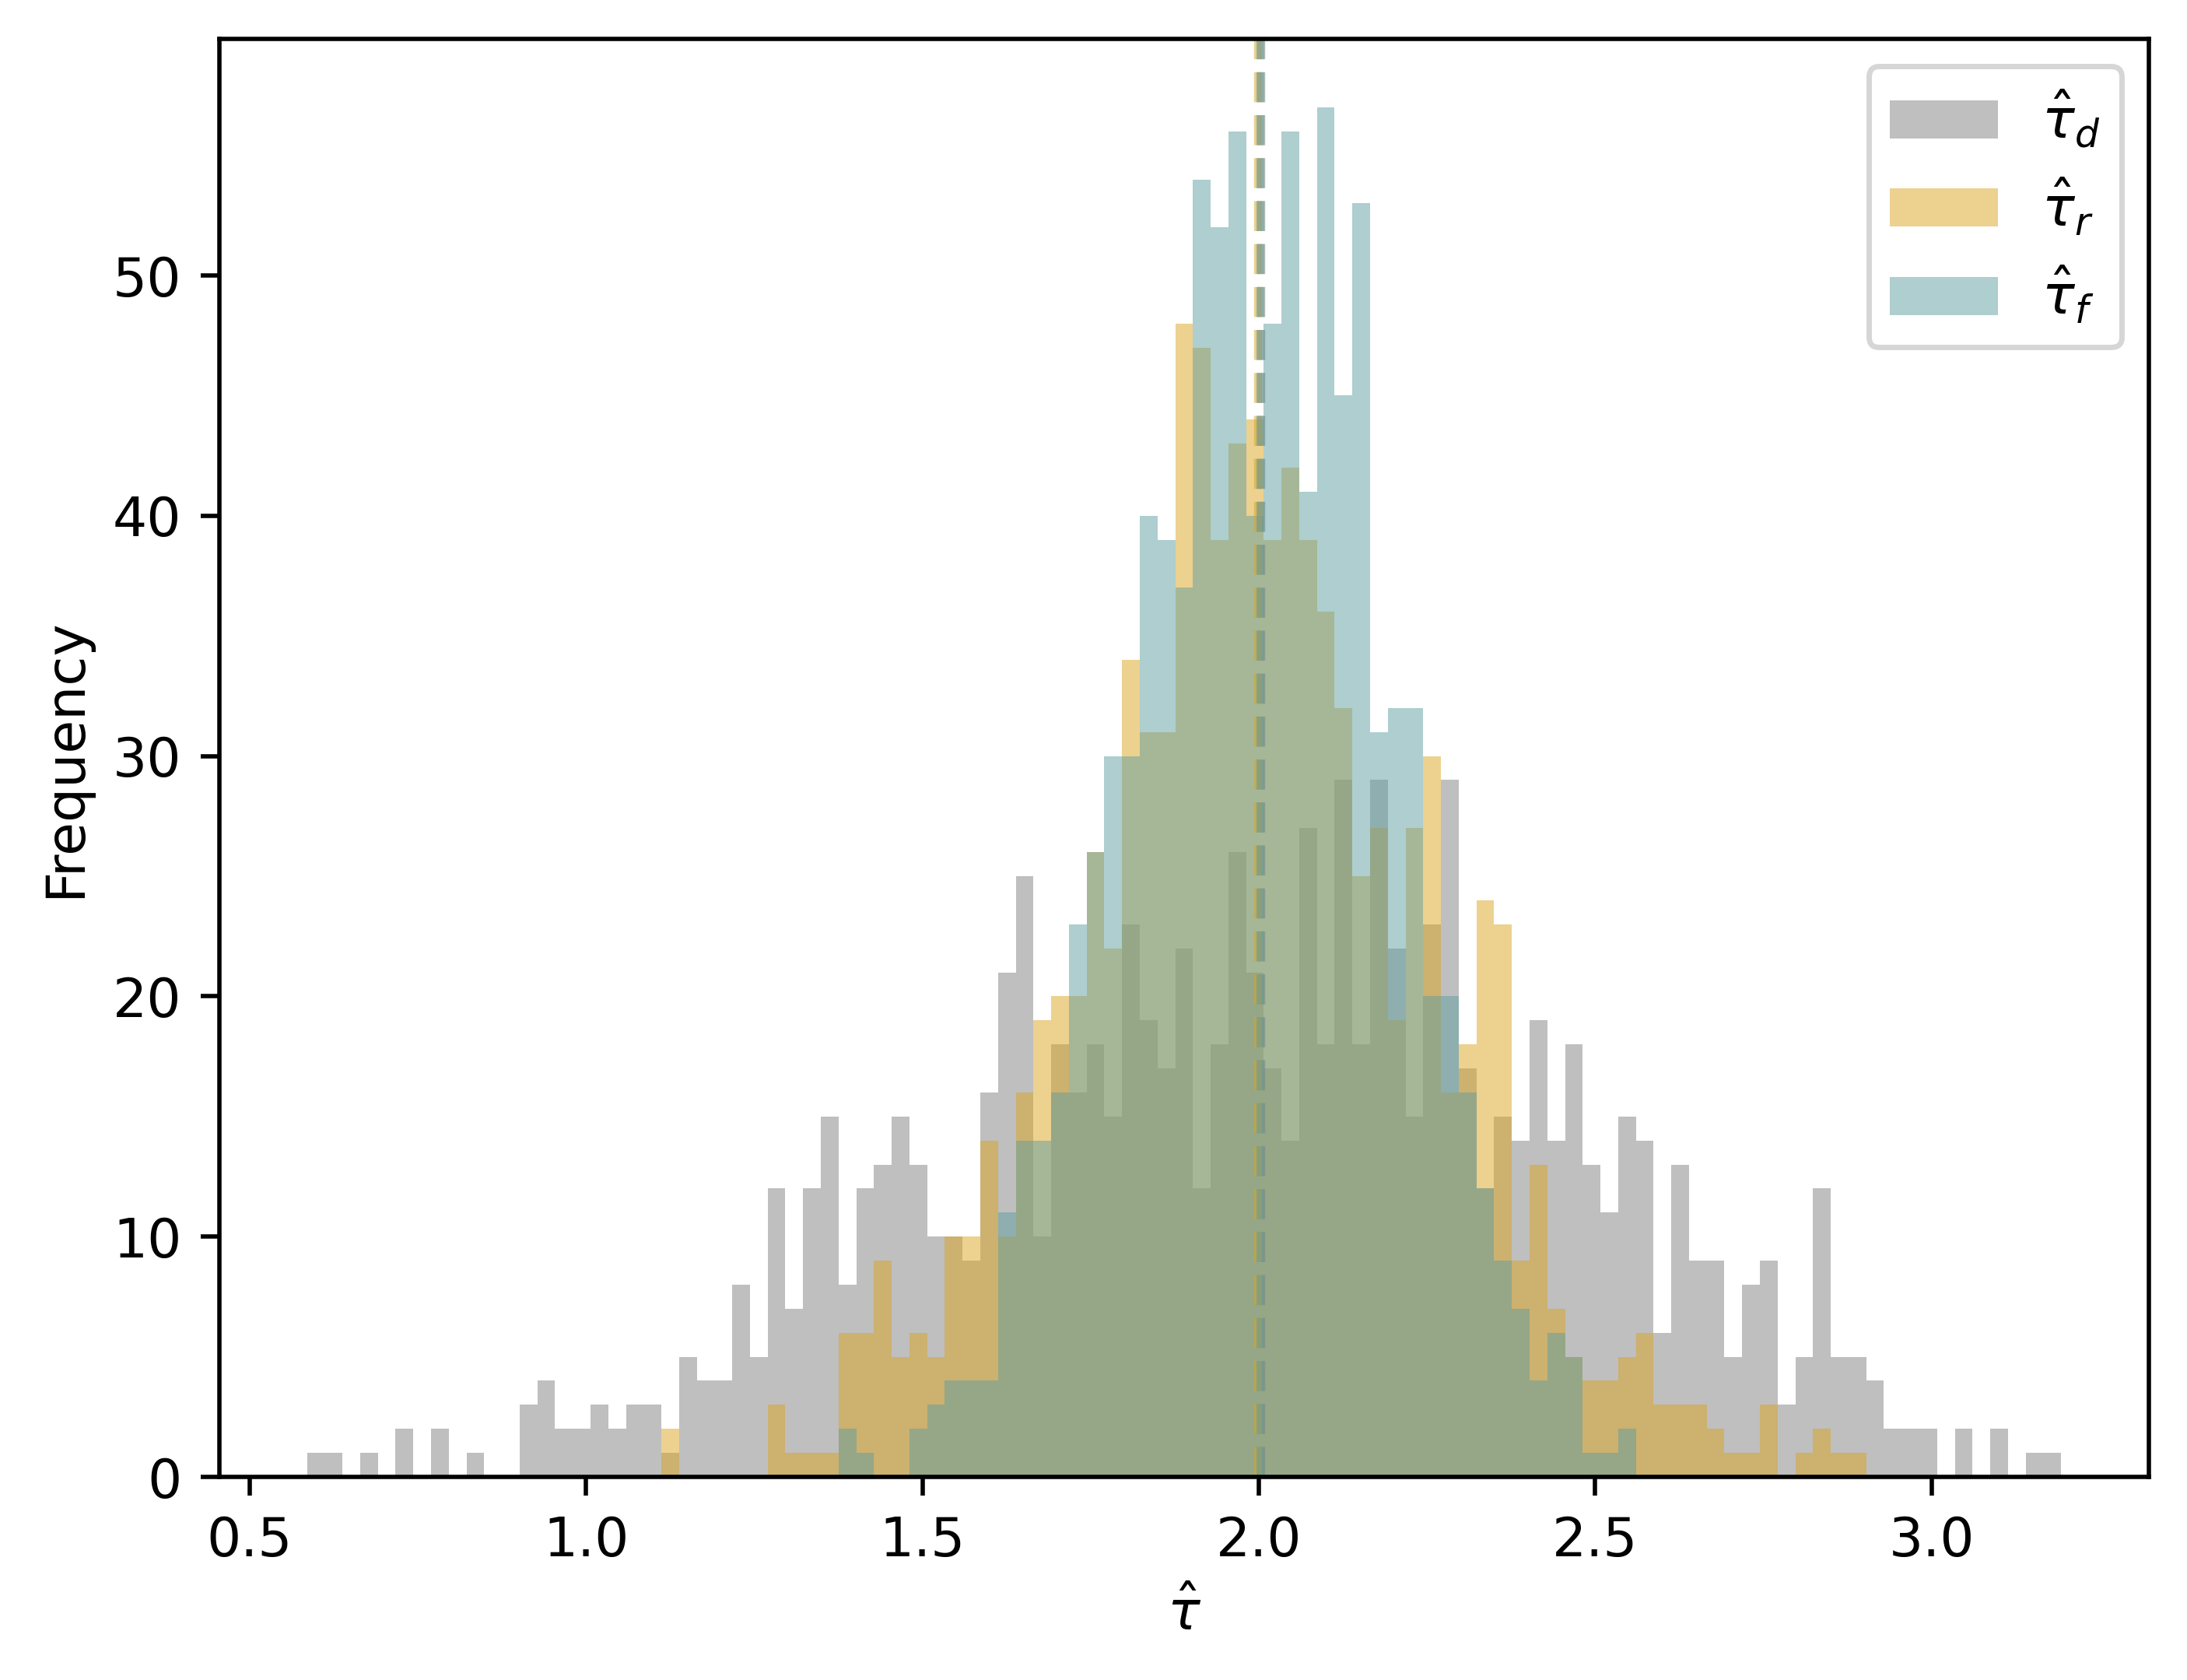

Sample size: 80 ATE_d: 2.003297441806425 ATE_r: 1.9983995110735167 ATE_ml: 2.002055681882991


In [10]:
for key in res:
    plt.figure(dpi=dpi)
    sim_res = res[key]
    # use this to first determine overall range, and manually set max and min with visual analysis
    bins_max = max(max(sim_res['two_est']),max(sim_res['reg_est']),max(sim_res['ml_est']))
    bins_min = min(min(sim_res['two_est']),min(sim_res['reg_est']),min(sim_res['ml_est']))
    #bins_max = 7
    #bins_min = -3
    bins_freq = 100
    bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
    plt.hist(sim_res['two_est'], bins = bins_range, color = colors['two'], label = r"$\hat{\tau}_d$", alpha=0.5)
    plt.hist(sim_res['reg_est'], bins = bins_range, color = colors['reg'], label=r"$\hat{\tau}_r$",alpha=0.5)
    plt.hist(sim_res['ml_est'], bins = bins_range, color = colors['ml'], label=r"$\hat{\tau}_{f}$",alpha=0.5)
    #plt.hist(sim_res['pair_est2'],bins=np.arange(-1,6,0.1), label='paired_est2',alpha=0.5)
    plt.axvline(np.mean(sim_res['two_est']), color = colors['two'], linestyle='--',alpha=0.5)
    plt.axvline(np.mean(sim_res['reg_est']), color = colors['reg'], linestyle='--',alpha=0.5)
    plt.axvline(np.mean(sim_res['ml_est']), color = colors['ml'], linestyle='--',alpha=0.5)
    plt.ylabel("Frequency")
    plt.xlabel(r"$\hat{\tau}$")
    plt.legend(loc=1)
    plt.savefig("plots/flex_" + str(key) + "_ate.png")
    plt.show()
    print("Sample size:",sample_sizes[key], "ATE_d:", np.mean(sim_res['two_est']), "ATE_r:", 
          np.mean(sim_res['reg_est']),"ATE_ml:",np.mean(sim_res['ml_est']))

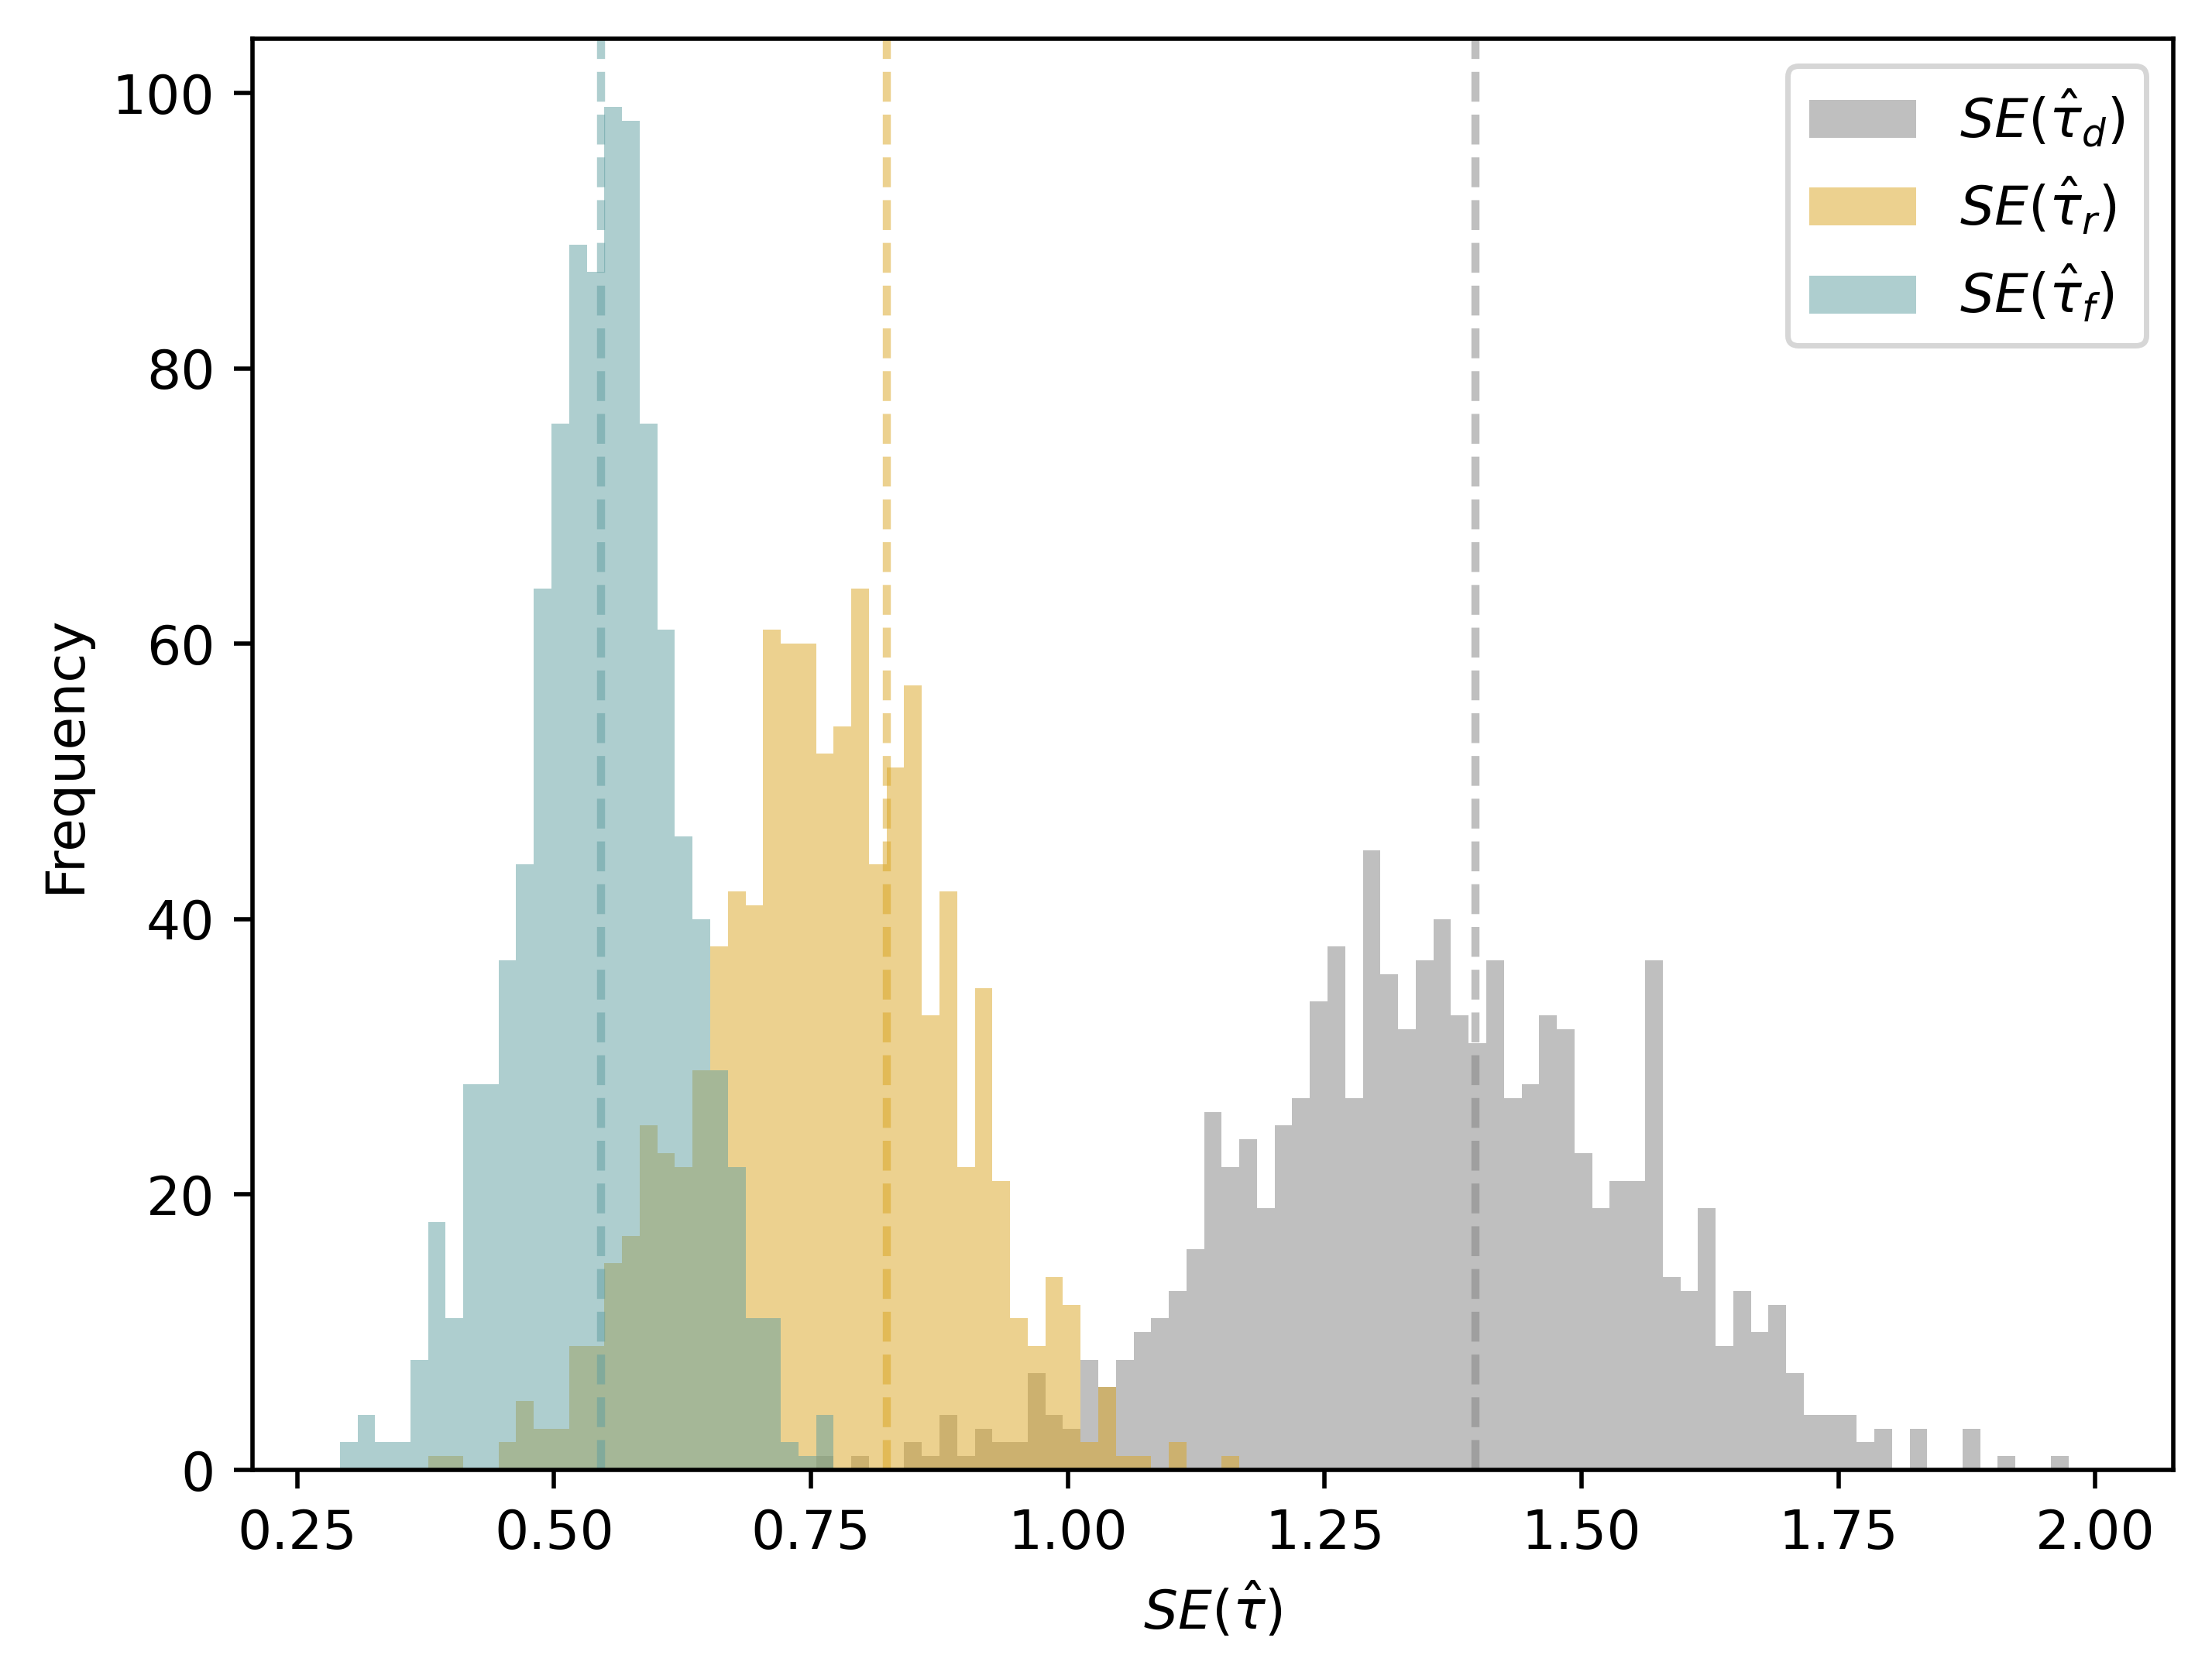

Std_d: 1.3971469144651147 Std_r: 0.8238463668835506 Std_ml:  0.5456381956315185 Var_red: 0.6094625482958524


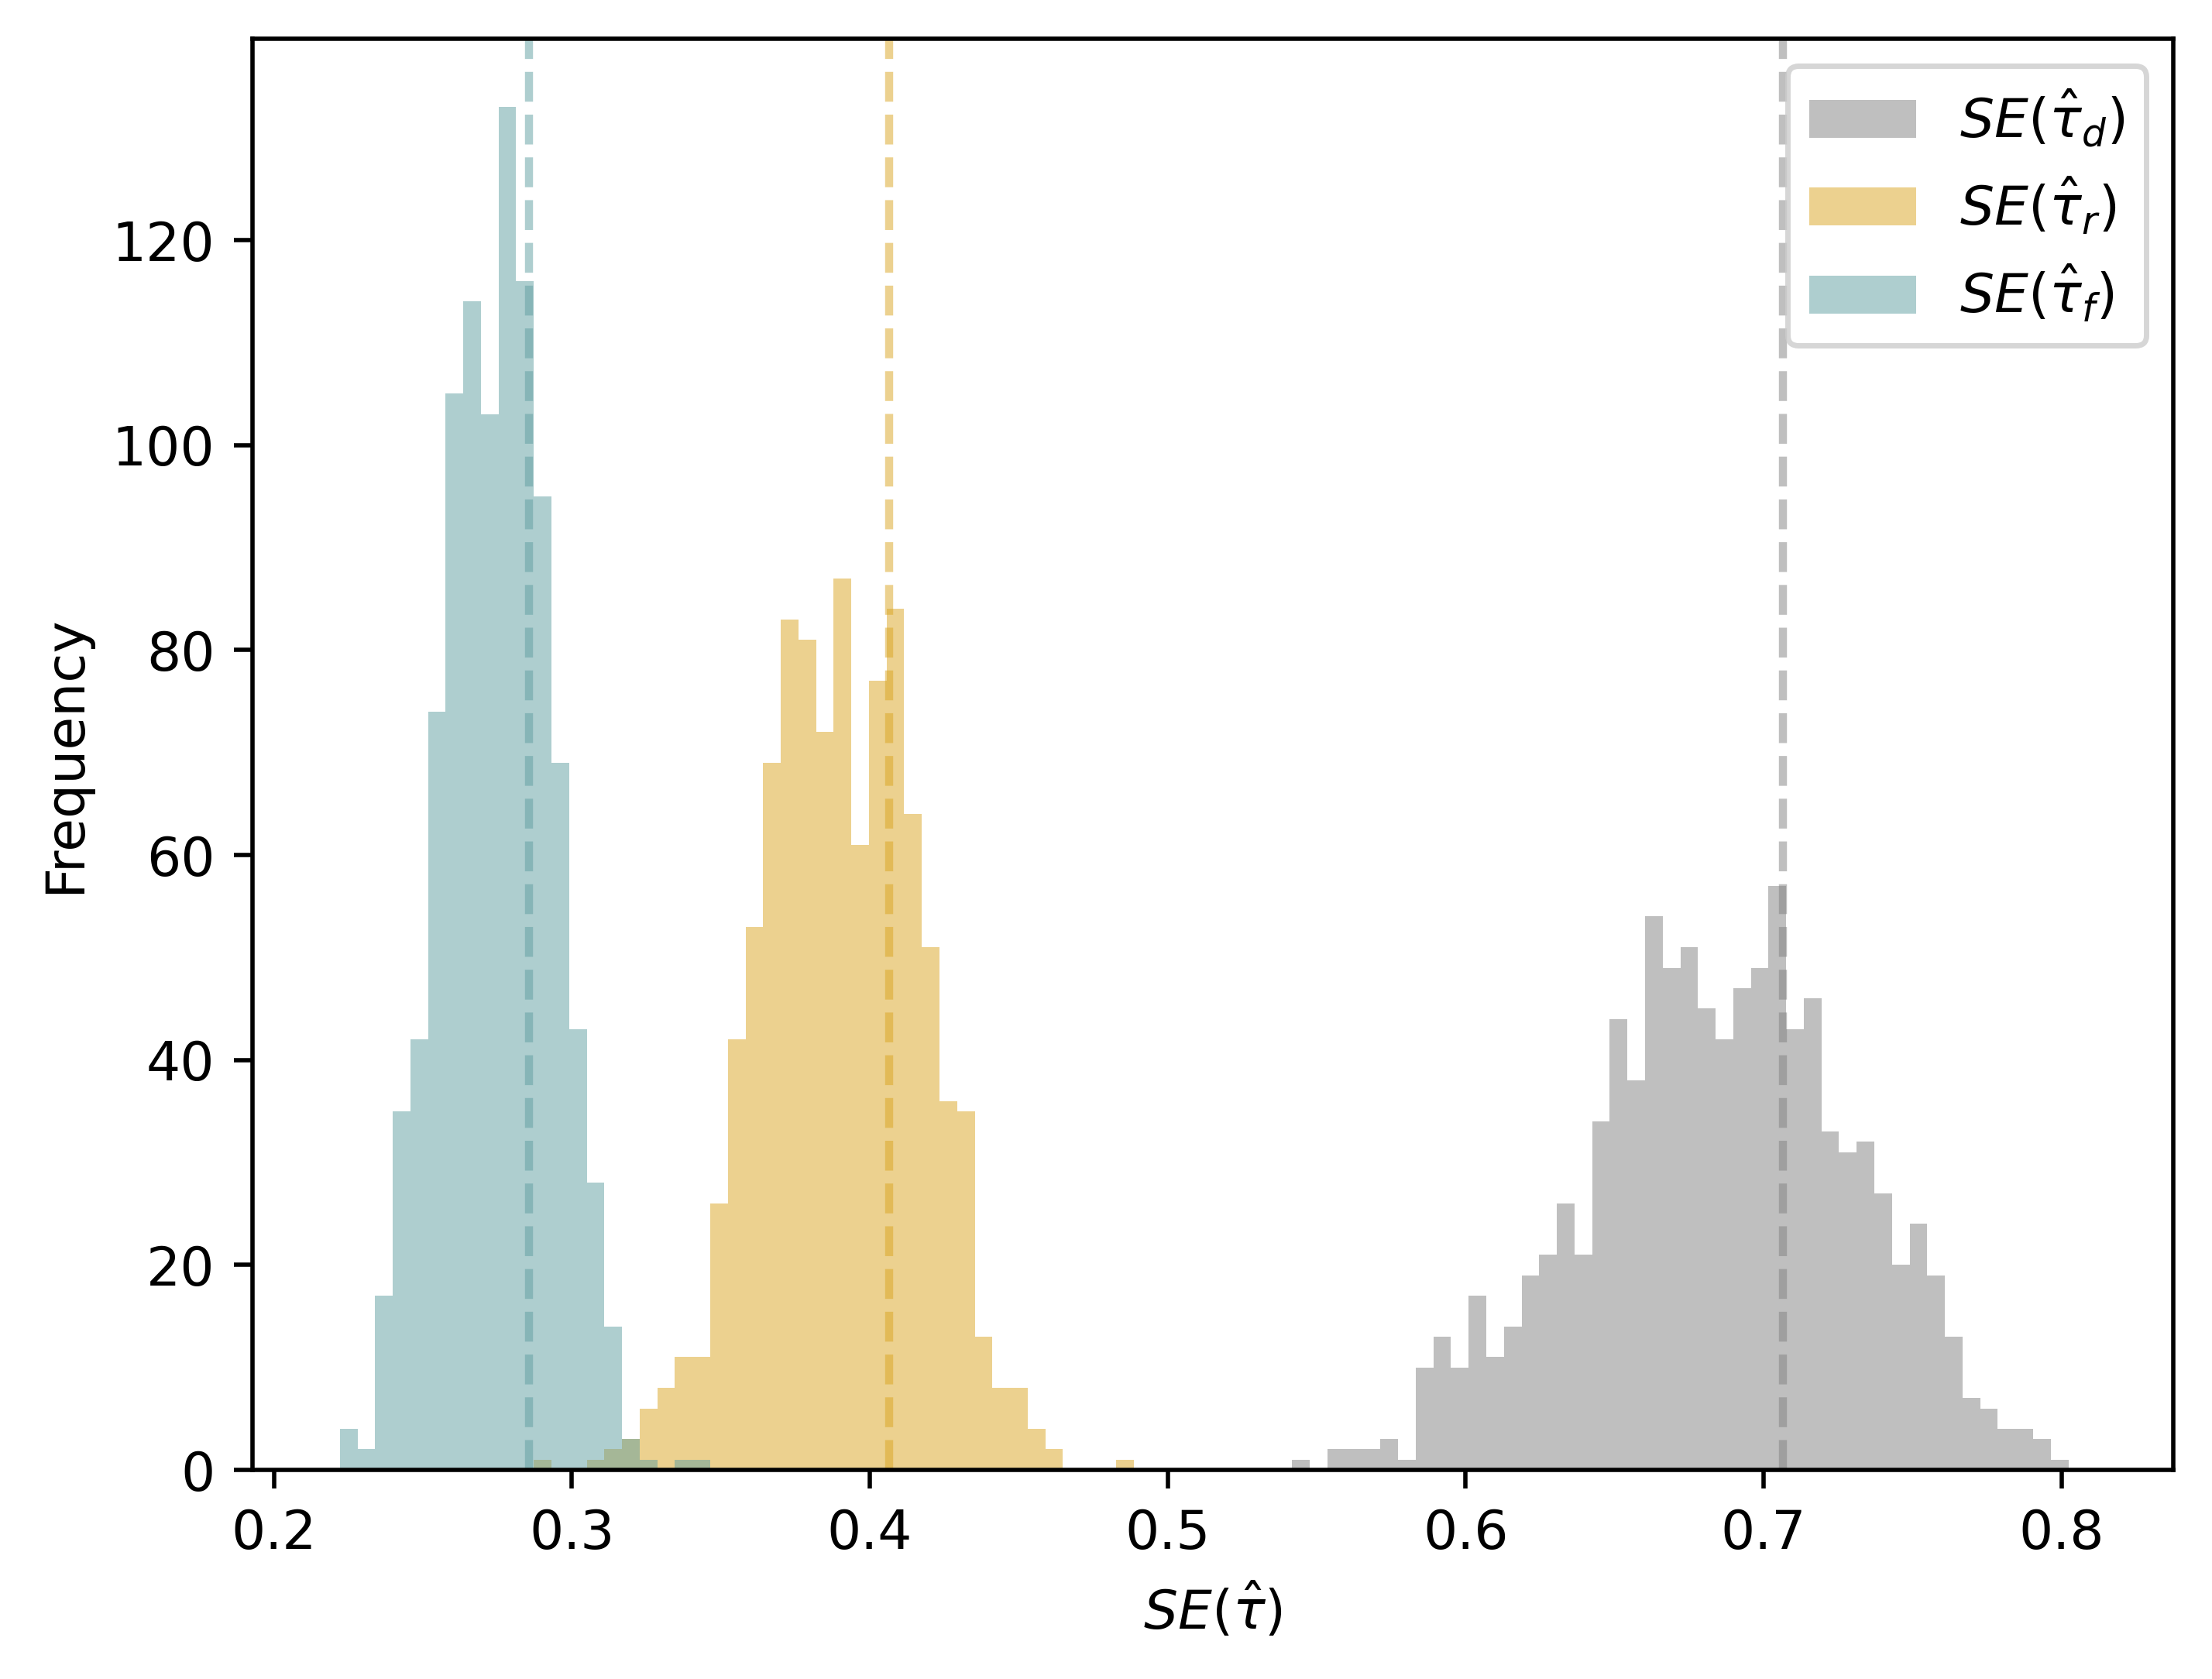

Std_d: 0.7068692647157091 Std_r: 0.40675158400232936 Std_ml:  0.285648496323606 Var_red: 0.5958962843879072


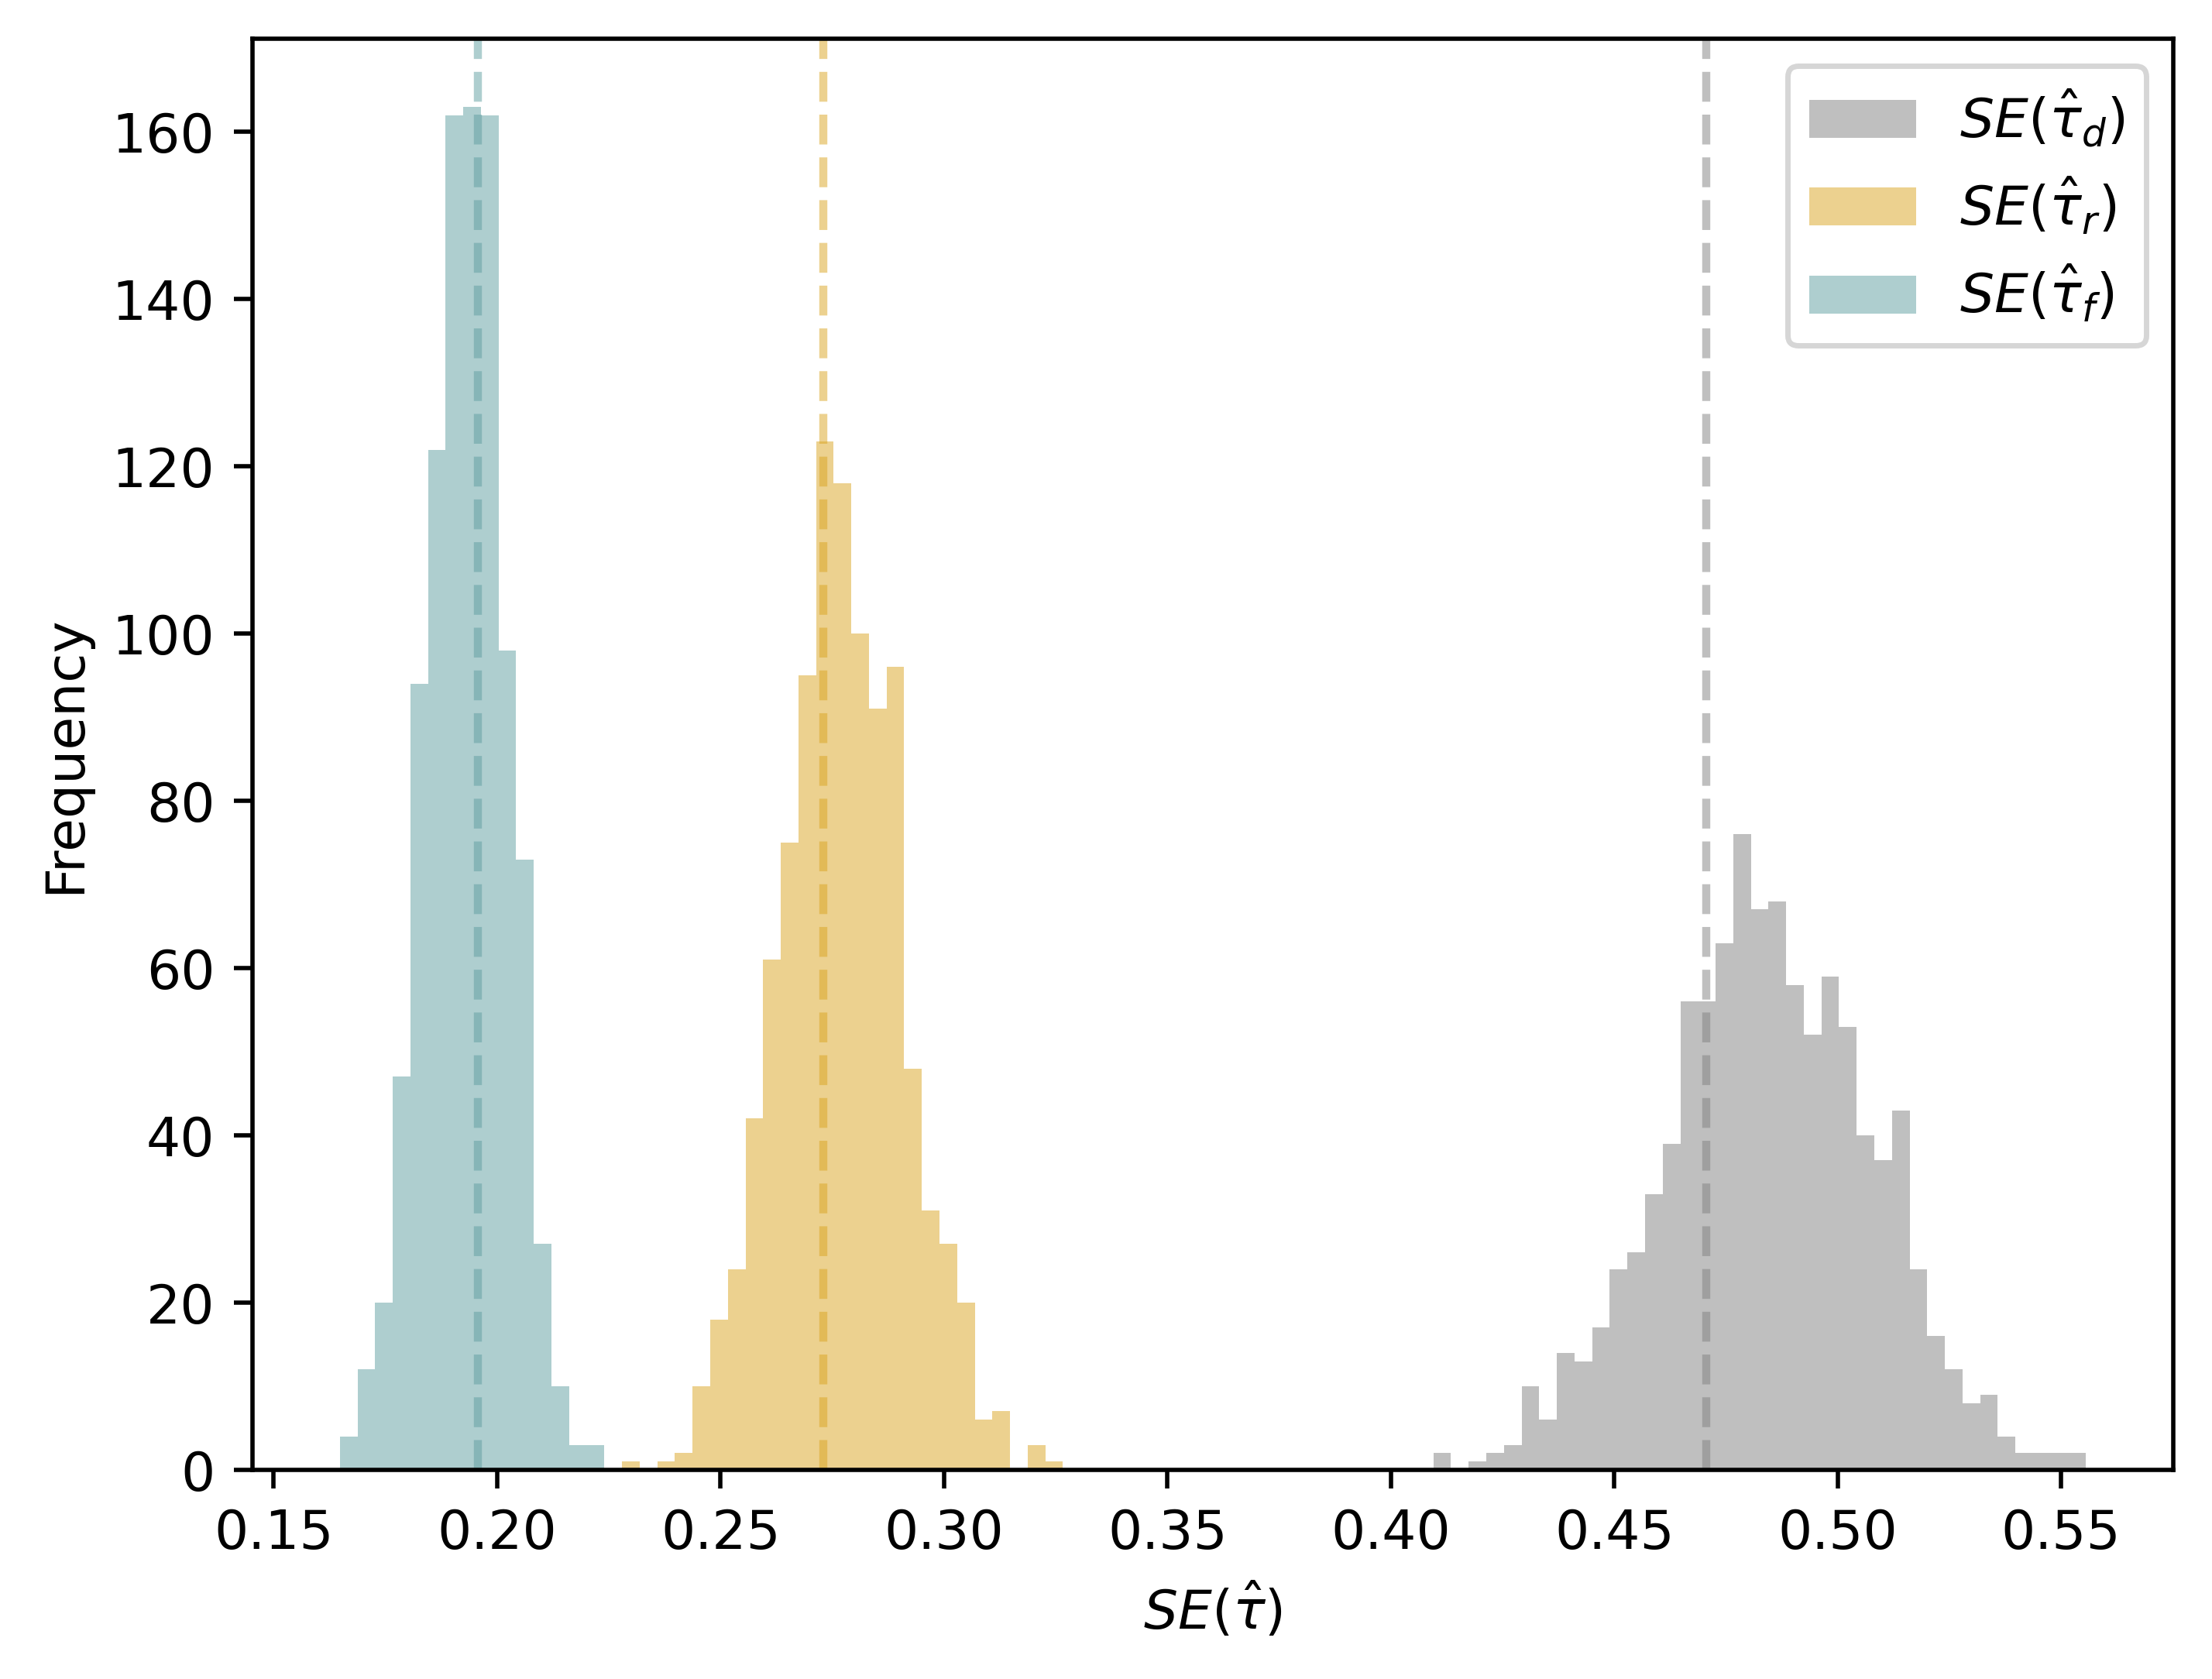

Std_d: 0.4707411297787625 Std_r: 0.27316795929107307 Std_ml:  0.1958011269930984 Var_red: 0.5840577451026631


In [11]:
for key in res:
    plt.figure(dpi=dpi)
    sim_res = res[key]
    # use this to first determine overall range, and manually set max and min with visual analysis
    bins_max = max(max(sim_res['two_se']),max(sim_res['reg_se']),max(sim_res['ml_se']))
    bins_min = min(min(sim_res['two_se']),min(sim_res['reg_se']),min(sim_res['ml_se']))
    #bins_max = 2
    #bins_min = 0.25
    bins_freq = 100
    bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
    plt.hist(sim_res['two_se'], bins = bins_range, color = colors['two'], label = r"$SE(\hat{\tau}_d)$", alpha=0.5)
    plt.hist(sim_res['reg_se'], bins = bins_range, color = colors['reg'], label=r"$SE(\hat{\tau}_r)$",alpha=0.5)
    plt.hist(sim_res['ml_se'], bins = bins_range, color = colors['ml'], label=r"$SE(\hat{\tau}_{f})$",alpha=0.5)
    plt.axvline(np.std(sim_res['two_est']), color = colors['two'], linestyle='--',alpha=0.5)
    plt.axvline(np.std(sim_res['reg_est']), color = colors['reg'], linestyle='--',alpha=0.5)
    plt.axvline(np.std(sim_res['ml_est']), color = colors['ml'], linestyle='--',alpha=0.5)
    plt.ylabel("Frequency")
    plt.xlabel(r"$SE(\hat{\tau})$")
    plt.legend(loc=1)
    plt.savefig("plots/flex_" + str(key) + "_se.png")
    plt.show()
    print("Std_d:", np.std(sim_res['two_est'],ddof=1), "Std_r:", np.std(sim_res['reg_est'],ddof=1), "Std_ml: ", np.std(sim_res['ml_est'],ddof=1),
          "Var_red:", 1-np.std(sim_res['ml_est'],ddof=1)/np.std(sim_res['two_est'],ddof=1))

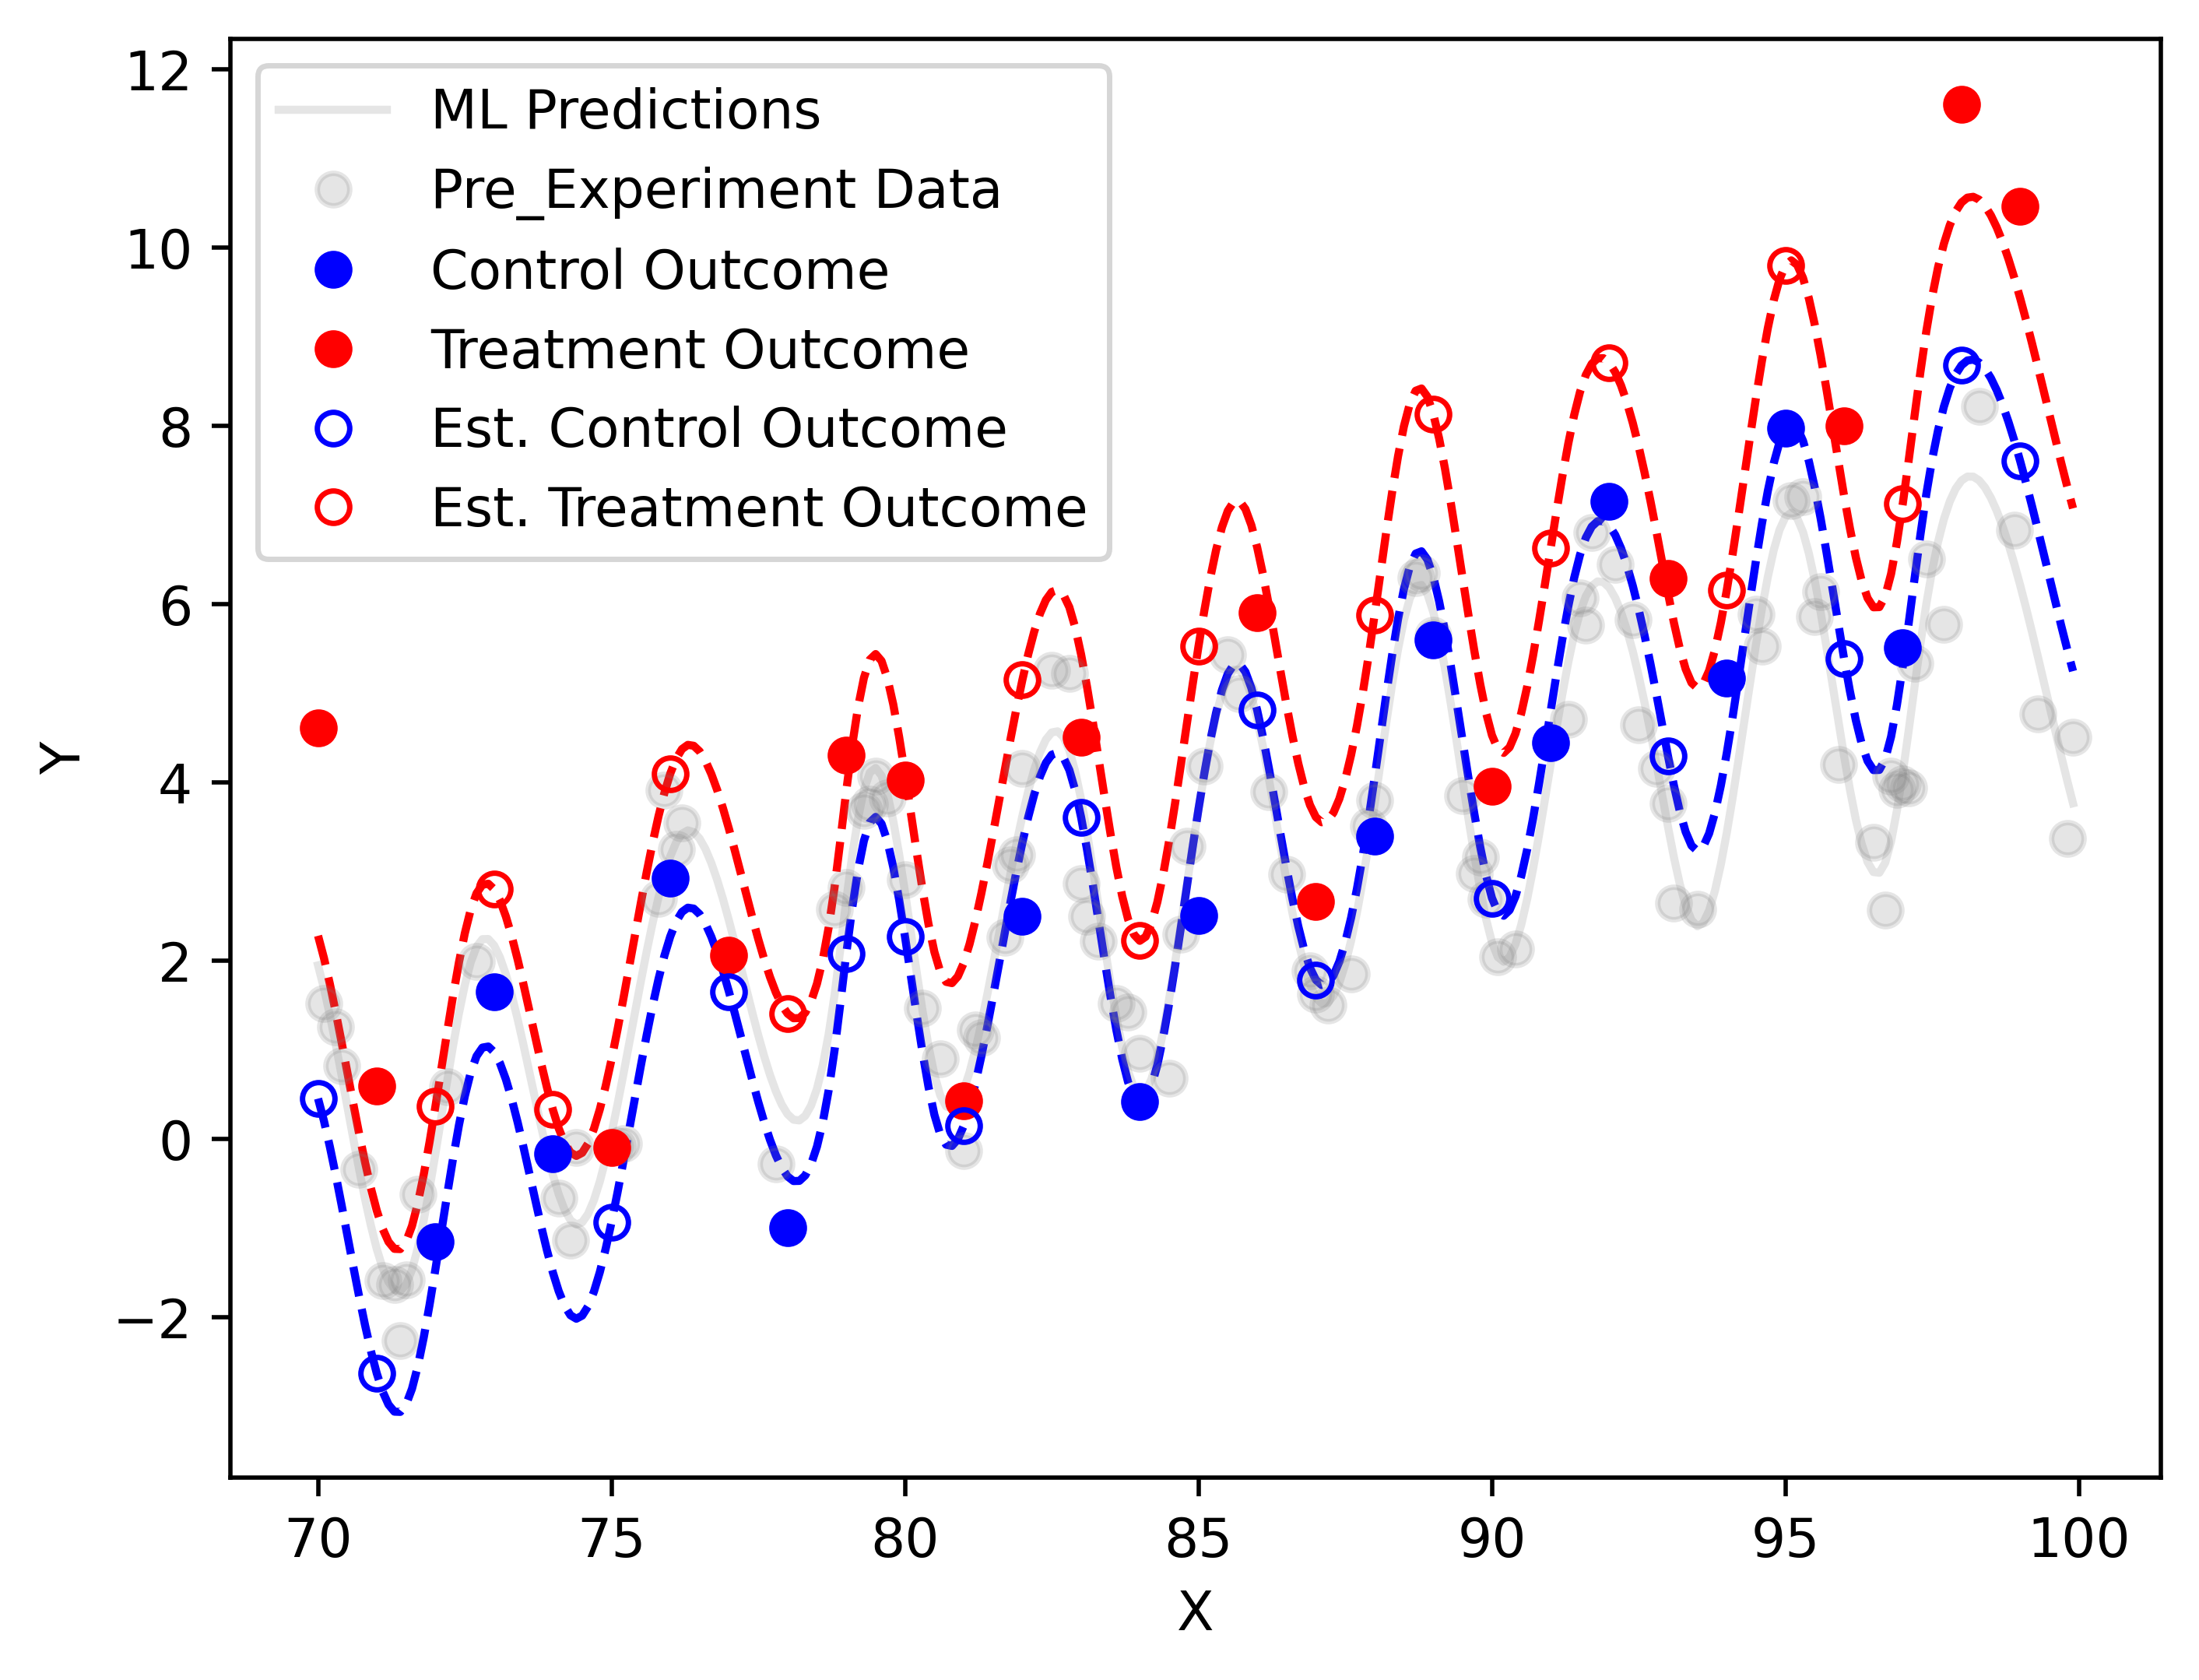

ATE:  1.8268526177809337 SE:  0.336892981581593


In [12]:
# use the same control/treatment data as the linear model example
plt.figure(dpi=dpi)
np.random.seed(1)
random.seed(1)
x = np.arange(70,100,1)
n = len(x)
error = np.random.normal(0,1,n)
def exp_data(x):
    return 2*np.sin(x*2) + 0.01*((x - 70)**2) + 0.4*error
y = exp_data(x)
te = 2
control_idx = random.sample(range(n),n//2)
treat_idx = list(set(range(n)).difference(control_idx))
control_idx.sort()
treat_idx.sort()
control_x = x[control_idx]
treat_x = x[treat_idx]
control_y = y[control_idx]
treat_y = y[treat_idx] + te
treat_pred = BSpline(*tck)(treat_x)
control_pred = BSpline(*tck)(control_x)

treatxvar = np.var(treat_x)
controlxvar = np.var(control_x)
control_r = control_y - control_pred
treat_r = treat_y - treat_pred
treatxcov = np.cov(treat_x, treat_r)[0,1]
controlxcov = np.cov(control_x, control_r)[0,1]
beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
alpha1 = np.mean(treat_r) - np.mean(treat_x)*beta
alpha0 = np.mean(control_r) - np.mean(control_x)*beta

x = np.arange(70,100,0.1)
treatline = BSpline(*tck)(x) + alpha1 + x * beta
controlline = BSpline(*tck)(x) + alpha0 + x * beta
plt.plot(x,treatline, color='red',linestyle='--')
plt.plot(x,controlline, color='blue',linestyle='--')
plt.plot(x,BSpline(*tck)(x), label = 'ML Predictions',color='grey',alpha=0.2)
plt.plot(x_pre, y_pre, 'o',color='grey',label="Pre_Experiment Data",alpha=0.2)
plt.plot(control_x, control_y, 'o', color = 'blue', label='Control Outcome')
plt.plot(treat_x, treat_y, 'o', color = 'red', label = 'Treatment Outcome')
plt.plot(treat_x, alpha0 + treat_x * beta + BSpline(*tck)(treat_x),'o',fillstyle='none',color='blue',label='Est. Control Outcome')
plt.plot(control_x, alpha1 + control_x * beta + BSpline(*tck)(control_x),'o',fillstyle='none',color='red',label='Est. Treatment Outcome')
plt.ylabel("Y")
plt.xlabel("X")
plt.legend(loc=2)
plt.savefig("plots/sec_cf.png")
plt.show()
ATE = alpha1 - alpha0
SE = (np.var(treat_y - BSpline(*tck)(treat_x) - treat_x * beta)/len(treat_y) + np.var(control_y - BSpline(*tck)(control_x) - control_x * beta)/len(control_y))**0.5
print("ATE: ", ATE, "SE: ", SE)

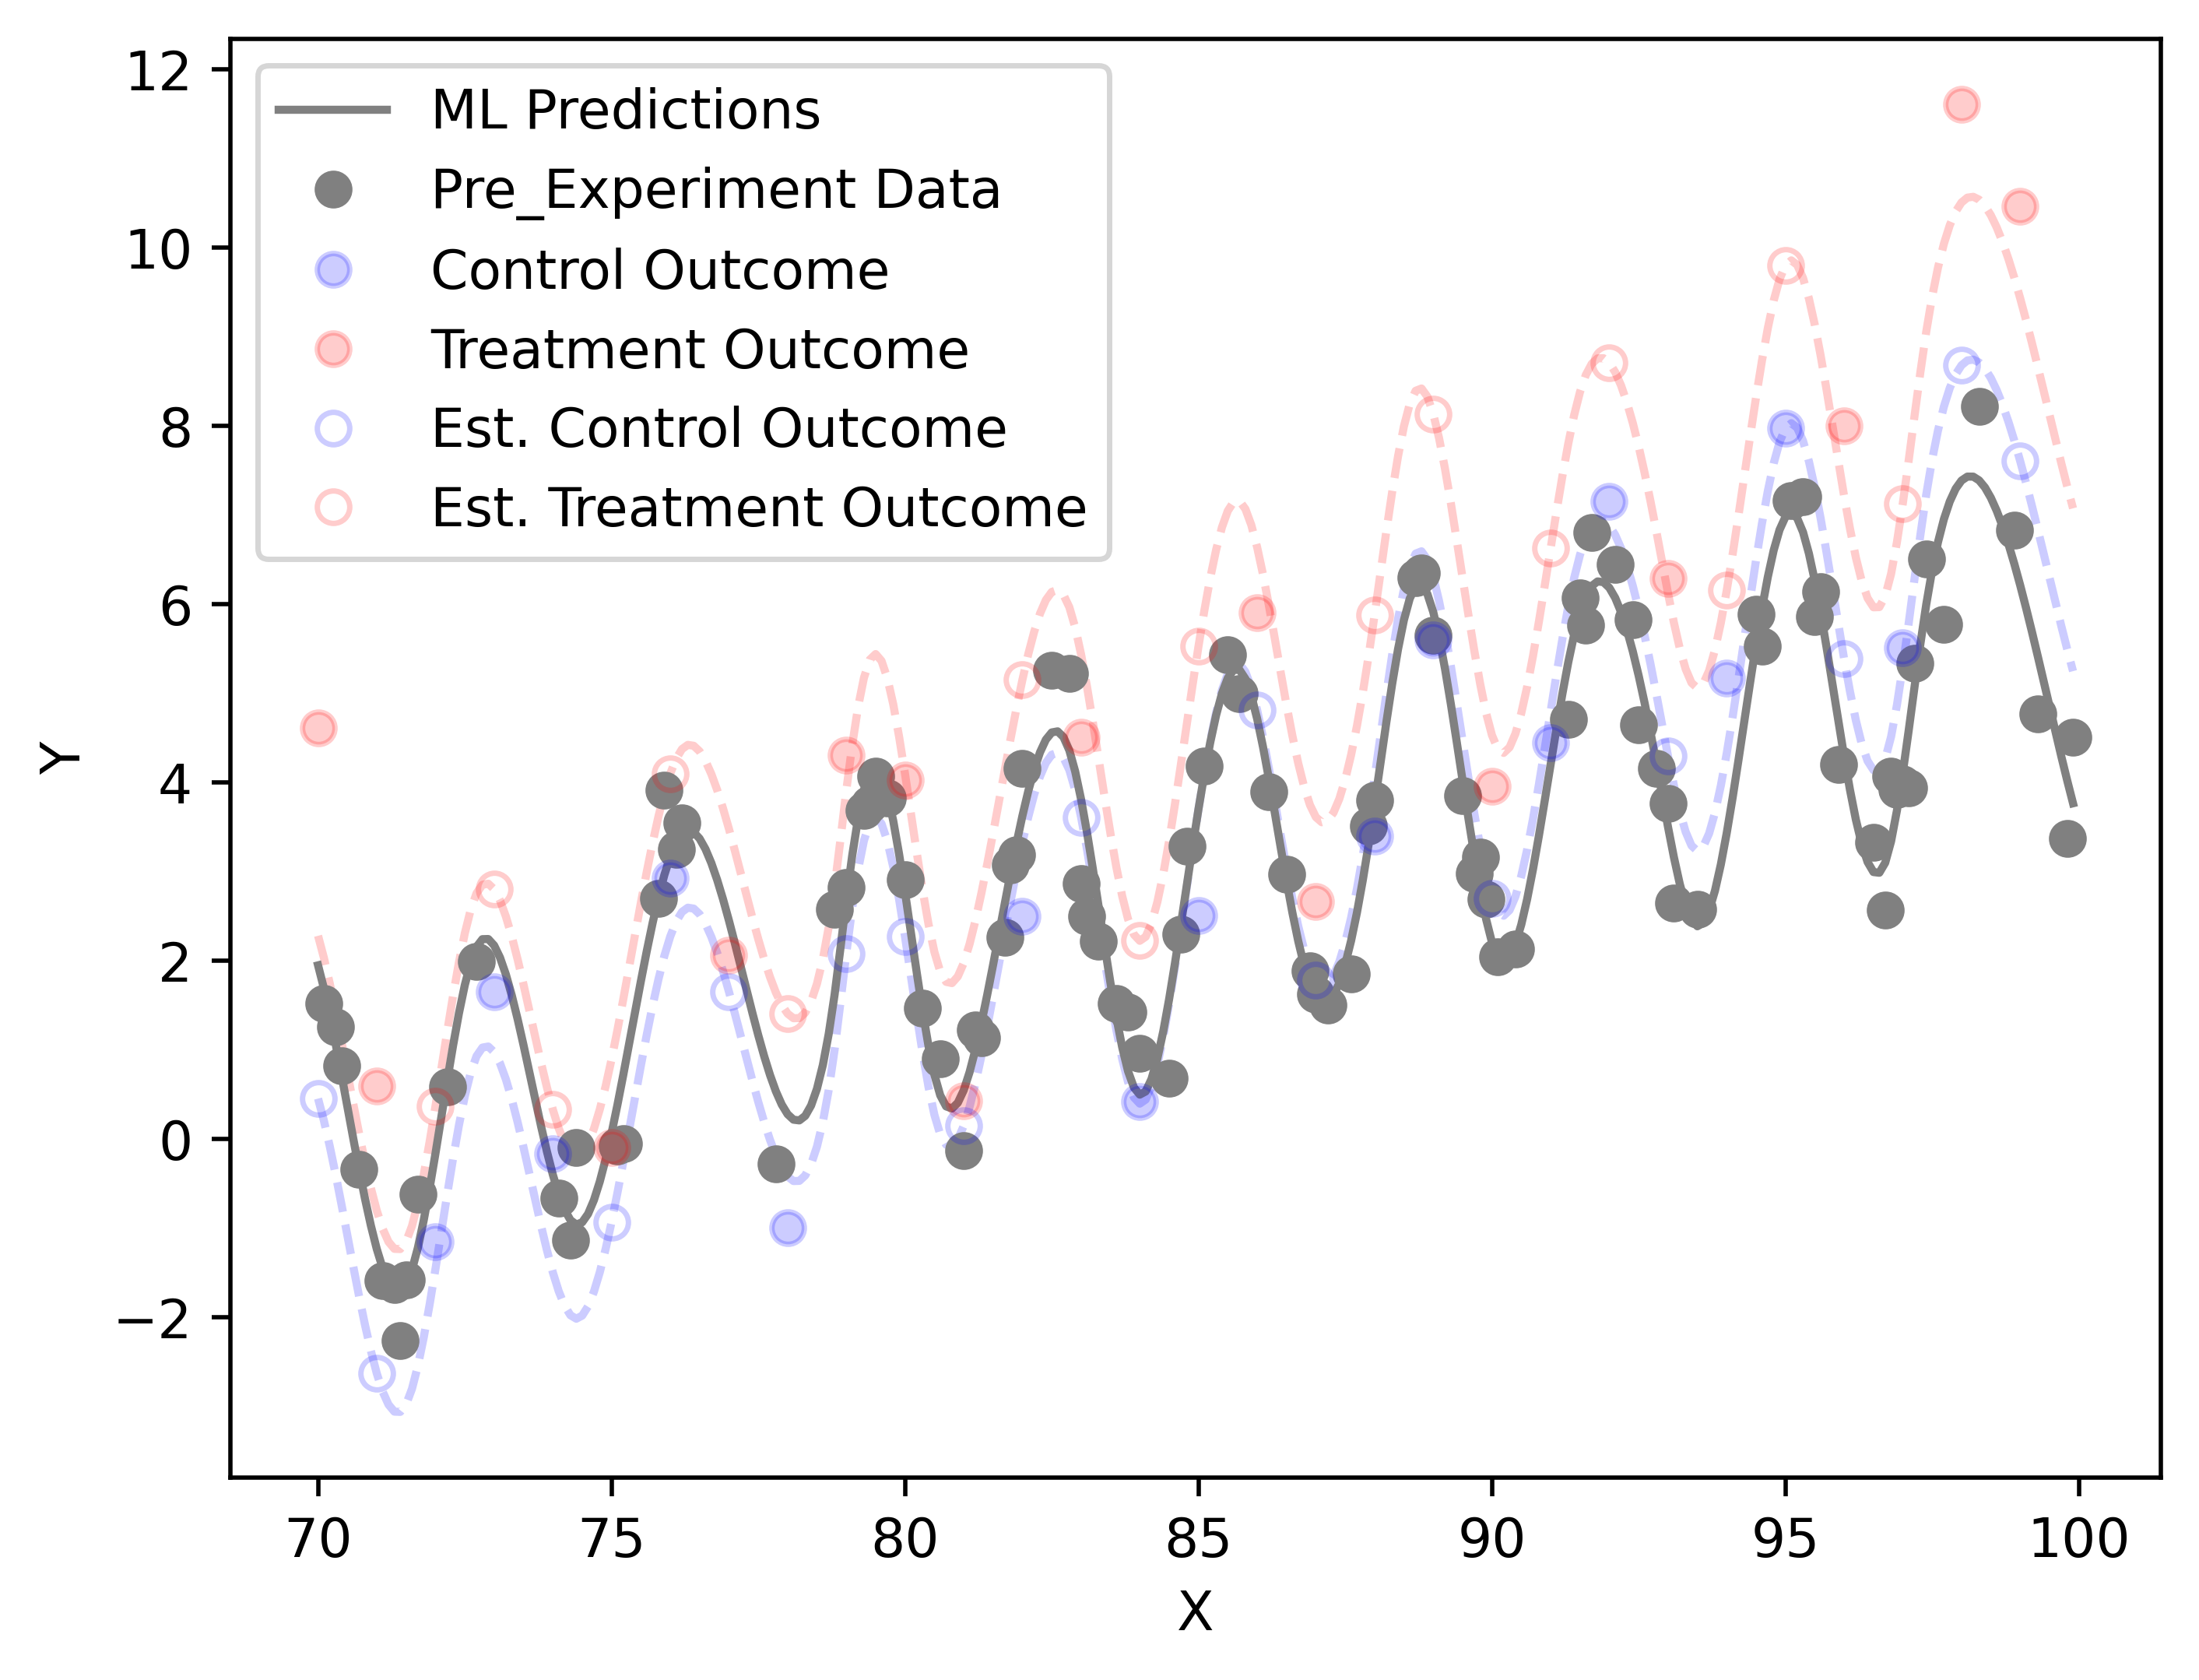

In [13]:
plt.figure(dpi=dpi)
plt.plot(x,treatline, color='red',linestyle='--',alpha=0.2)
plt.plot(x,controlline, color='blue',linestyle='--',alpha=0.2)
plt.plot(x,BSpline(*tck)(x), label = 'ML Predictions',color='grey',alpha=1)
plt.plot(x_pre, y_pre, 'o',color='grey',label="Pre_Experiment Data",alpha=1)
plt.plot(control_x, control_y, 'o', color = 'blue', label='Control Outcome',alpha=0.2)
plt.plot(treat_x, treat_y, 'o', color = 'red', label = 'Treatment Outcome',alpha=0.2)
plt.plot(treat_x, alpha0 + treat_x * beta + BSpline(*tck)(treat_x),'o',fillstyle='none',color='blue',label='Est. Control Outcome',alpha=0.2)
plt.plot(control_x, alpha1 + control_x * beta + BSpline(*tck)(control_x),'o',fillstyle='none',color='red',label='Est. Treatment Outcome',alpha=0.2)
plt.ylabel("Y")
plt.xlabel("X")
plt.legend(loc=2)
plt.savefig("plots/sec_preexp.png")
plt.show()

In [14]:
np.random.seed(1)
random.seed(1)
sim_num = 1000
sample_sizes = {1: 10, 2: 40, 3:80}
res = {}
# define the original x and y (without treatment)
x = np.arange(70,100,1)
n = len(x)
error = np.random.normal(0,1,n)
y = exp_data(x)
te = 2
for key in sample_sizes:
    temp = []
    n0 = sample_sizes[key]
    n1 = sample_sizes[key]
    for i in range(sim_num):
        #control_idx = random.sample(range(n),n//2)
        #treat_idx = list(set(range(n)).difference(control_idx))
        # or if with replacement
        control_idx = random.choices(range(n), k=n0)
        treat_idx = random.choices(range(n), k=n1)
        control_idx.sort()
        treat_idx.sort()
        control_x = x[control_idx]
        treat_x = x[treat_idx]
        control_y = y[control_idx]
        treat_y = y[treat_idx] + te

        # perform difference in means
        two_est = np.mean(treat_y) - np.mean(control_y)
        two_se = (np.var(treat_y,ddof=1)/n1 + np.var(control_y,ddof=1)/n0)**0.5

        # perform counterfactual estimator with regression
        treatxvar = np.var(treat_x)
        controlxvar = np.var(control_x)
        treatxcov = np.cov(treat_x, treat_y)[0,1]
        controlxcov = np.cov(control_x, control_y)[0,1]
        beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
        alpha1 = np.mean(treat_y) - np.mean(treat_x)*beta
        alpha0 = np.mean(control_y) - np.mean(control_x)*beta
        reg_est = alpha1 - alpha0
        reg_se = (np.var(treat_y - treat_x * beta,ddof=1)/len(treat_y) + np.var(control_y - control_x * beta,ddof=1)/len(control_y))**0.5
        
        # perform counterfactual estimator with ML
        treat_preds = BSpline(*tck)(treat_x)
        control_preds = BSpline(*tck)(control_x)
        pred_alpha1 = np.mean(treat_y - treat_preds)
        pred_alpha0 = np.mean(control_y - control_preds)
        ml_est = pred_alpha1 - pred_alpha0
        ml_se = (np.var(treat_y - treat_preds,ddof=1)/len(treat_y) + np.var(control_y - control_preds,ddof=1)/len(control_y))**0.5
        
        # perform secondary linear adjustment to ML
        control_r = control_y - control_preds
        treat_r = treat_y - treat_preds
        treatxcovr = np.cov(treat_x, treat_r)[0,1]
        controlxcovr = np.cov(control_x, control_r)[0,1]
        beta_s = (treatxcovr + controlxcovr)/(treatxvar + controlxvar)
        alpha1_s = np.mean(treat_r) - np.mean(treat_x)*beta_s
        alpha0_s = np.mean(control_r) - np.mean(control_x)*beta_s
        s_est = alpha1_s - alpha0_s
        s_se = (np.var(treat_r - treat_x * beta_s,ddof=1)/len(treat_y) + np.var(control_r - control_x * beta_s,ddof=1)/len(control_y))**0.5

        temp.append([two_est, two_se, reg_est, reg_se, ml_est, ml_se, s_est, s_se])

    res[key] = pd.DataFrame(temp, columns = ['two_est','two_se','reg_est','reg_se','ml_est','ml_se','s_est','s_se'])

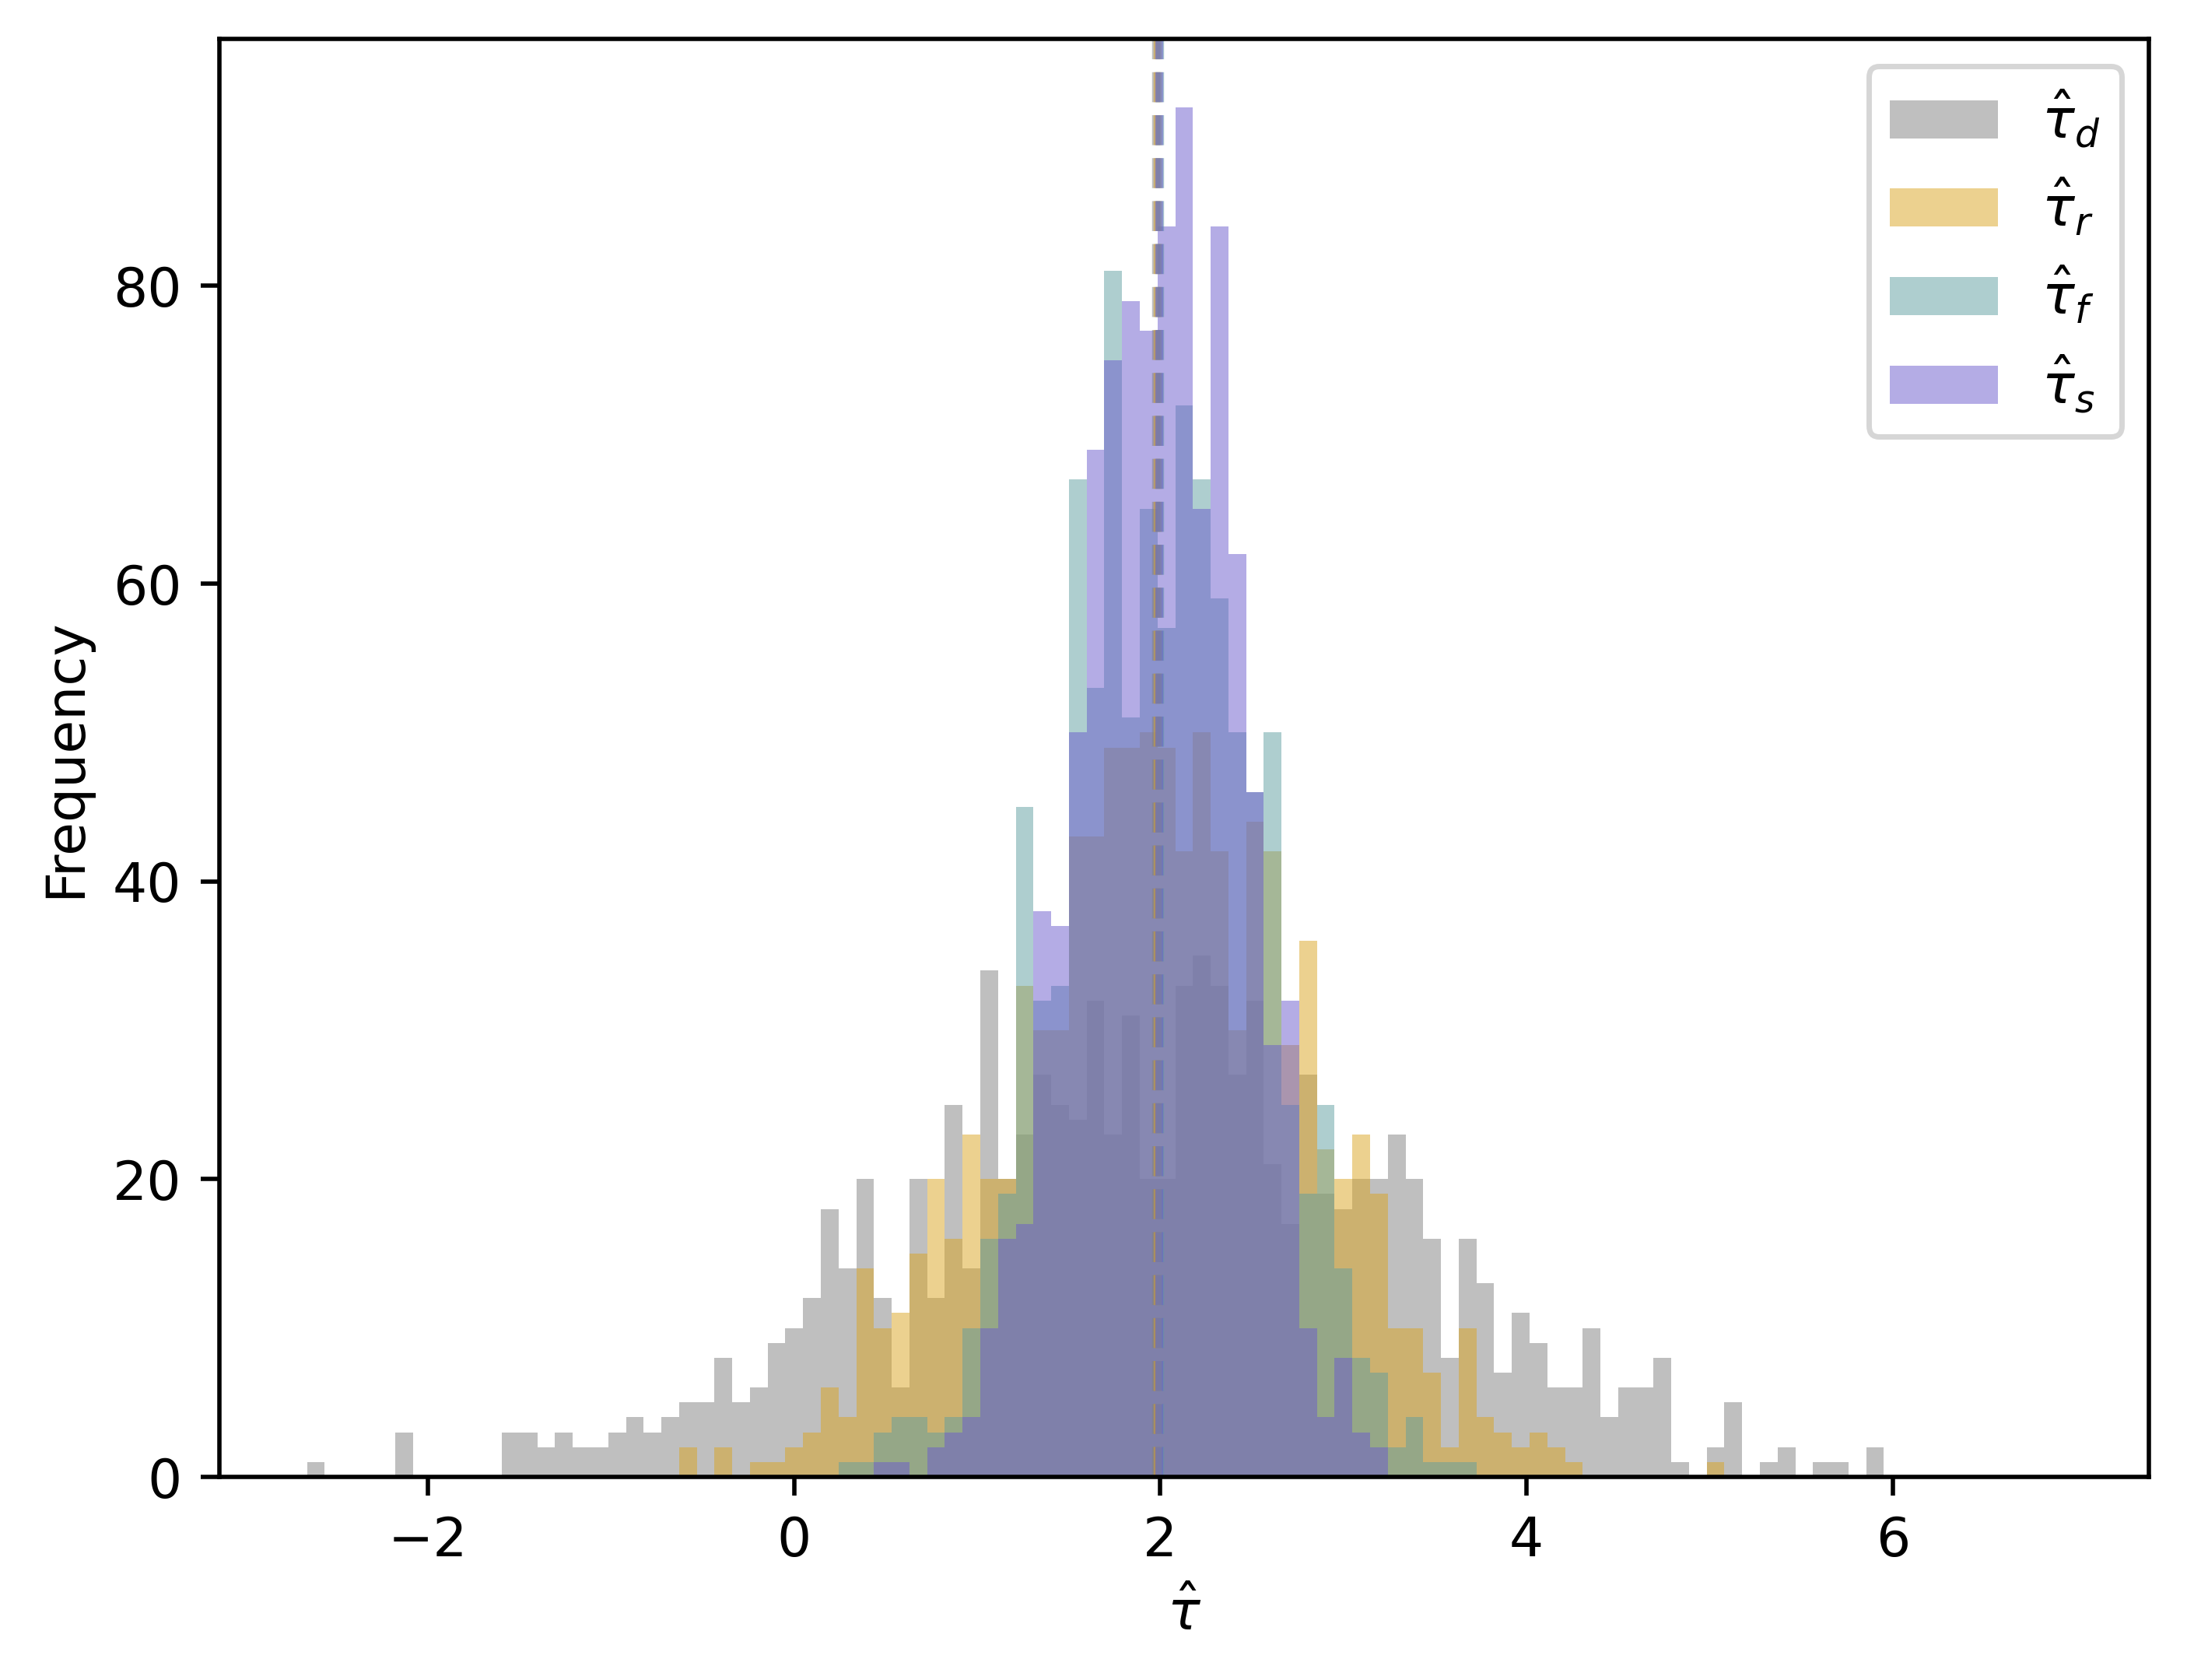

Sample size: 10 ATE_d: 1.9760411207348378 ATE_r: 1.9851764977982755 ATE_ml: 2.0000558956493024 ATE_s: 1.9948091091362536


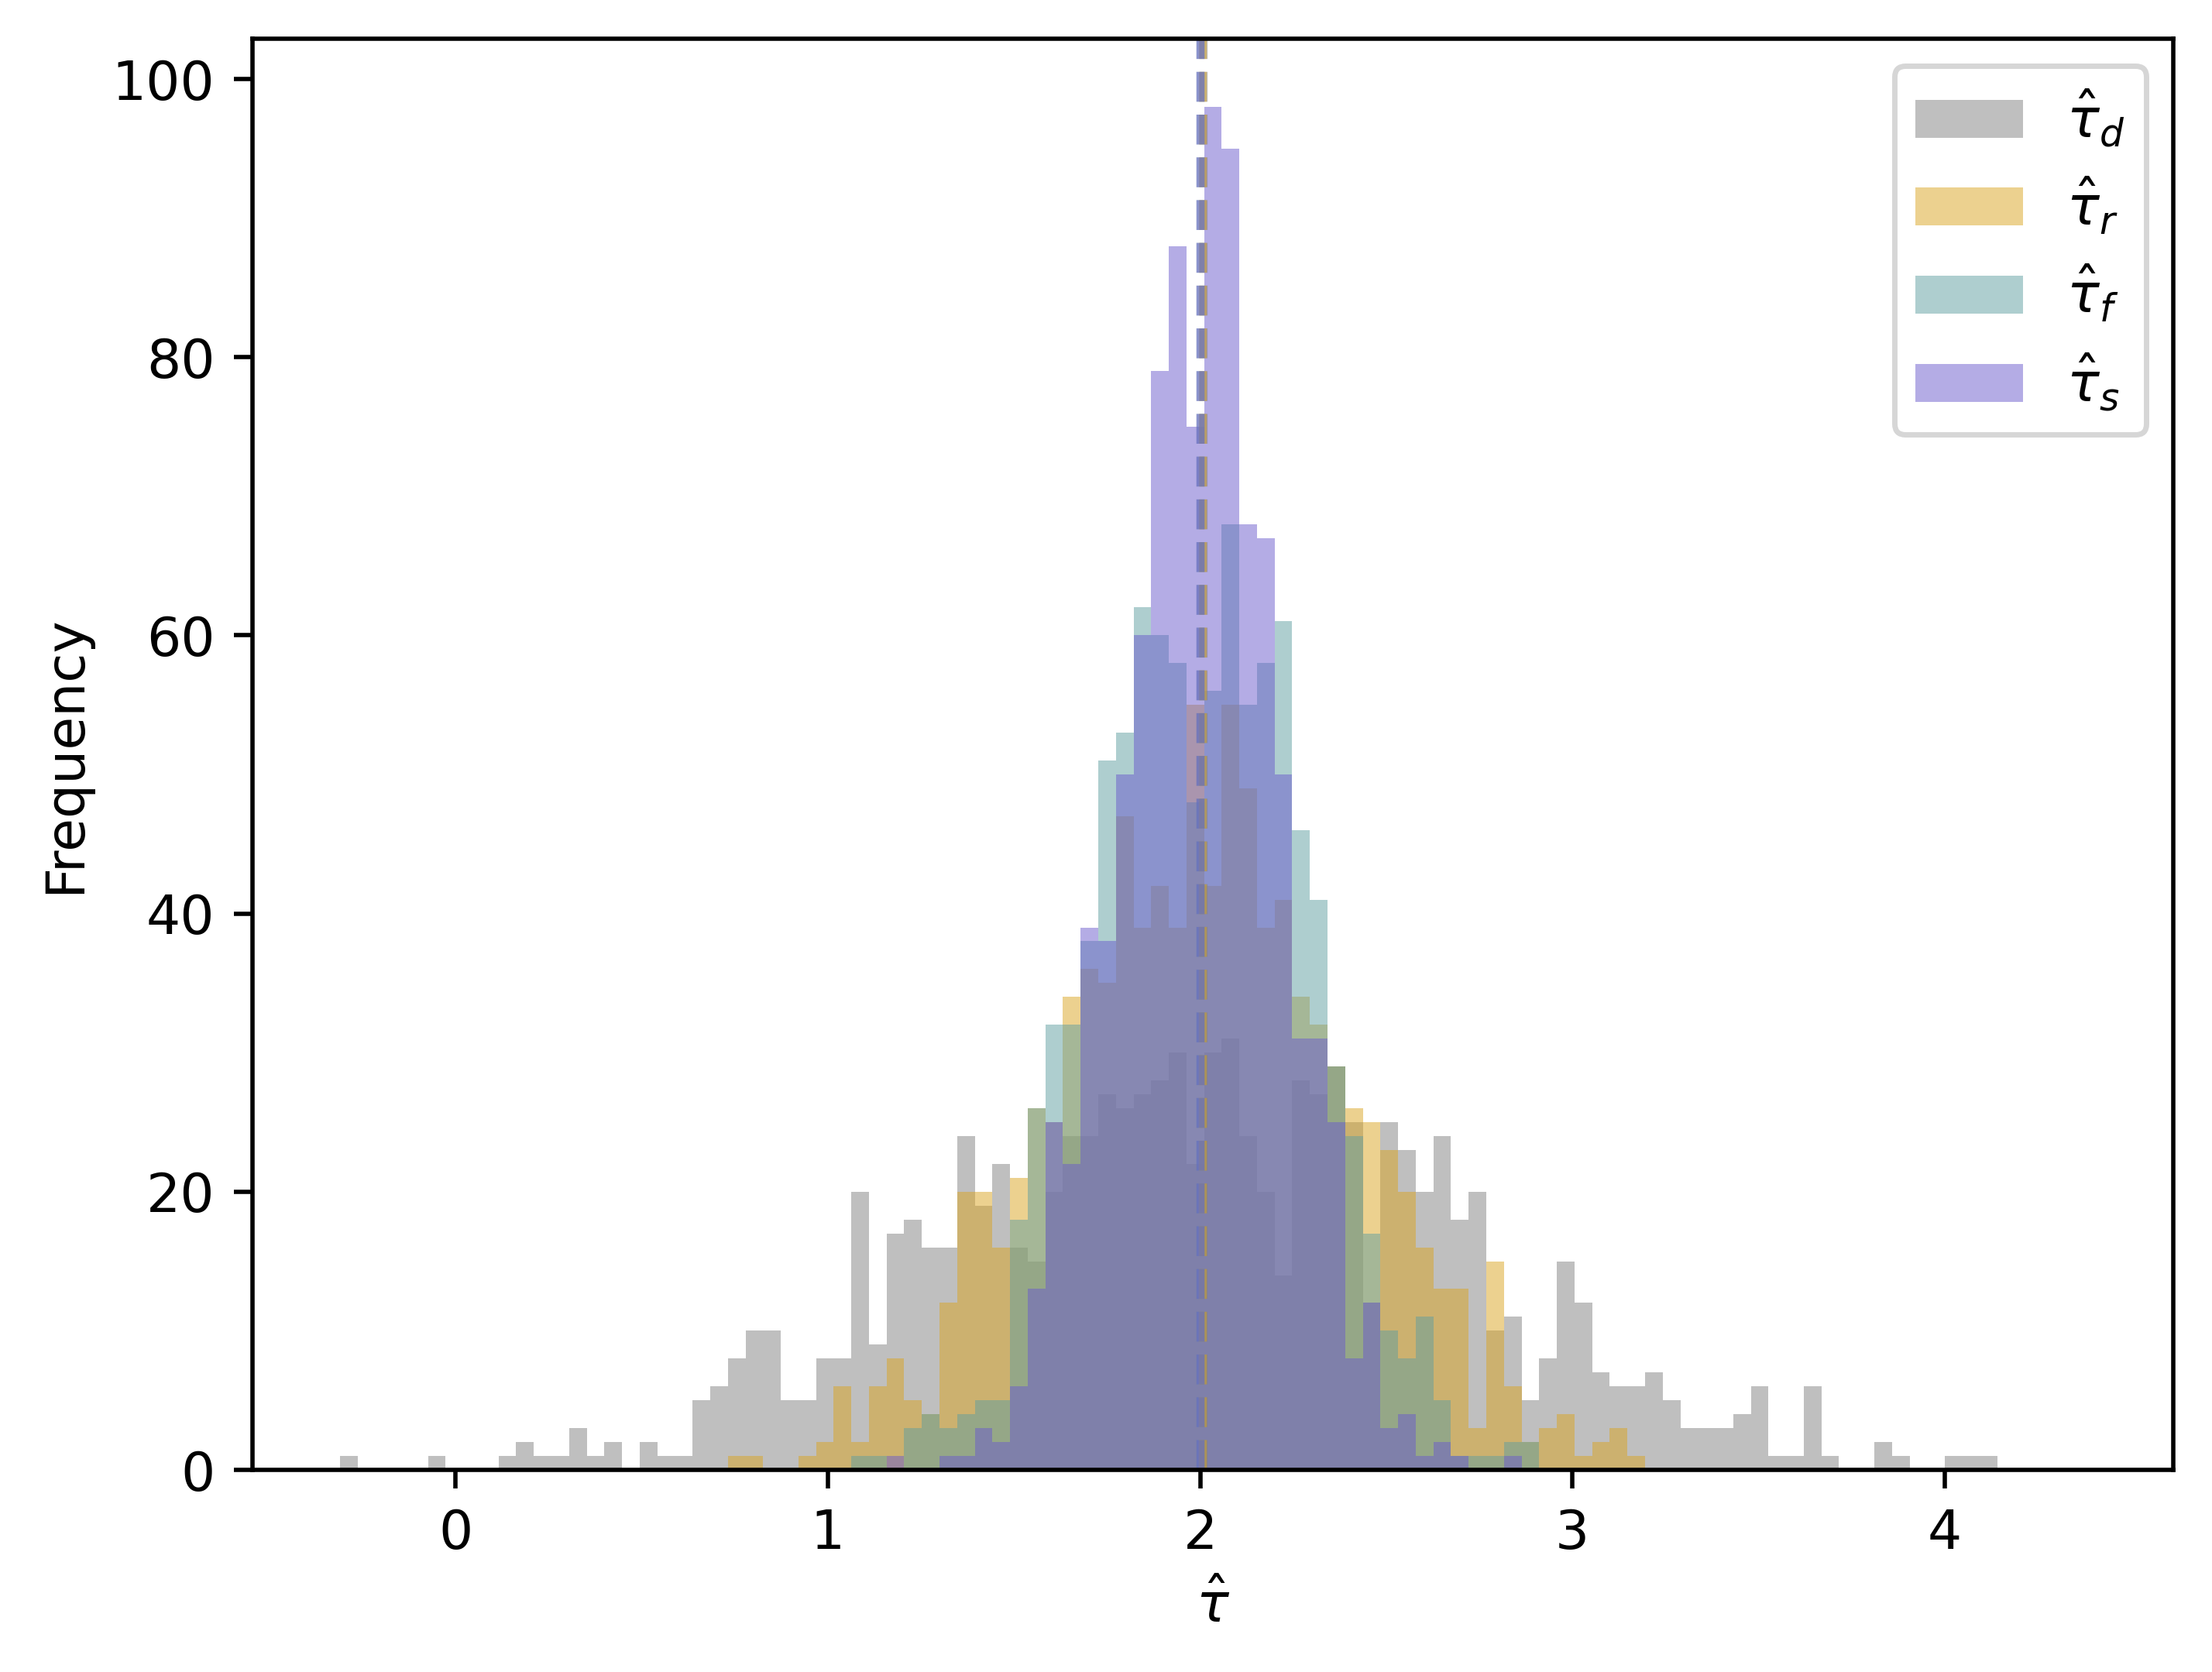

Sample size: 40 ATE_d: 2.0102915887934354 ATE_r: 2.007336601452813 ATE_ml: 2.0016023508930023 ATE_s: 2.000467323167041


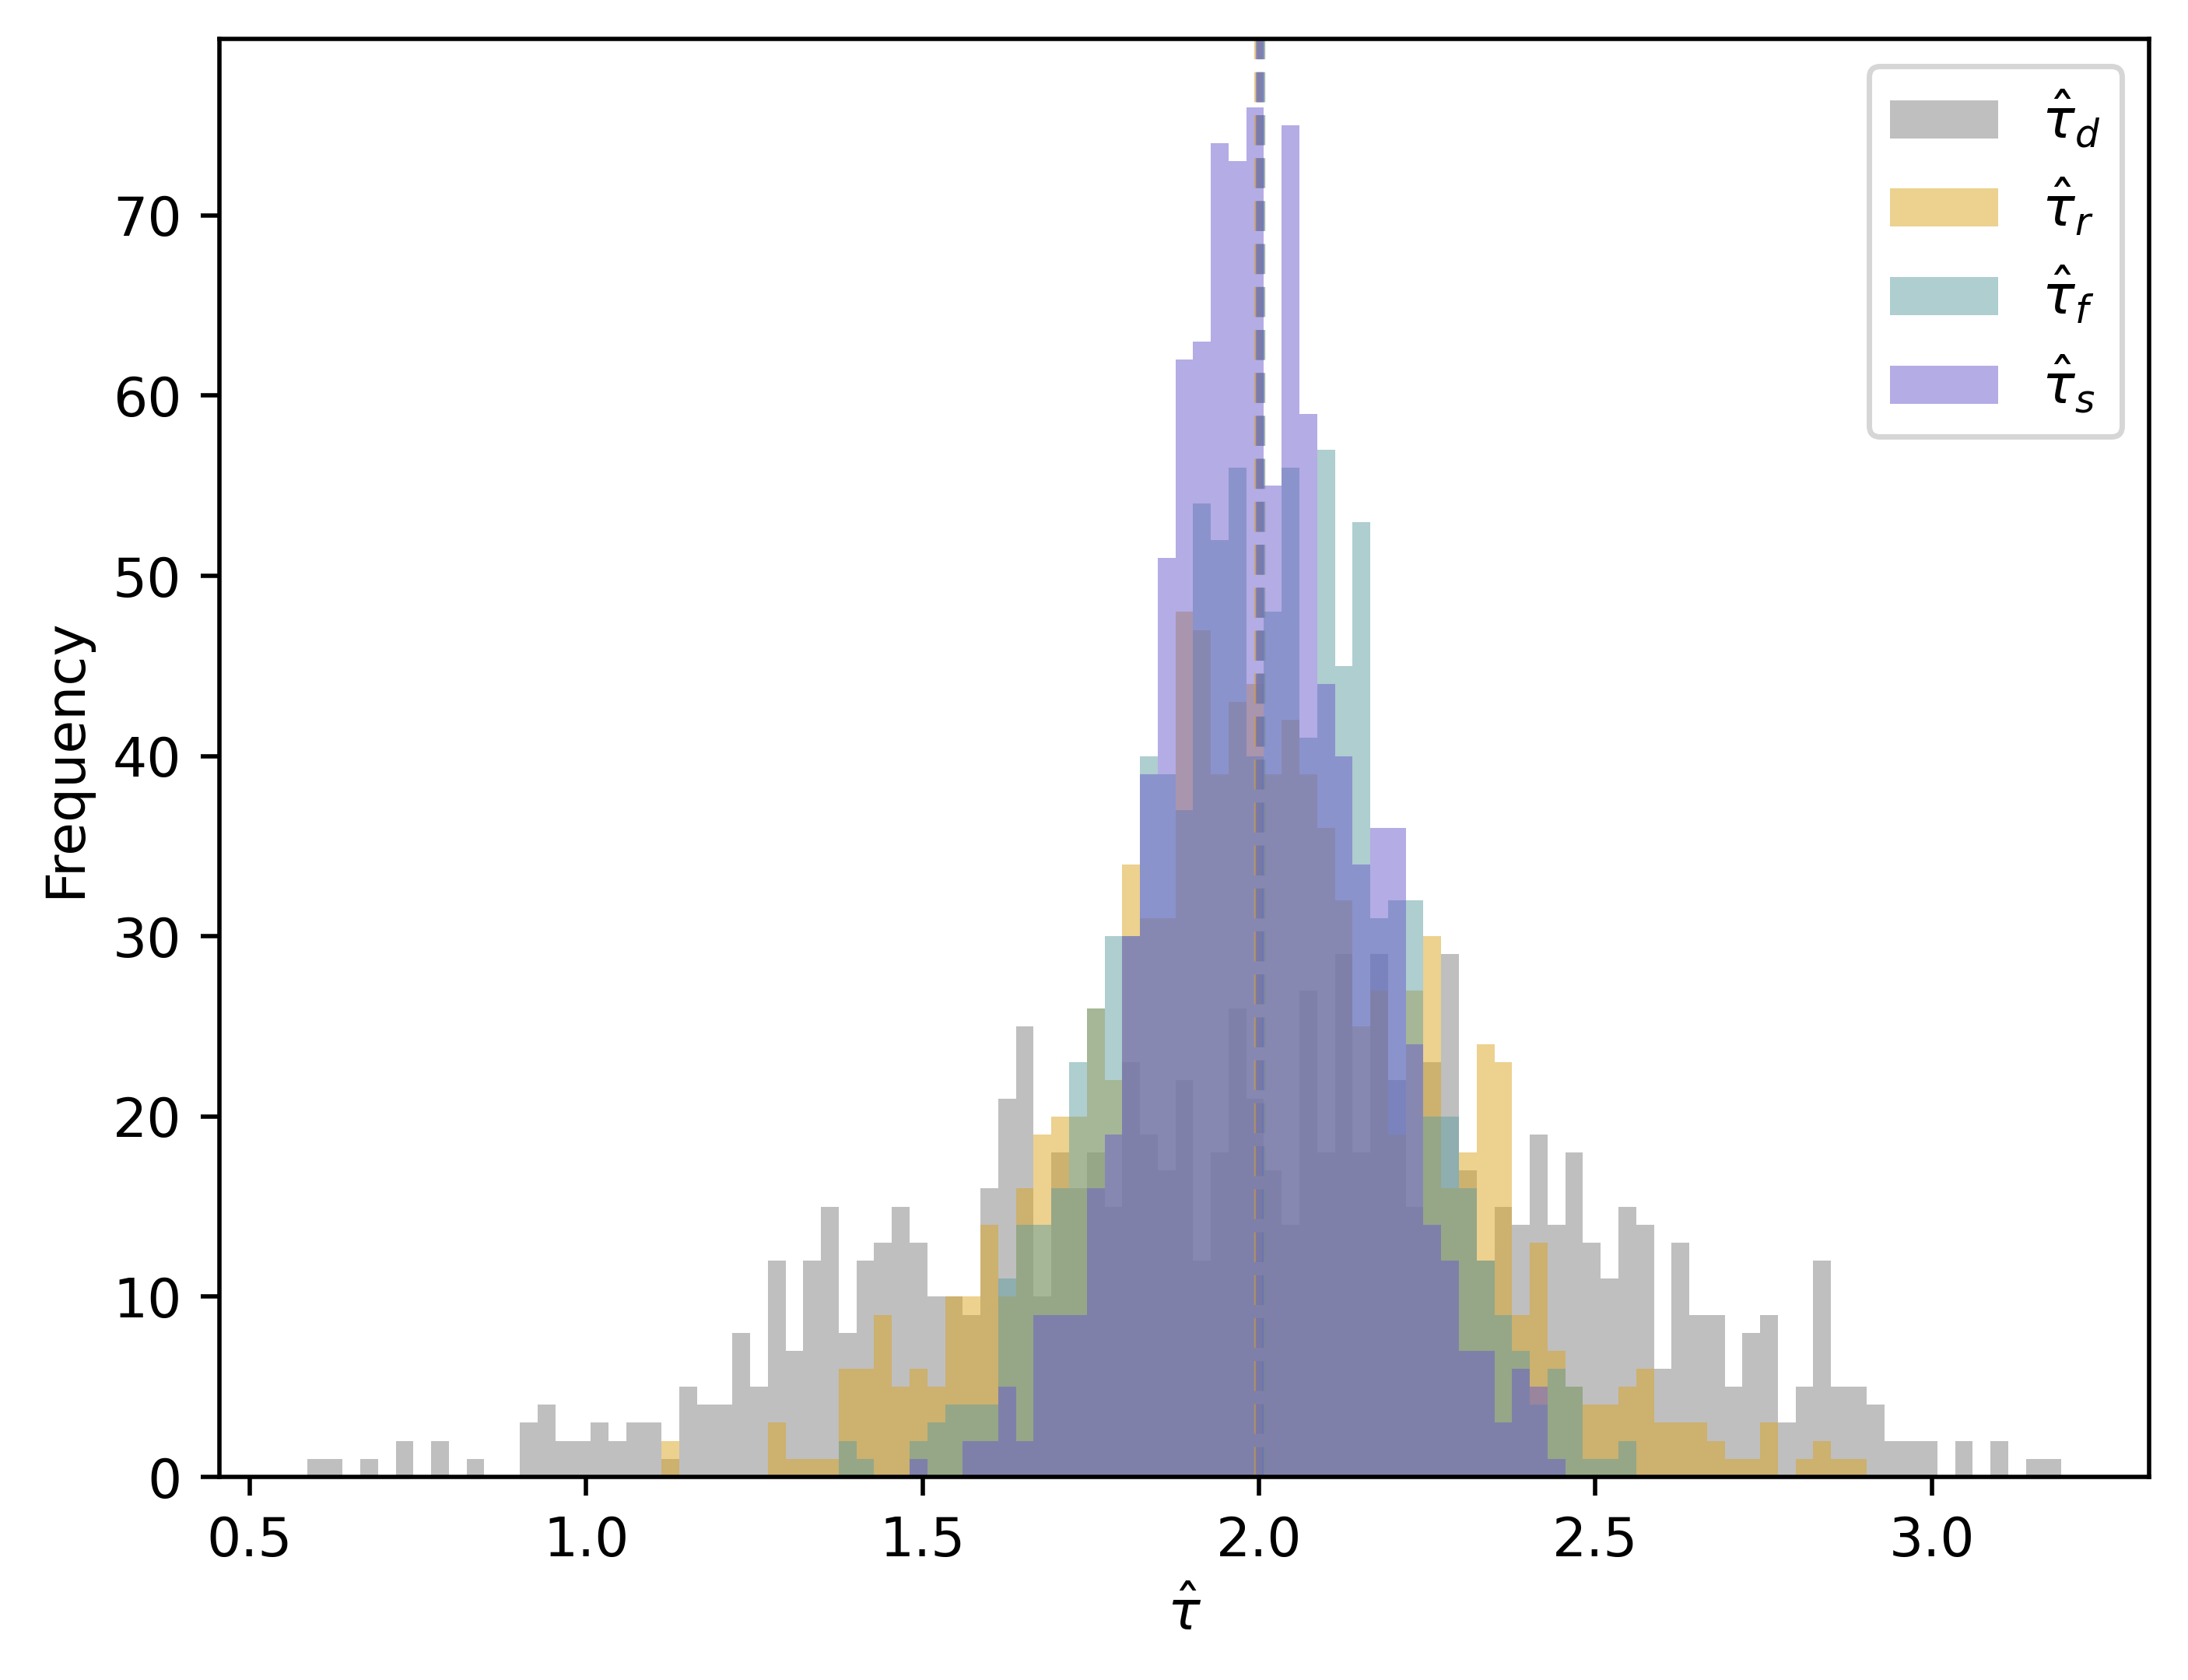

Sample size: 80 ATE_d: 2.003297441806425 ATE_r: 1.9983995110735167 ATE_ml: 2.002055681882991 ATE_s: 2.000946634736432


In [15]:
for key in res:
    plt.figure(dpi=dpi)
    sim_res = res[key]
    # use this to first determine overall range, and manually set max and min with visual analysis
    bins_max = max(max(sim_res['two_est']),max(sim_res['reg_est']),max(sim_res['ml_est']),max(sim_res['s_est']))
    bins_min = min(min(sim_res['two_est']),min(sim_res['reg_est']),min(sim_res['ml_est']),min(sim_res['s_est']))
    #bins_max = 7
    #bins_min = -3
    bins_freq = 100
    bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
    plt.hist(sim_res['two_est'], bins = bins_range, color = colors['two'], label = r"$\hat{\tau}_d$", alpha=0.5)
    plt.hist(sim_res['reg_est'], bins = bins_range, color = colors['reg'], label=r"$\hat{\tau}_r$",alpha=0.5)
    plt.hist(sim_res['ml_est'], bins = bins_range, color = colors['ml'], label=r"$\hat{\tau}_{f}$",alpha=0.5)
    plt.hist(sim_res['s_est'], bins = bins_range, color = colors['mix'], label=r"$\hat{\tau}_{s}$",alpha=0.5)
    #plt.hist(sim_res['pair_est2'],bins=np.arange(-1,6,0.1), label='paired_est2',alpha=0.5)
    plt.axvline(np.mean(sim_res['two_est']), color = colors['two'], linestyle='--',alpha=0.5)
    plt.axvline(np.mean(sim_res['reg_est']), color = colors['reg'], linestyle='--',alpha=0.5)
    plt.axvline(np.mean(sim_res['ml_est']), color = colors['ml'], linestyle='--',alpha=0.5)
    plt.axvline(np.mean(sim_res['s_est']), color = colors['mix'], linestyle='--',alpha=0.5)
    plt.ylabel("Frequency")
    plt.xlabel(r"$\hat{\tau}$")
    plt.legend(loc=1)
    plt.savefig("plots/sec_" + str(key) + "_ate.png")
    plt.show()
    print("Sample size:",sample_sizes[key], "ATE_d:", np.mean(sim_res['two_est']), "ATE_r:", 
          np.mean(sim_res['reg_est']),"ATE_ml:",np.mean(sim_res['ml_est']),"ATE_s:",np.mean(sim_res['s_est']))

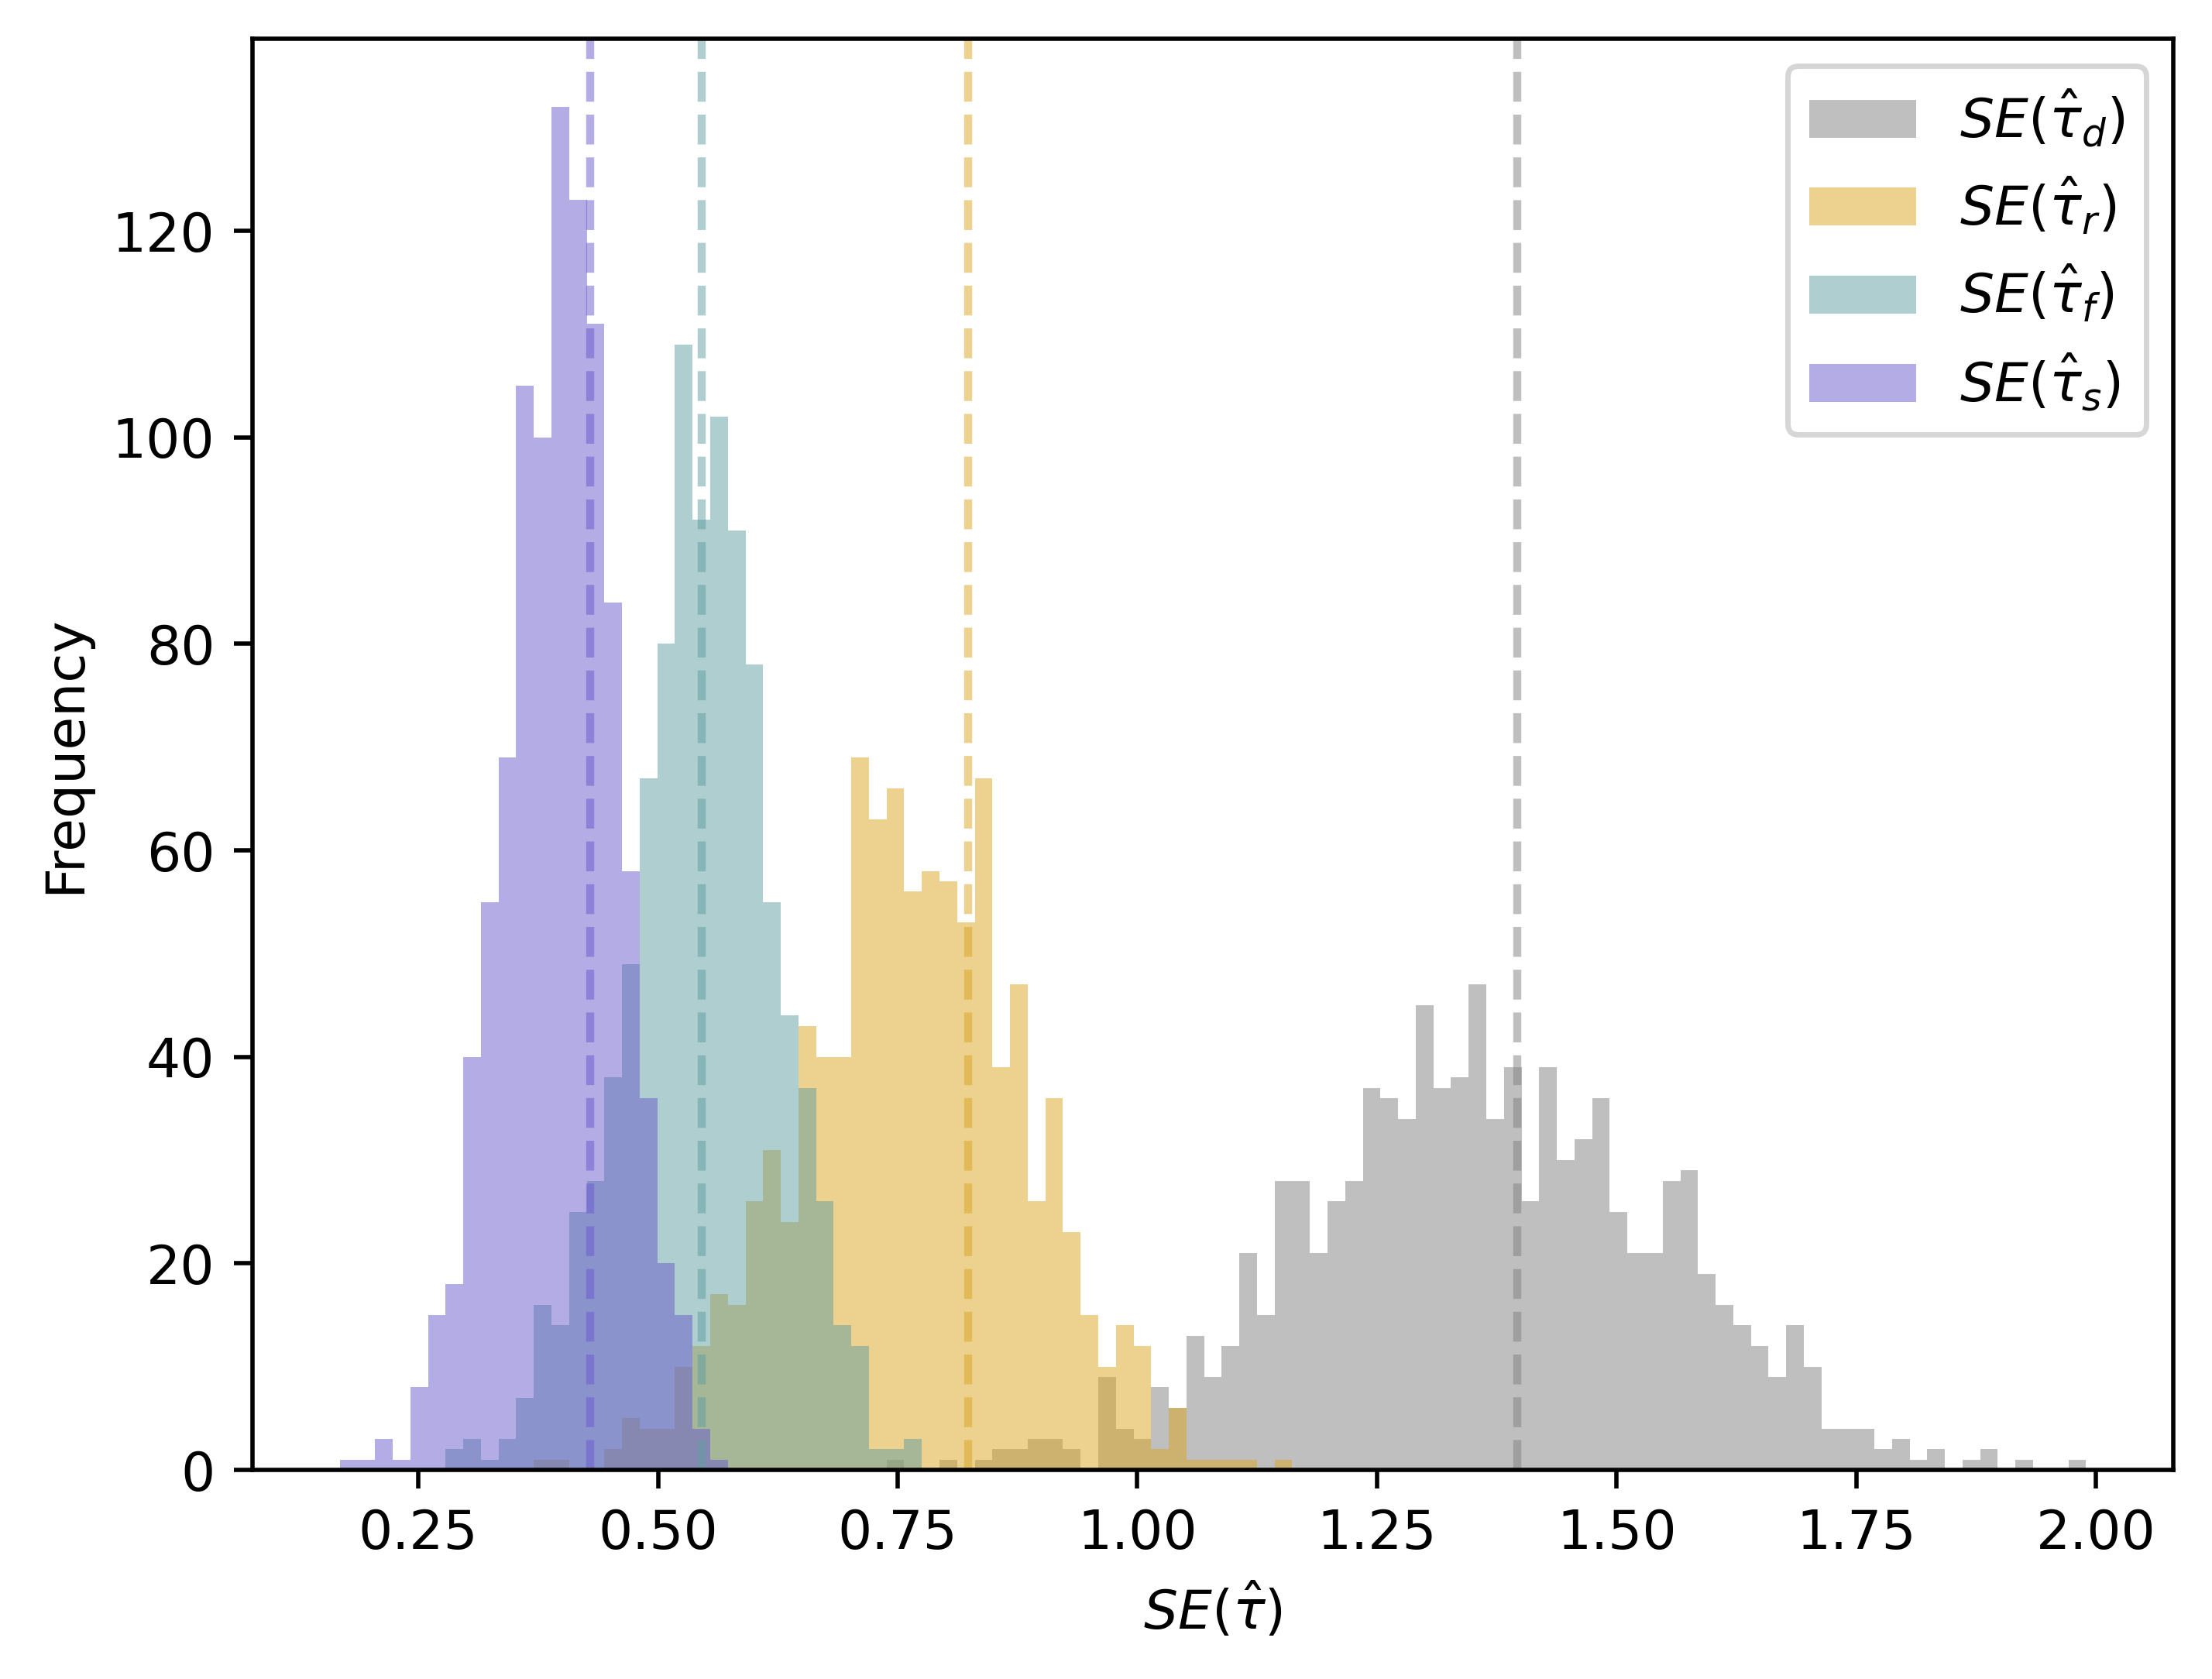

Std_d: 1.3971469144651147 Std_r: 0.8238463668835506 Std_ml:  0.5456381956315185 Std_s: 0.4296641143422741 Var_red: 0.6924703408826787


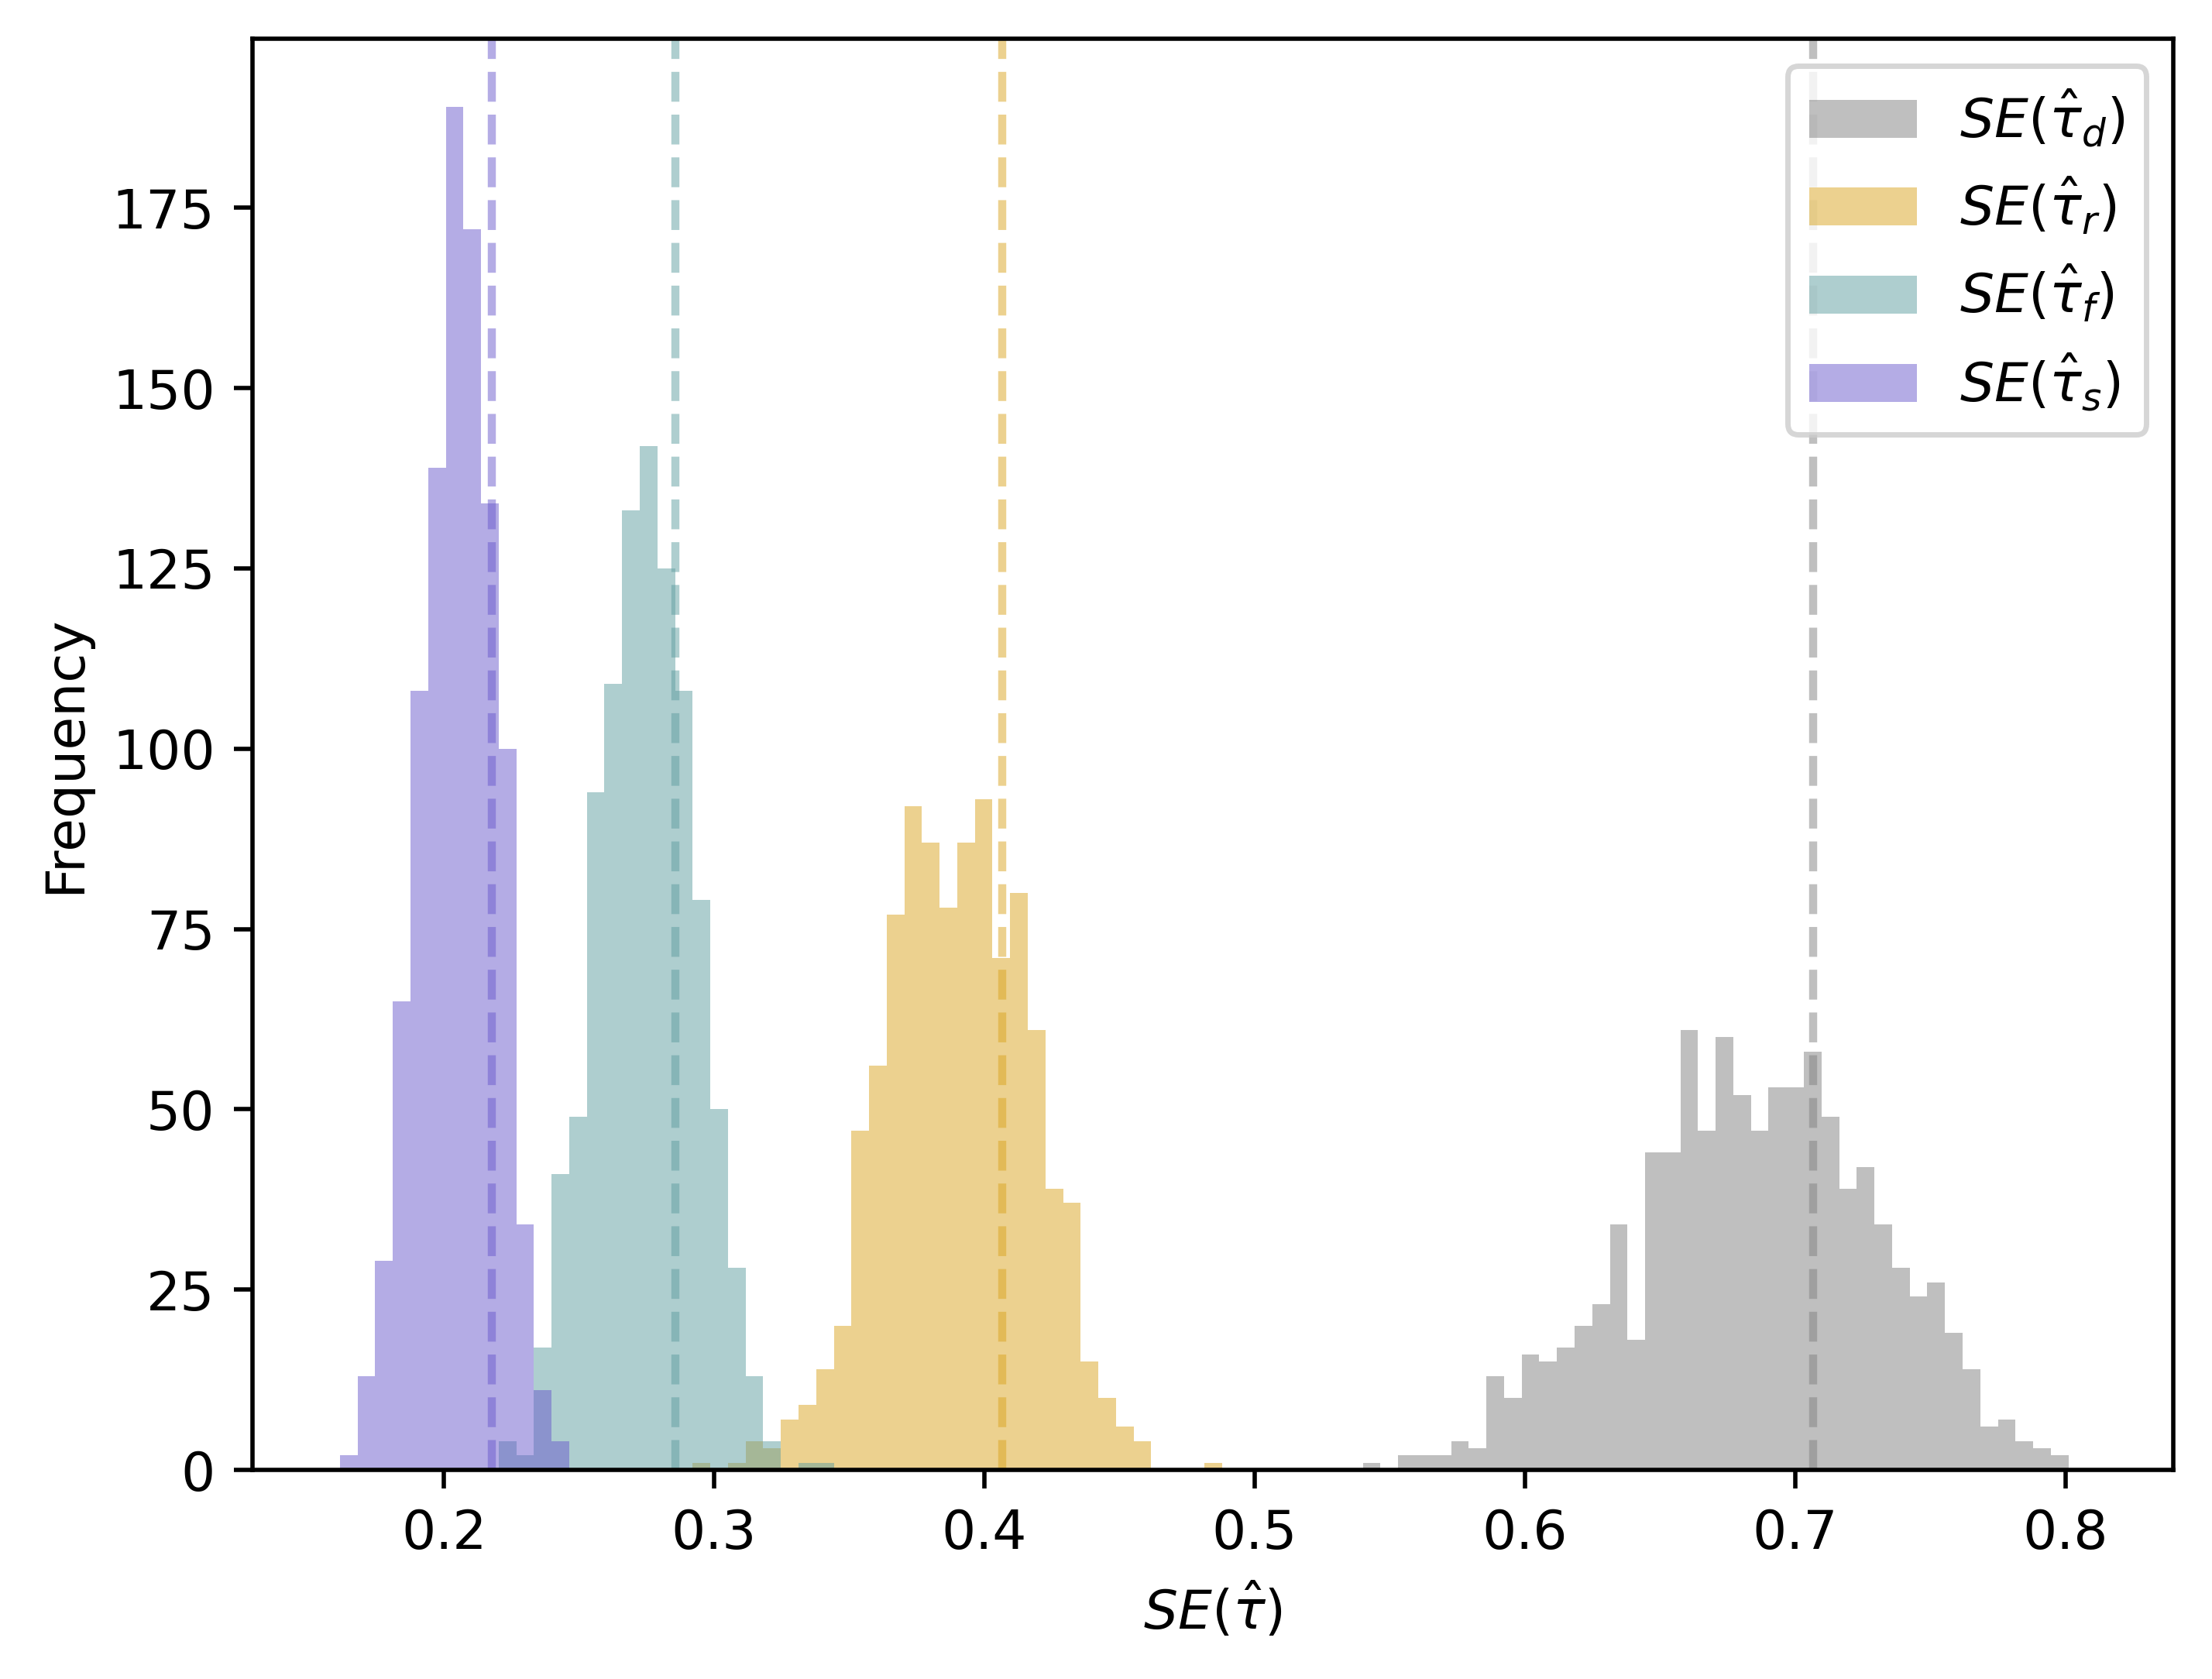

Std_d: 0.7068692647157091 Std_r: 0.40675158400232936 Std_ml:  0.285648496323606 Std_s: 0.21786819879785985 Var_red: 0.6917843091034906


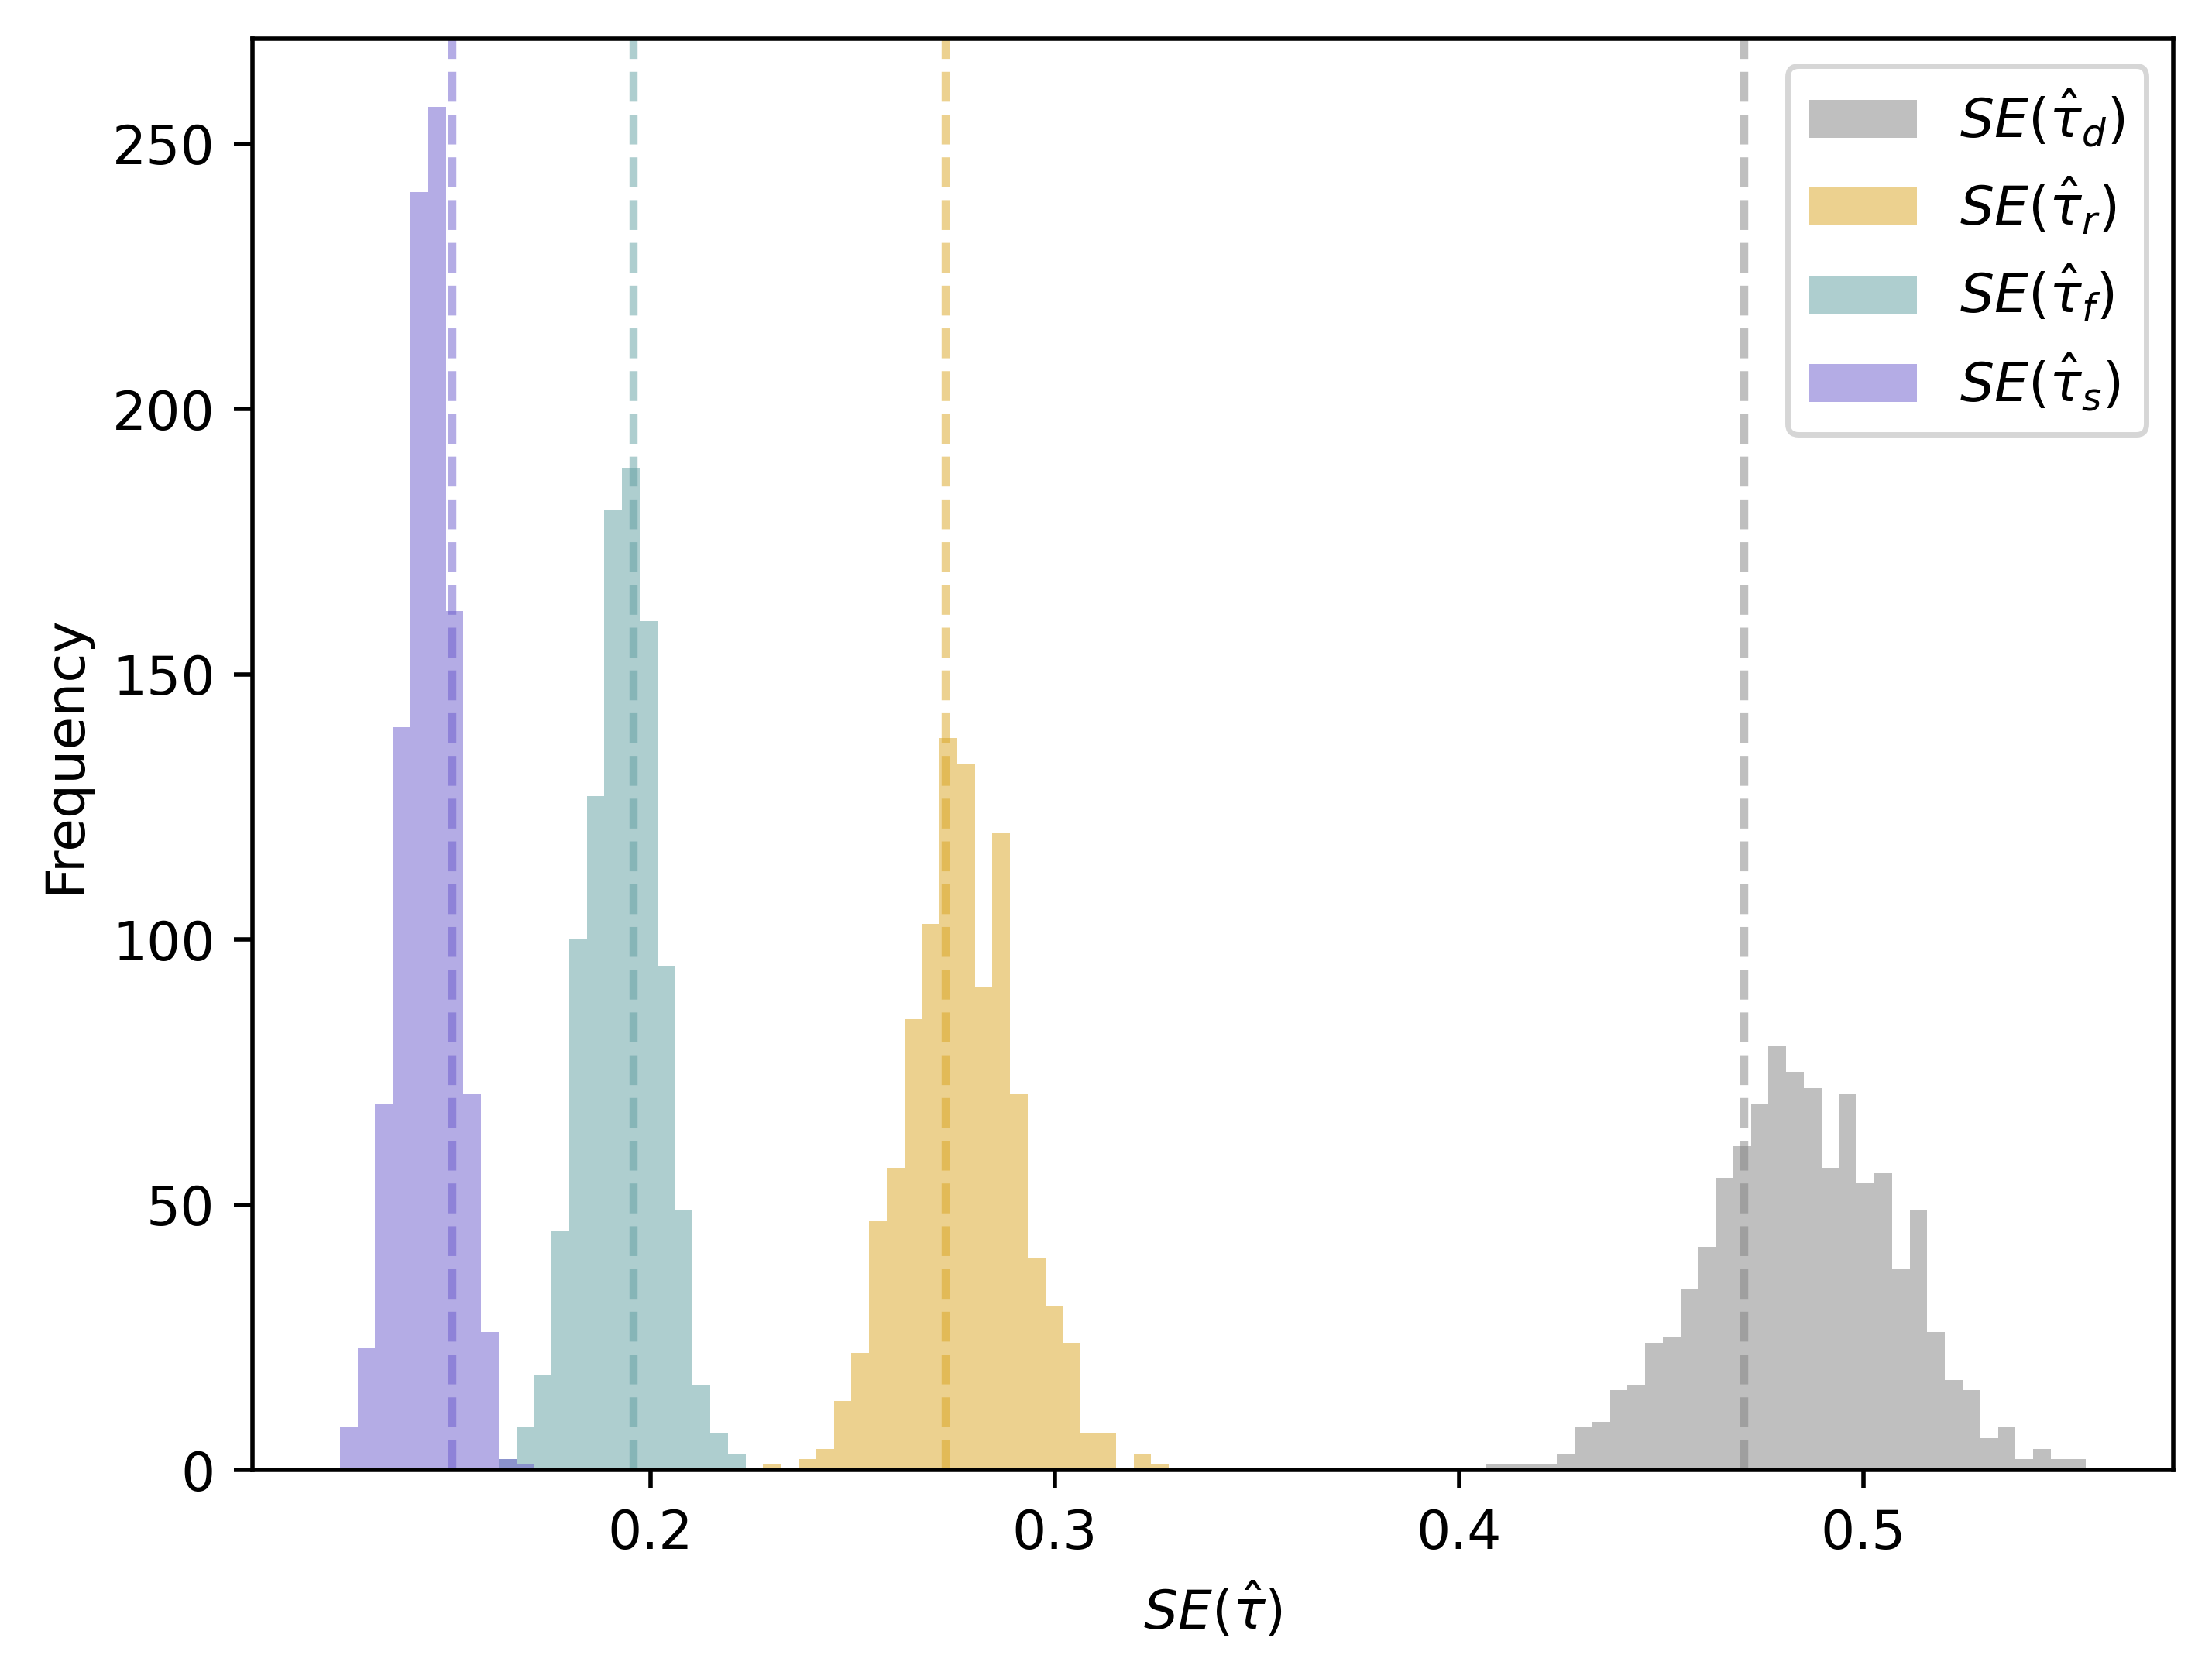

Std_d: 0.4707411297787625 Std_r: 0.27316795929107307 Std_ml:  0.1958011269930984 Std_s: 0.15105873042231238 Var_red: 0.6791044570647428


In [16]:
for key in res:
    plt.figure(dpi=dpi)
    sim_res = res[key]
    # use this to first determine overall range, and manually set max and min with visual analysis
    bins_max = max(max(sim_res['two_se']),max(sim_res['reg_se']),max(sim_res['ml_se']),max(sim_res['s_se']))
    bins_min = min(min(sim_res['two_se']),min(sim_res['reg_se']),min(sim_res['ml_se']),min(sim_res['s_se']))
    #bins_max = 2
    #bins_min = 0.25
    bins_freq = 100
    bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
    plt.hist(sim_res['two_se'], bins = bins_range, color = colors['two'], label = r"$SE(\hat{\tau}_d)$", alpha=0.5)
    plt.hist(sim_res['reg_se'], bins = bins_range, color = colors['reg'], label=r"$SE(\hat{\tau}_r)$",alpha=0.5)
    plt.hist(sim_res['ml_se'], bins = bins_range, color = colors['ml'], label=r"$SE(\hat{\tau}_{f})$",alpha=0.5)
    plt.hist(sim_res['s_se'], bins = bins_range, color = colors['mix'], label=r"$SE(\hat{\tau}_{s})$",alpha=0.5)
    plt.axvline(np.std(sim_res['two_est']), color = colors['two'], linestyle='--',alpha=0.5)
    plt.axvline(np.std(sim_res['reg_est']), color = colors['reg'], linestyle='--',alpha=0.5)
    plt.axvline(np.std(sim_res['ml_est']), color = colors['ml'], linestyle='--',alpha=0.5)
    plt.axvline(np.std(sim_res['s_est']), color = colors['mix'], linestyle='--',alpha=0.5)
    plt.ylabel("Frequency")
    plt.xlabel(r"$SE(\hat{\tau})$")
    plt.legend(loc=1)
    plt.savefig("plots/sec_" + str(key) + "_se.png")
    plt.show()
    print("Std_d:", np.std(sim_res['two_est'],ddof=1), "Std_r:", np.std(sim_res['reg_est'],ddof=1), "Std_ml: ", np.std(sim_res['ml_est'],ddof=1),
          "Std_s:", np.std(sim_res['s_est'],ddof=1),"Var_red:", 1-np.std(sim_res['s_est'],ddof=1)/np.std(sim_res['two_est'],ddof=1))

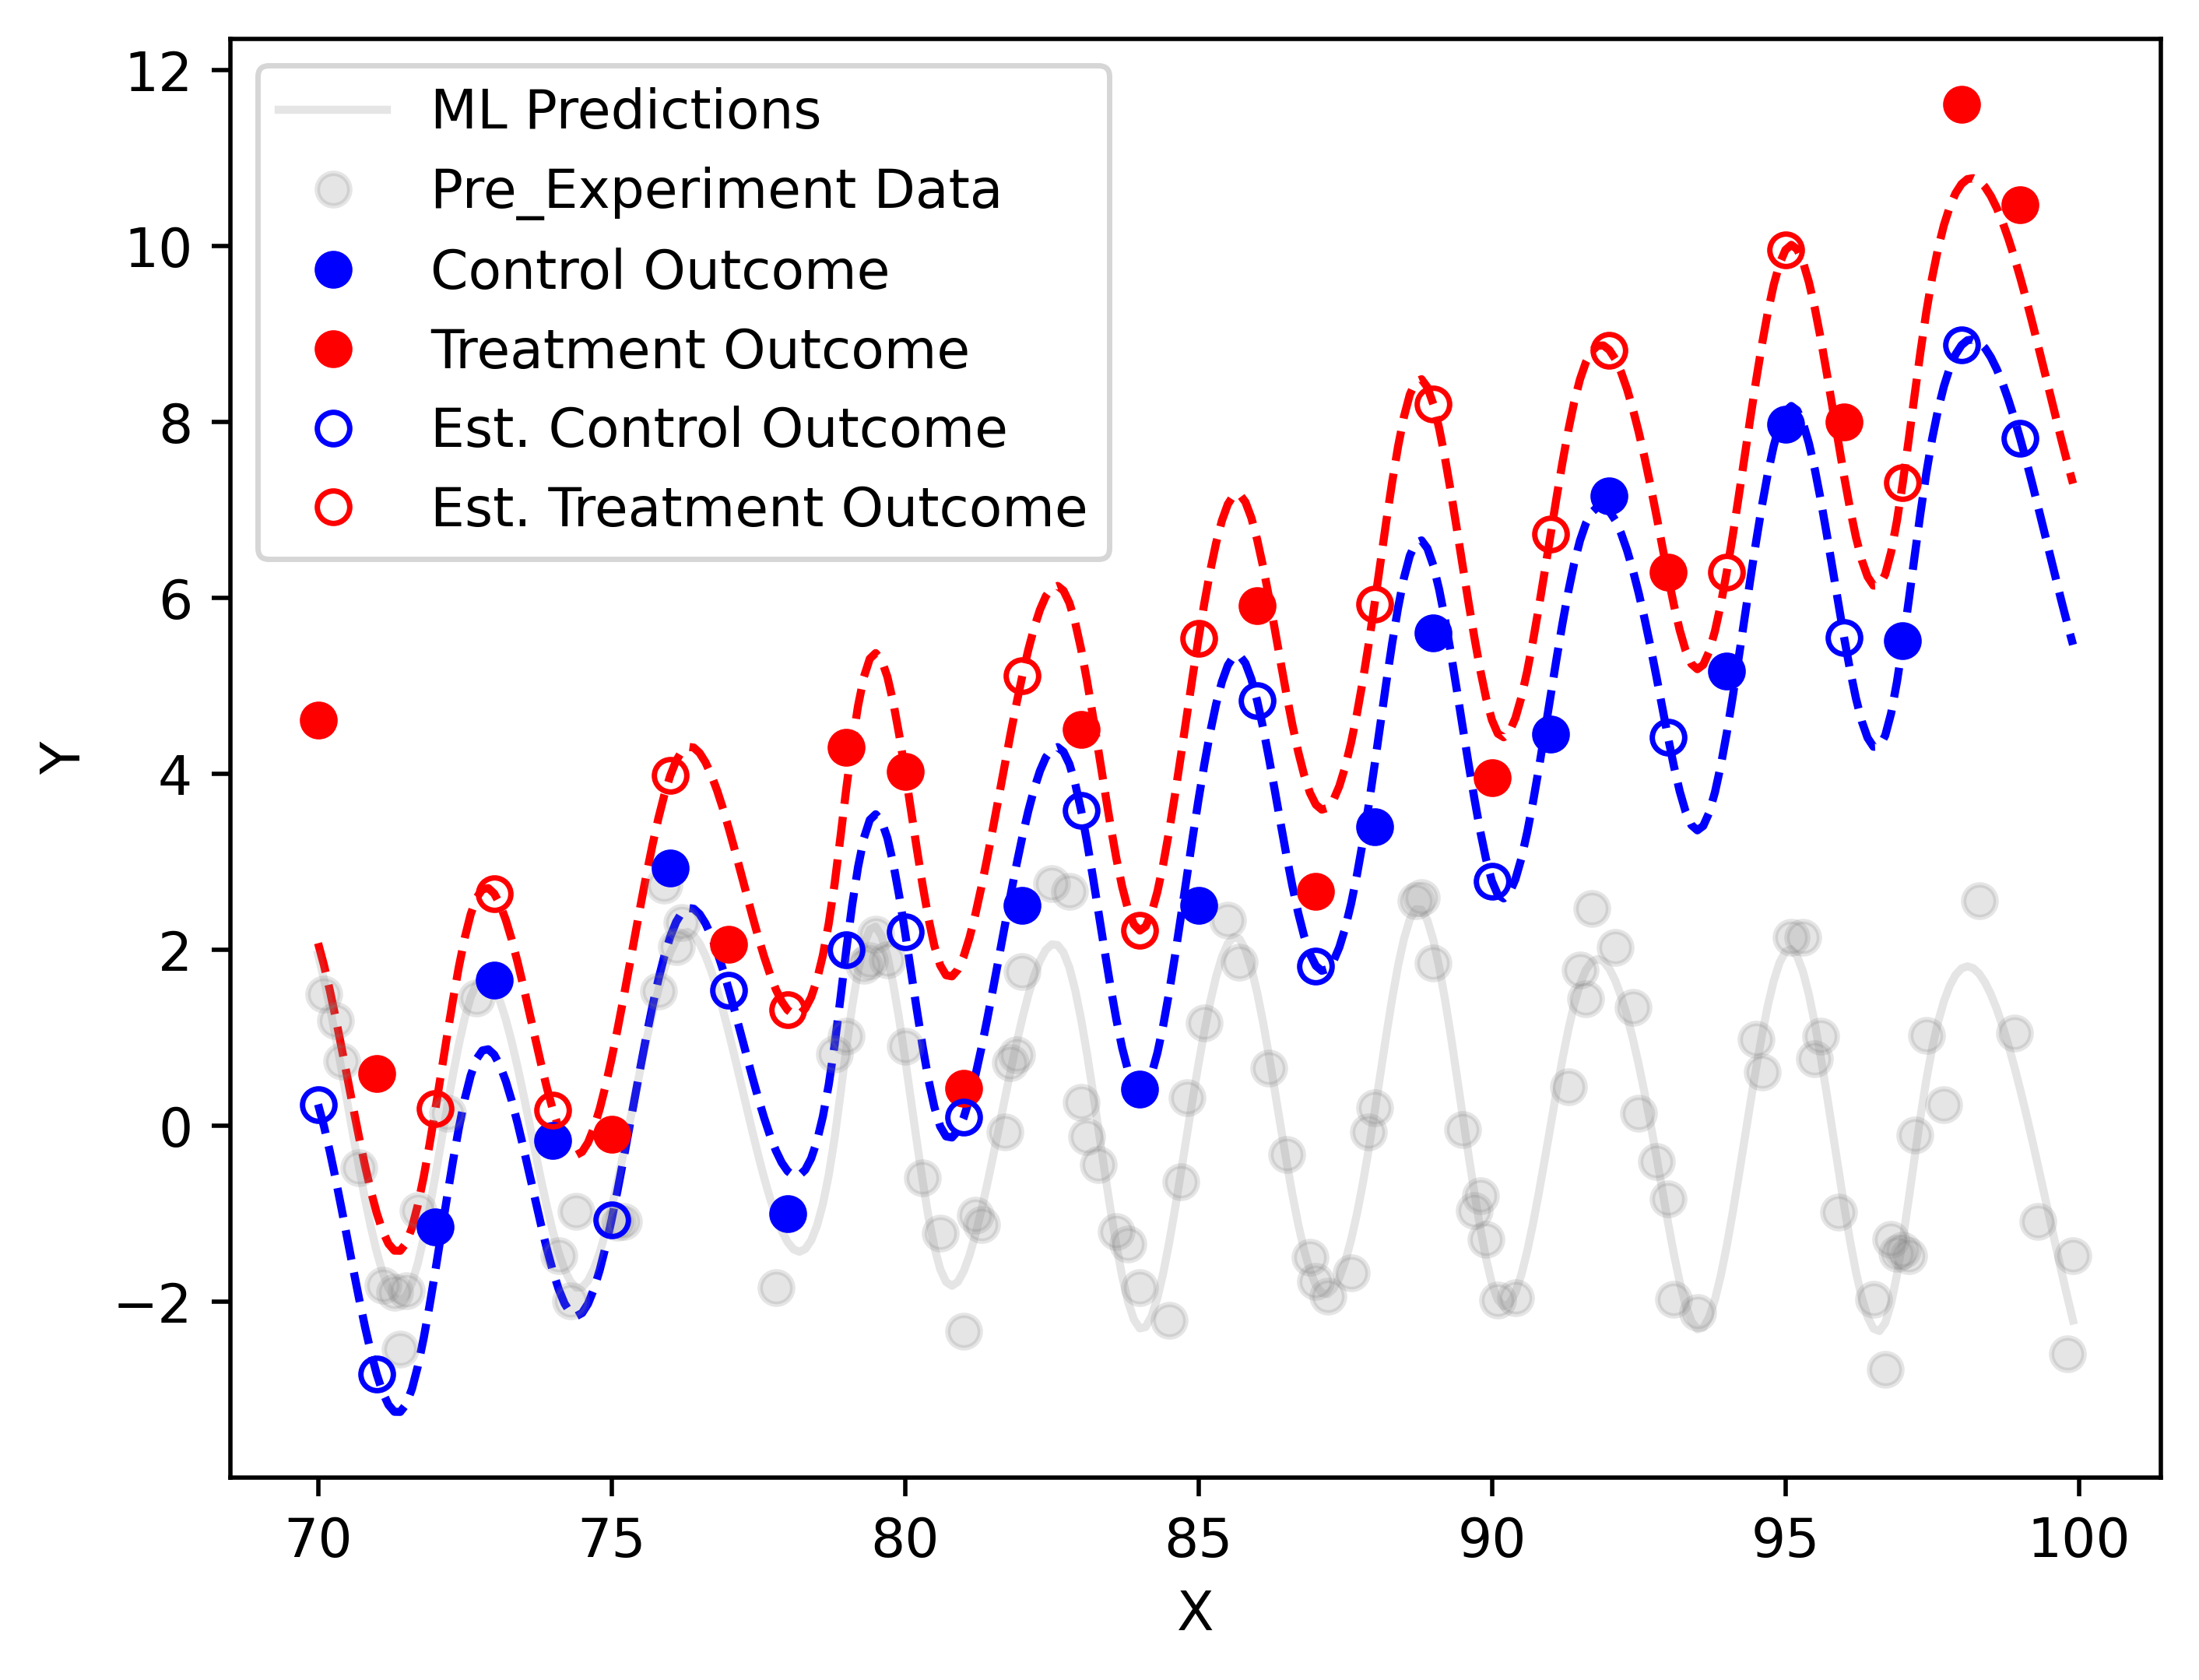

ATE:  1.8316145225428393 SE:  0.34267876727260815


In [17]:
# use the same control/treatment data as the linear model example
plt.figure(dpi=dpi)
np.random.seed(1)
random.seed(1)
x = np.arange(70,100,1)
n = len(x)
error = np.random.normal(0,1,n)
y = exp_data(x)
te = 2
control_idx = random.sample(range(n),n//2)
treat_idx = list(set(range(n)).difference(control_idx))
control_idx.sort()
treat_idx.sort()
control_x = x[control_idx]
treat_x = x[treat_idx]
control_y = y[control_idx]
treat_y = y[treat_idx] + te
def pre_exp2(x):
    return 2*np.sin(x*2) + 0.01*((x - 70)**2)
def pre_exp3(x):
    return 2*np.sin(x*2)

x = np.arange(70,100,0.1)
#y = pre_exp(x)
#plt.plot(x,y, label = 'ML Predictions',color='grey')
x_pre = np.array(random.sample(list(np.arange(70,100,0.1)), 100))
x_pre.sort()
y_pre = pre_exp3(x_pre) + np.random.normal(0,1,len(x_pre)) * 0.5
tck = splrep(x_pre, y_pre, s=20)

treat_pred = BSpline(*tck)(treat_x)
control_pred = BSpline(*tck)(control_x)

treatxvar = np.var(treat_x)
controlxvar = np.var(control_x)
control_r = control_y - control_pred
treat_r = treat_y - treat_pred
treatxcov = np.cov(treat_x, treat_r)[0,1]
controlxcov = np.cov(control_x, control_r)[0,1]
beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
alpha1 = np.mean(treat_r) - np.mean(treat_x)*beta
alpha0 = np.mean(control_r) - np.mean(control_x)*beta

x = np.arange(70,100,0.1)
treatline = BSpline(*tck)(x) + alpha1 + x * beta
controlline = BSpline(*tck)(x) + alpha0 + x * beta
plt.plot(x,treatline, color='red',linestyle='--')
plt.plot(x,controlline, color='blue',linestyle='--')
plt.plot(x,BSpline(*tck)(x), label = 'ML Predictions',color='grey',alpha=0.2)
plt.plot(x_pre, y_pre, 'o',color='grey',label="Pre_Experiment Data",alpha=0.2)
plt.plot(control_x, control_y, 'o', color = 'blue', label='Control Outcome')
plt.plot(treat_x, treat_y, 'o', color = 'red', label = 'Treatment Outcome')
plt.plot(treat_x, alpha0 + treat_x * beta + BSpline(*tck)(treat_x),'o',fillstyle='none',color='blue',label='Est. Control Outcome')
plt.plot(control_x, alpha1 + control_x * beta + BSpline(*tck)(control_x),'o',fillstyle='none',color='red',label='Est. Treatment Outcome')
plt.ylabel("Y")
plt.xlabel("X")
plt.legend(loc=2)
plt.savefig("plots/sec2_cf.png")
plt.show()
ATE = alpha1 - alpha0
SE = (np.var(treat_y - BSpline(*tck)(treat_x) - treat_x * beta)/len(treat_y) + np.var(control_y - BSpline(*tck)(control_x) - control_x * beta)/len(control_y))**0.5
print("ATE: ", ATE, "SE: ", SE)

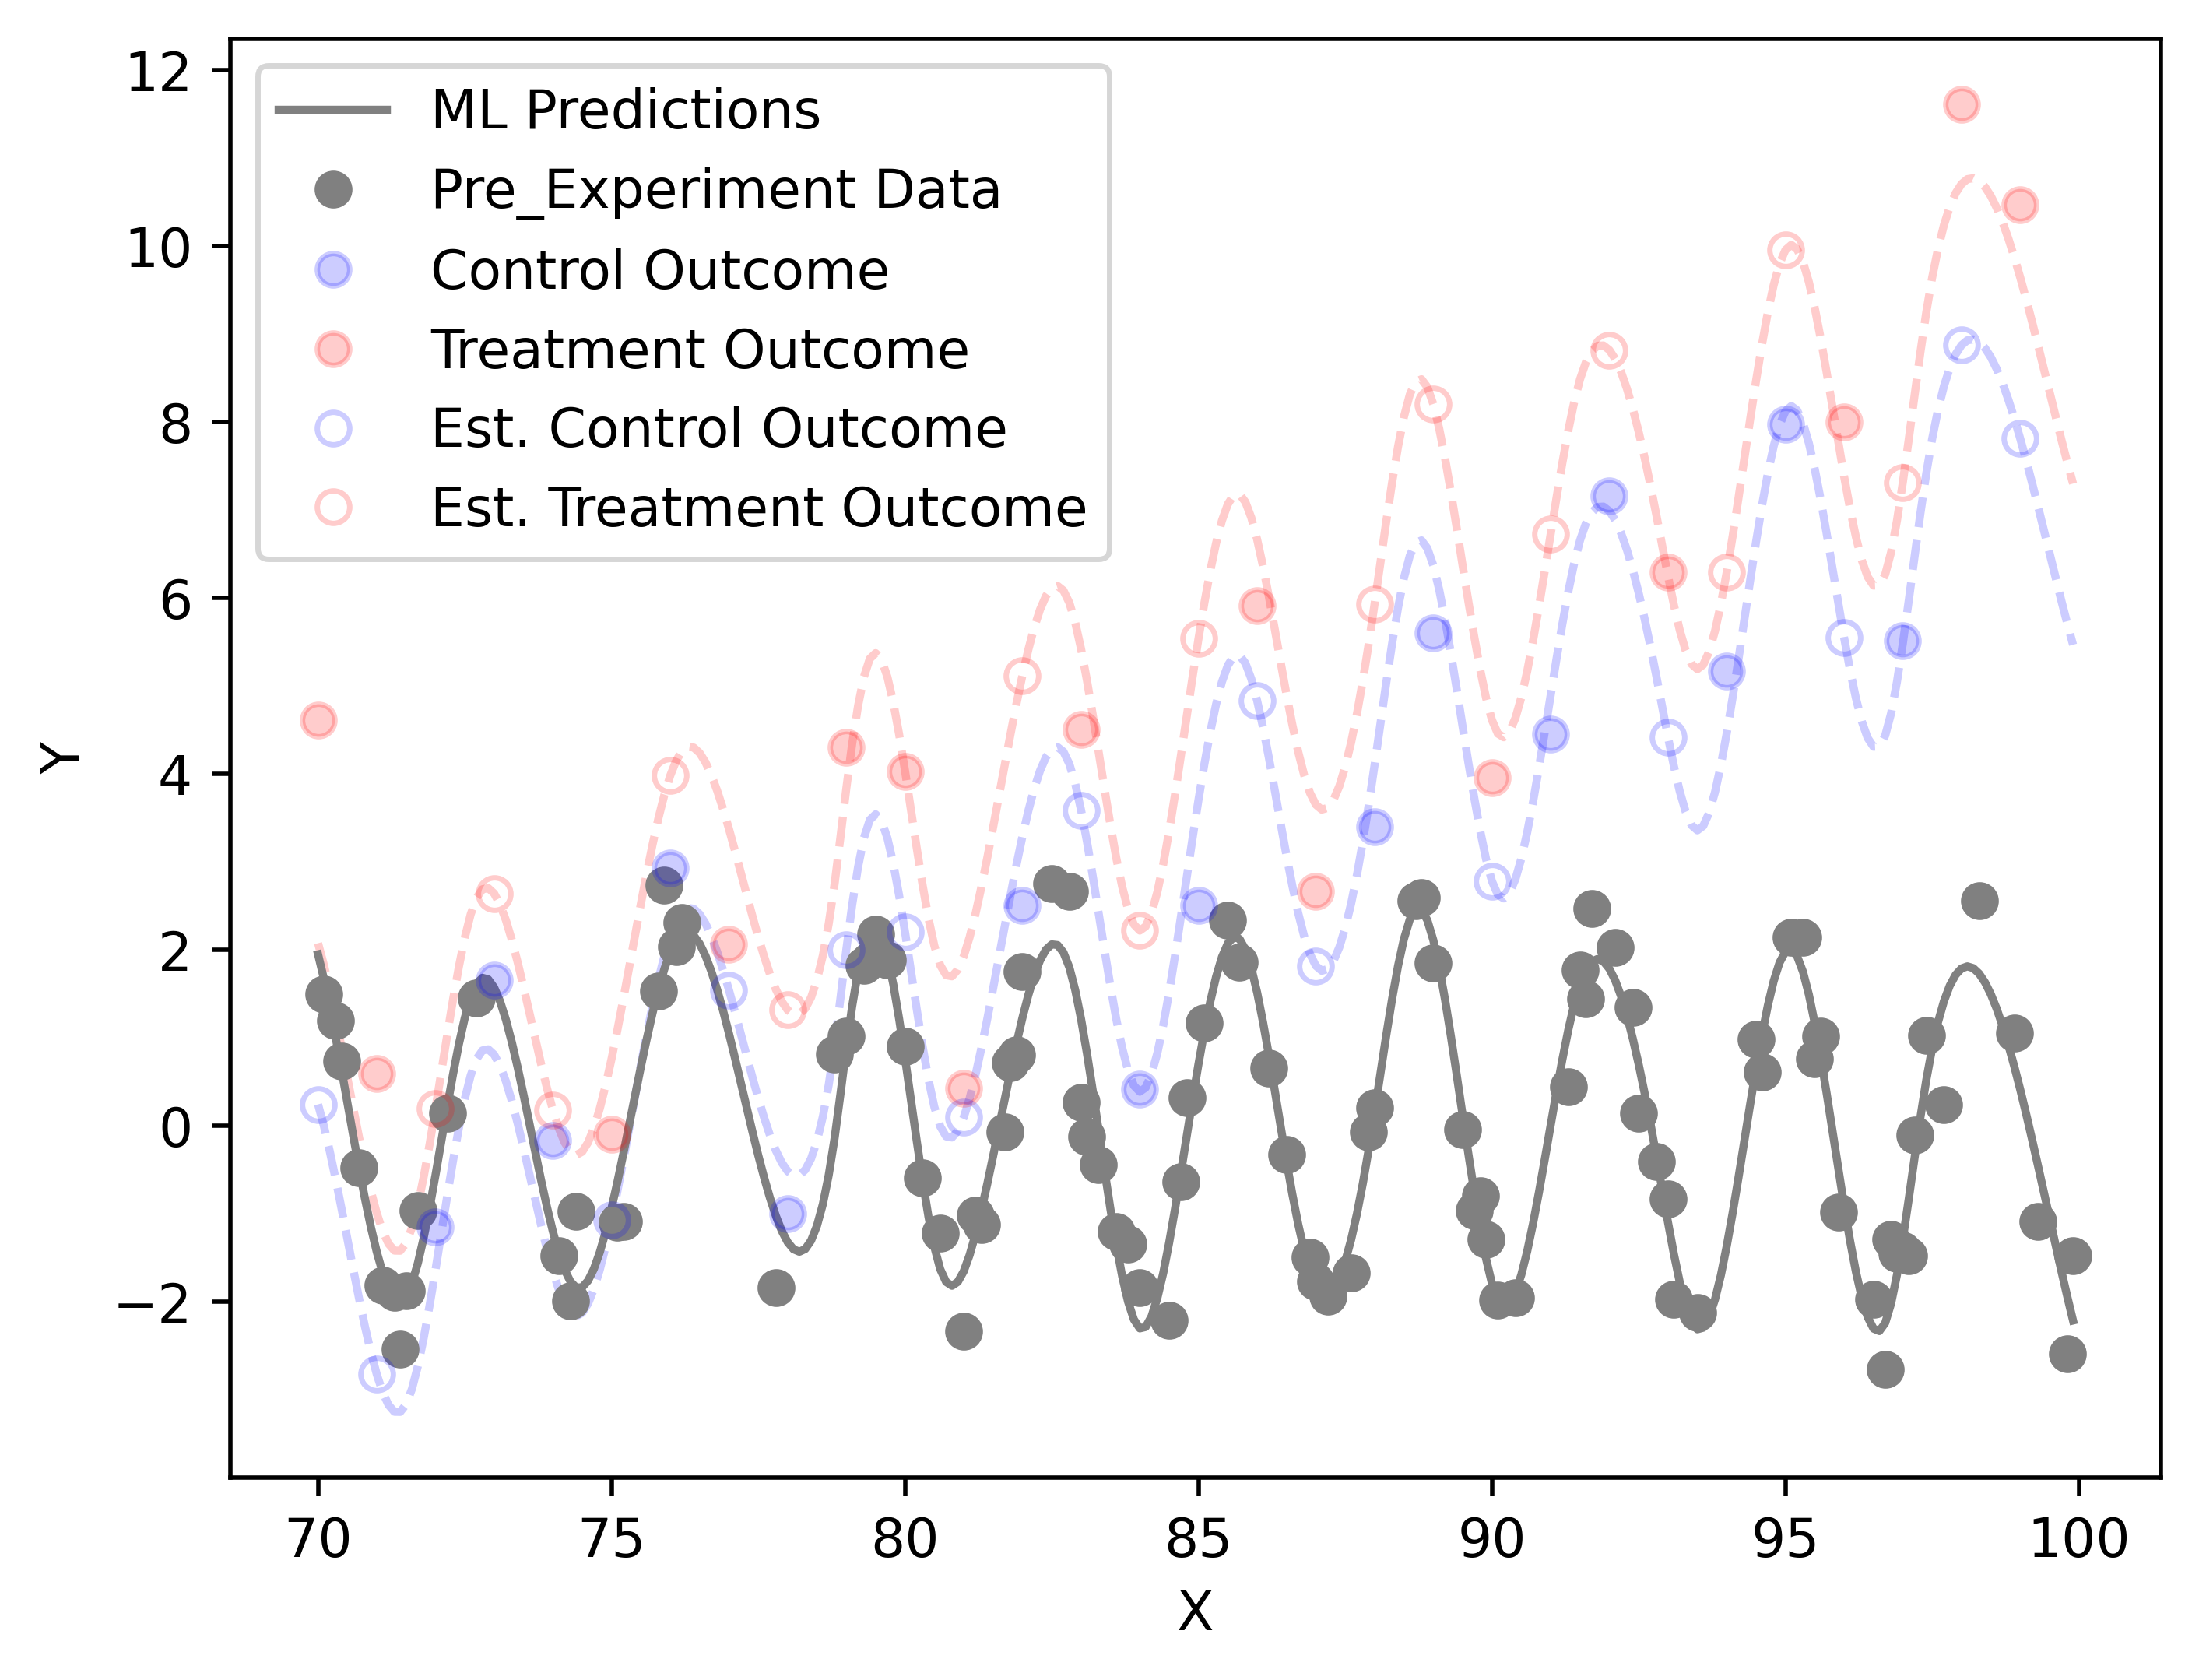

In [18]:
plt.figure(dpi=dpi)
plt.plot(x,treatline, color='red',linestyle='--',alpha=0.2)
plt.plot(x,controlline, color='blue',linestyle='--',alpha=0.2)
plt.plot(x,BSpline(*tck)(x), label = 'ML Predictions',color='grey',alpha=1)
plt.plot(x_pre, y_pre, 'o',color='grey',label="Pre_Experiment Data",alpha=1)
plt.plot(control_x, control_y, 'o', color = 'blue', label='Control Outcome',alpha=0.2)
plt.plot(treat_x, treat_y, 'o', color = 'red', label = 'Treatment Outcome',alpha=0.2)
plt.plot(treat_x, alpha0 + treat_x * beta + BSpline(*tck)(treat_x),'o',fillstyle='none',color='blue',label='Est. Control Outcome',alpha=0.2)
plt.plot(control_x, alpha1 + control_x * beta + BSpline(*tck)(control_x),'o',fillstyle='none',color='red',label='Est. Treatment Outcome',alpha=0.2)
plt.ylabel("Y")
plt.xlabel("X")
plt.legend(loc=2)
plt.savefig("plots/sec2_preexp.png")

In [26]:
a = np.hstack([control_y, treat_y])
b = np.hstack([BSpline(*tck)(control_x),BSpline(*tck)(treat_x)])
np.corrcoef(a,b)


array([[1.        , 0.43571237],
       [0.43571237, 1.        ]])

In [19]:
np.random.seed(1)
random.seed(1)
sim_num = 1000
sample_sizes = {1: 10, 2: 40, 3:80}
res = {}
# define the original x and y (without treatment)
x = np.arange(70,100,1)
n = len(x)
error = np.random.normal(0,1,n)
y = exp_data(x)
te = 2
for key in sample_sizes:
    temp = []
    n0 = sample_sizes[key]
    n1 = sample_sizes[key]
    for i in range(sim_num):
        #control_idx = random.sample(range(n),n//2)
        #treat_idx = list(set(range(n)).difference(control_idx))
        # or if with replacement
        control_idx = random.choices(range(n), k=n0)
        treat_idx = random.choices(range(n), k=n1)
        control_idx.sort()
        treat_idx.sort()
        control_x = x[control_idx]
        treat_x = x[treat_idx]
        control_y = y[control_idx]
        treat_y = y[treat_idx] + te

        # perform difference in means
        two_est = np.mean(treat_y) - np.mean(control_y)
        two_se = (np.var(treat_y,ddof=1)/n1 + np.var(control_y,ddof=1)/n0)**0.5

        # perform counterfactual estimator with regression
        treatxvar = np.var(treat_x)
        controlxvar = np.var(control_x)
        treatxcov = np.cov(treat_x, treat_y)[0,1]
        controlxcov = np.cov(control_x, control_y)[0,1]
        beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
        alpha1 = np.mean(treat_y) - np.mean(treat_x)*beta
        alpha0 = np.mean(control_y) - np.mean(control_x)*beta
        reg_est = alpha1 - alpha0
        reg_se = (np.var(treat_y - treat_x * beta,ddof=1)/len(treat_y) + np.var(control_y - control_x * beta,ddof=1)/len(control_y))**0.5
        
        # perform counterfactual estimator with ML
        treat_preds = BSpline(*tck)(treat_x)
        control_preds = BSpline(*tck)(control_x)
        pred_alpha1 = np.mean(treat_y - treat_preds)
        pred_alpha0 = np.mean(control_y - control_preds)
        ml_est = pred_alpha1 - pred_alpha0
        ml_se = (np.var(treat_y - treat_preds,ddof=1)/len(treat_y) + np.var(control_y - control_preds,ddof=1)/len(control_y))**0.5
        
        # perform secondary linear adjustment to ML
        control_r = control_y - control_preds
        treat_r = treat_y - treat_preds
        treatxcovr = np.cov(treat_x, treat_r)[0,1]
        controlxcovr = np.cov(control_x, control_r)[0,1]
        beta_s = (treatxcovr + controlxcovr)/(treatxvar + controlxvar)
        alpha1_s = np.mean(treat_r) - np.mean(treat_x)*beta_s
        alpha0_s = np.mean(control_r) - np.mean(control_x)*beta_s
        s_est = alpha1_s - alpha0_s
        s_se = (np.var(treat_r - treat_x * beta_s,ddof=1)/len(treat_y) + np.var(control_r - control_x * beta_s,ddof=1)/len(control_y))**0.5

        temp.append([two_est, two_se, reg_est, reg_se, ml_est, ml_se, s_est, s_se])

    res[key] = pd.DataFrame(temp, columns = ['two_est','two_se','reg_est','reg_se','ml_est','ml_se','s_est','s_se'])

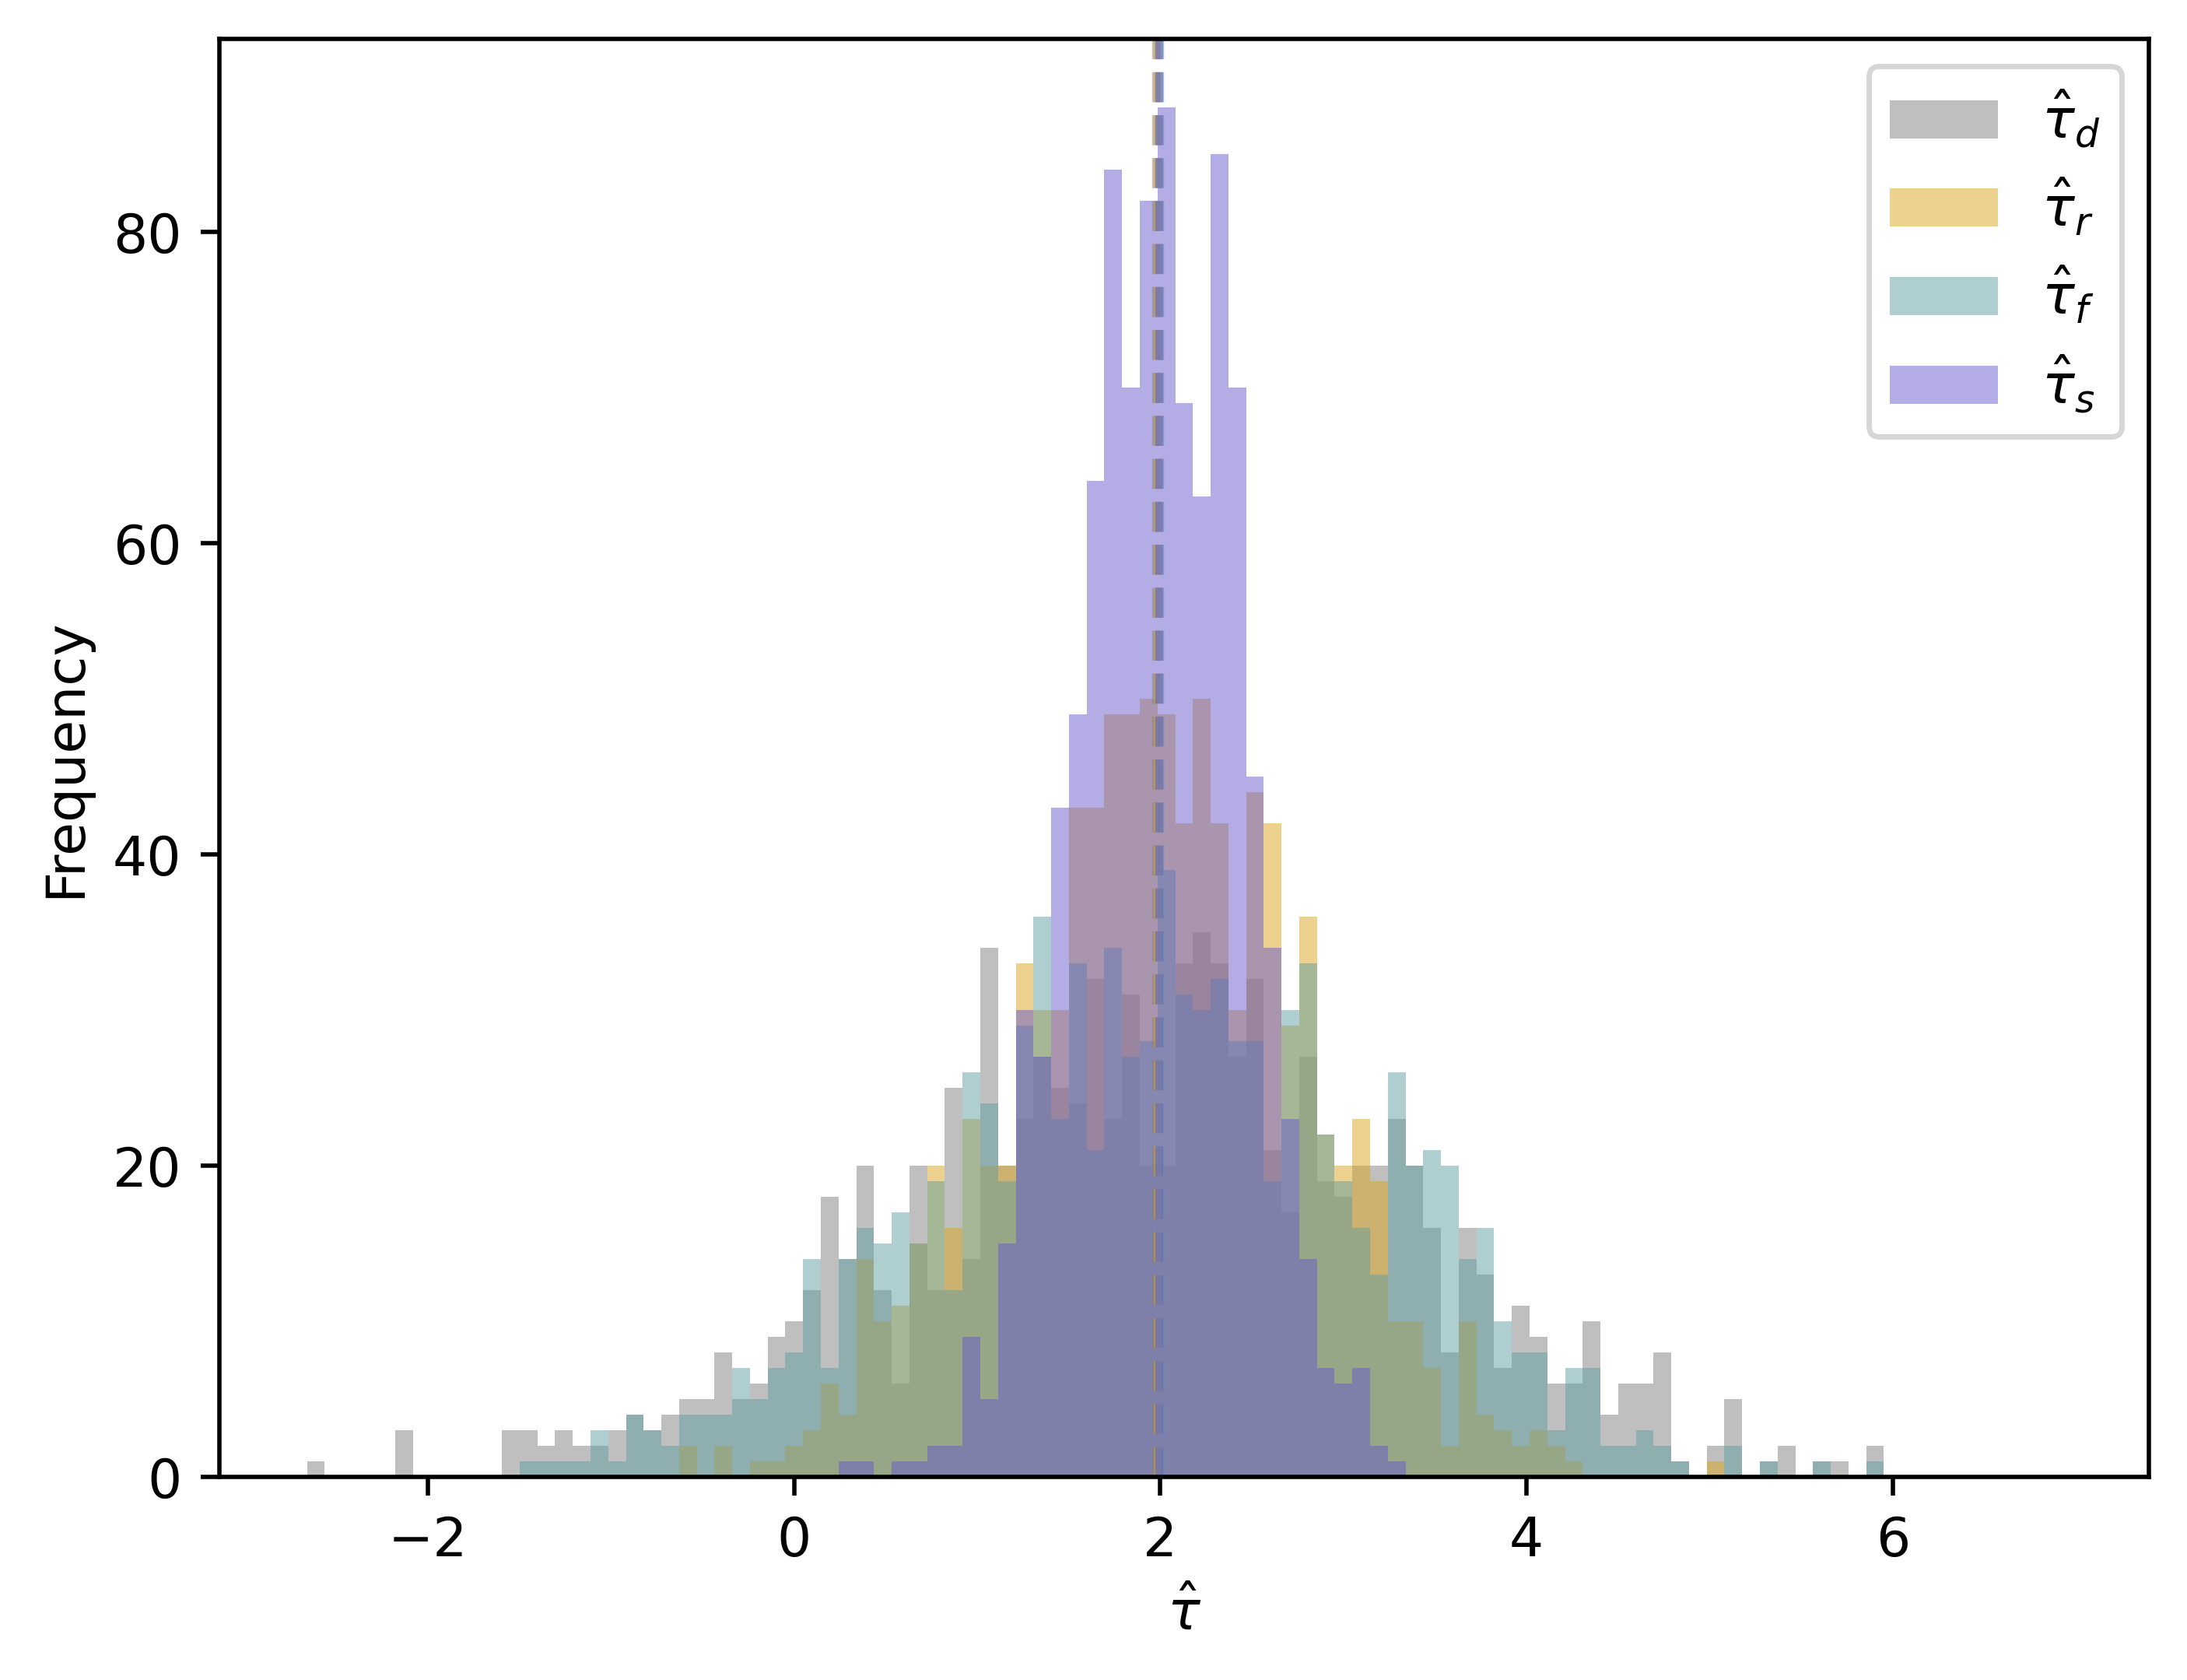

Sample size: 10 ATE_d: 1.9760411207348378 ATE_r: 1.9851764977982755 ATE_ml: 1.9974358956493021 ATE_s: 1.995100220247365


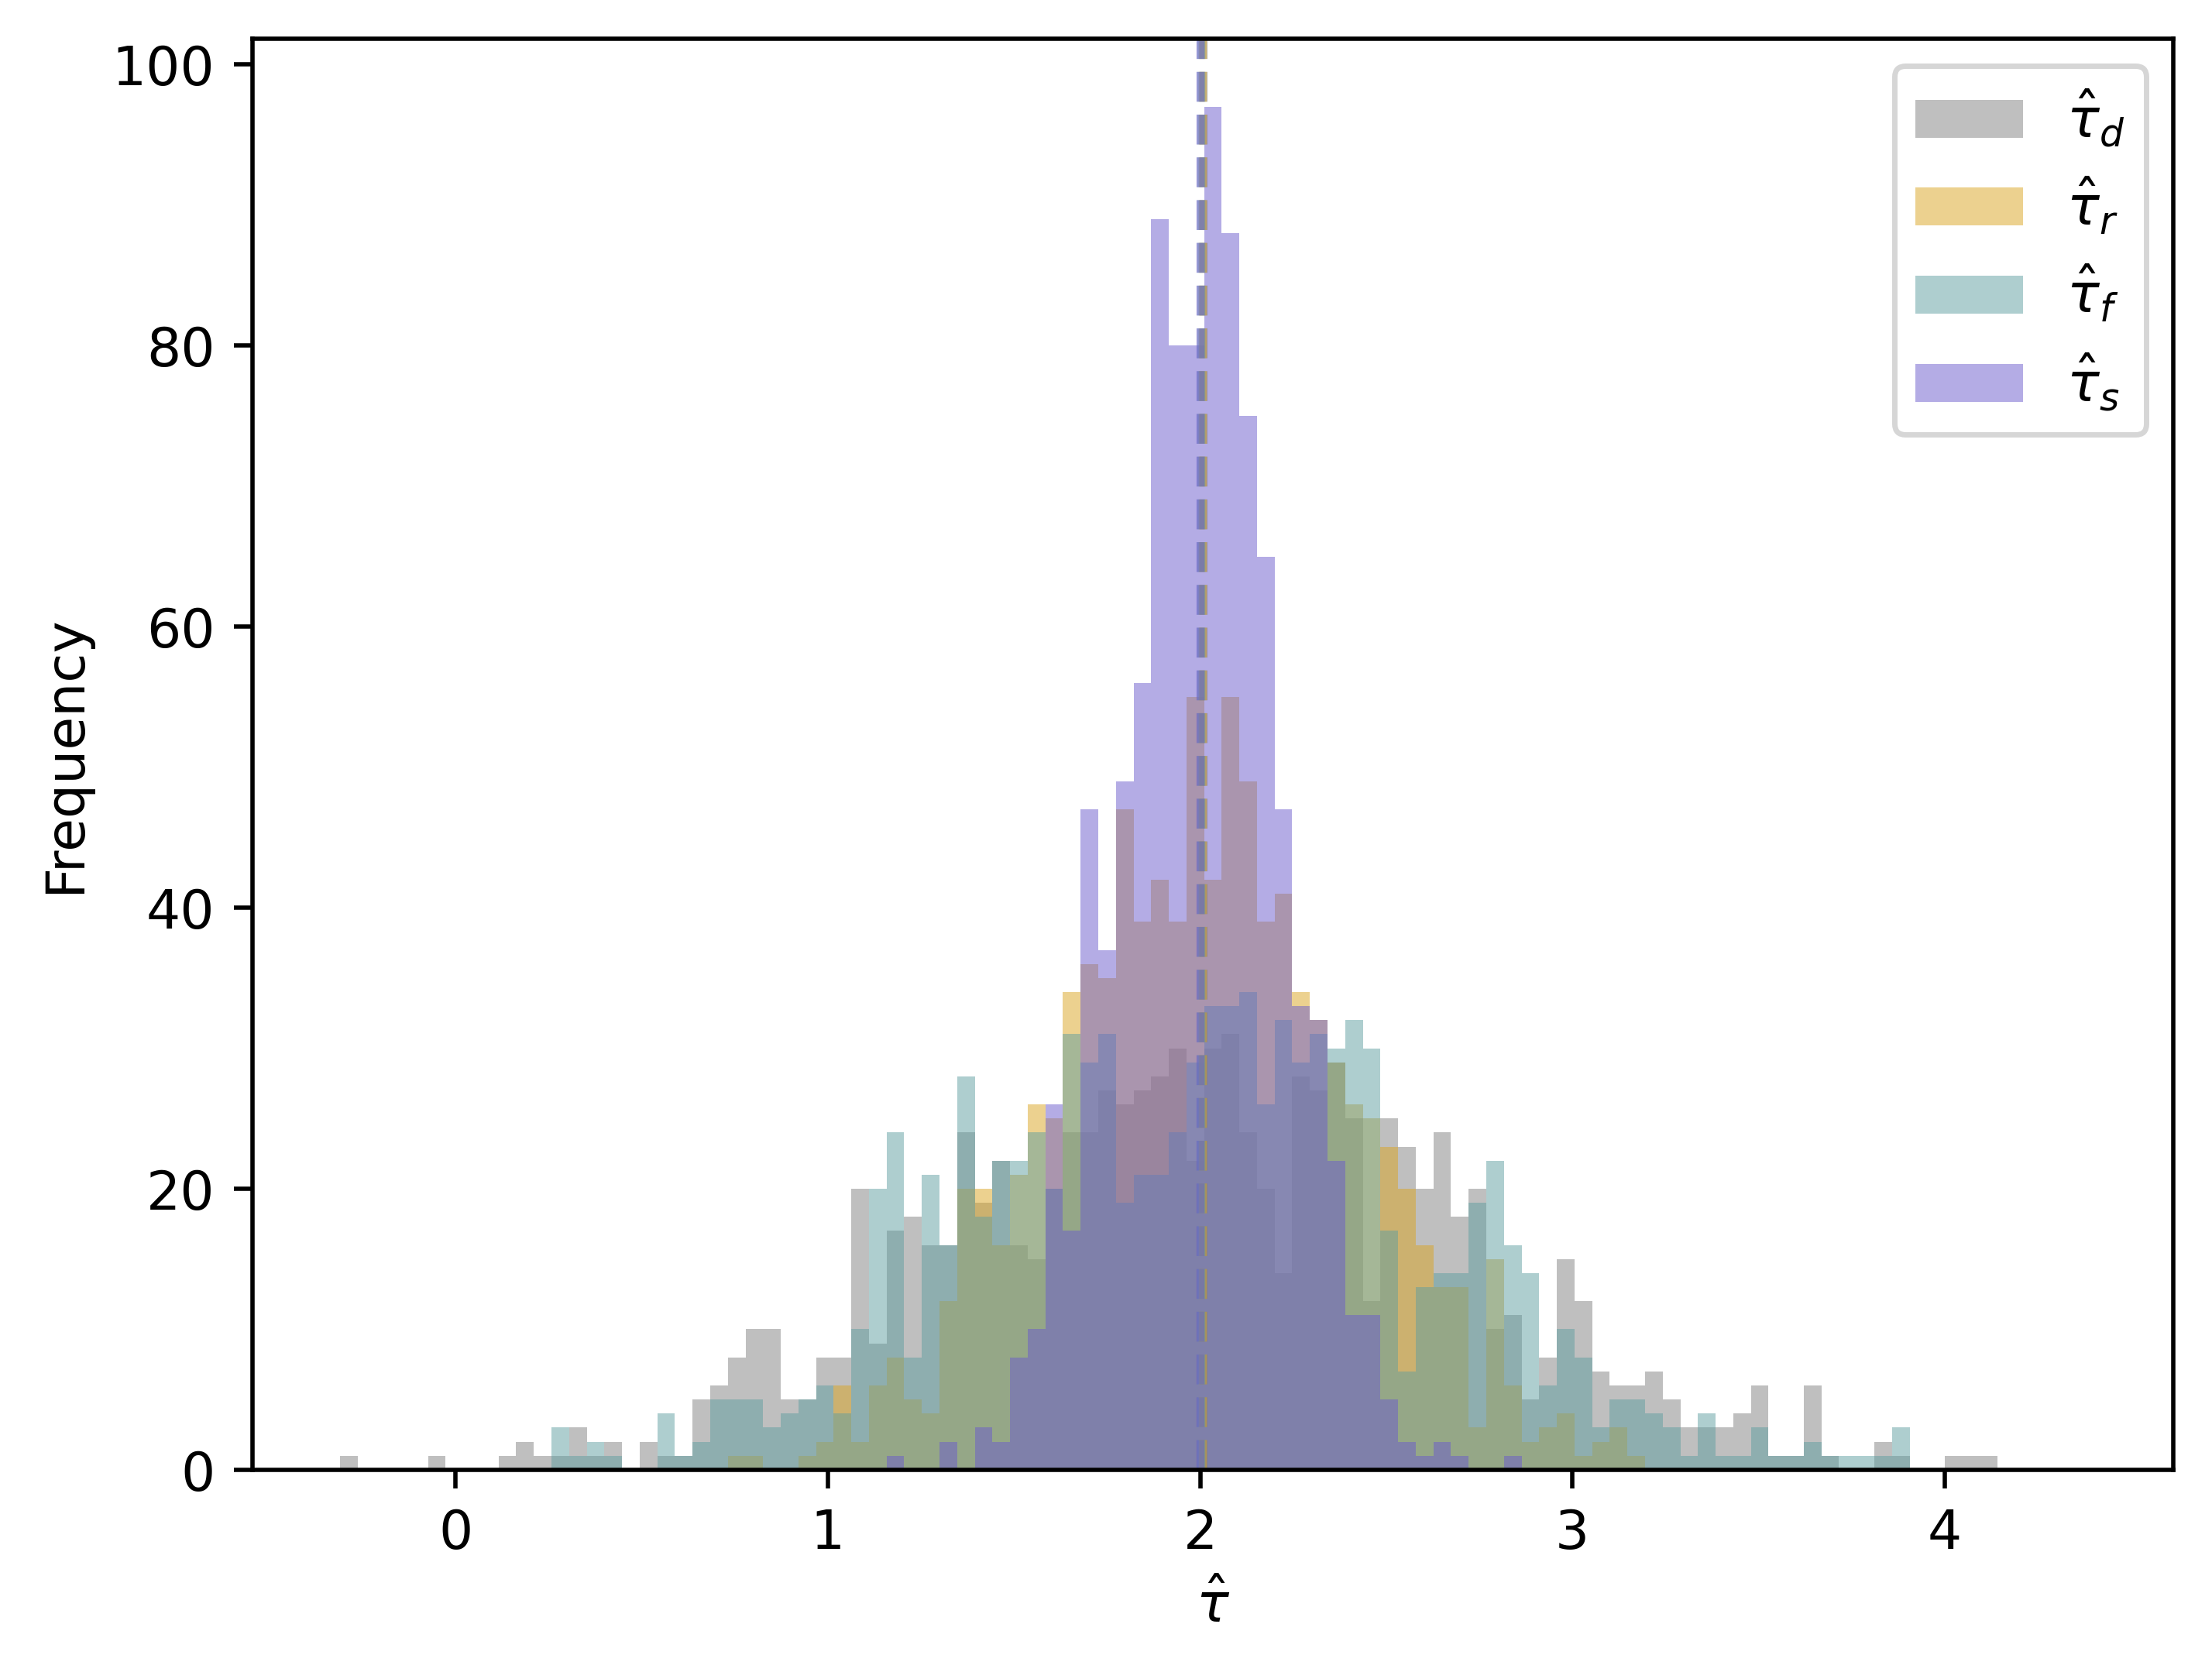

Sample size: 40 ATE_d: 2.0102915887934354 ATE_r: 2.007336601452813 ATE_ml: 2.003857350893002 ATE_s: 2.000409502654221


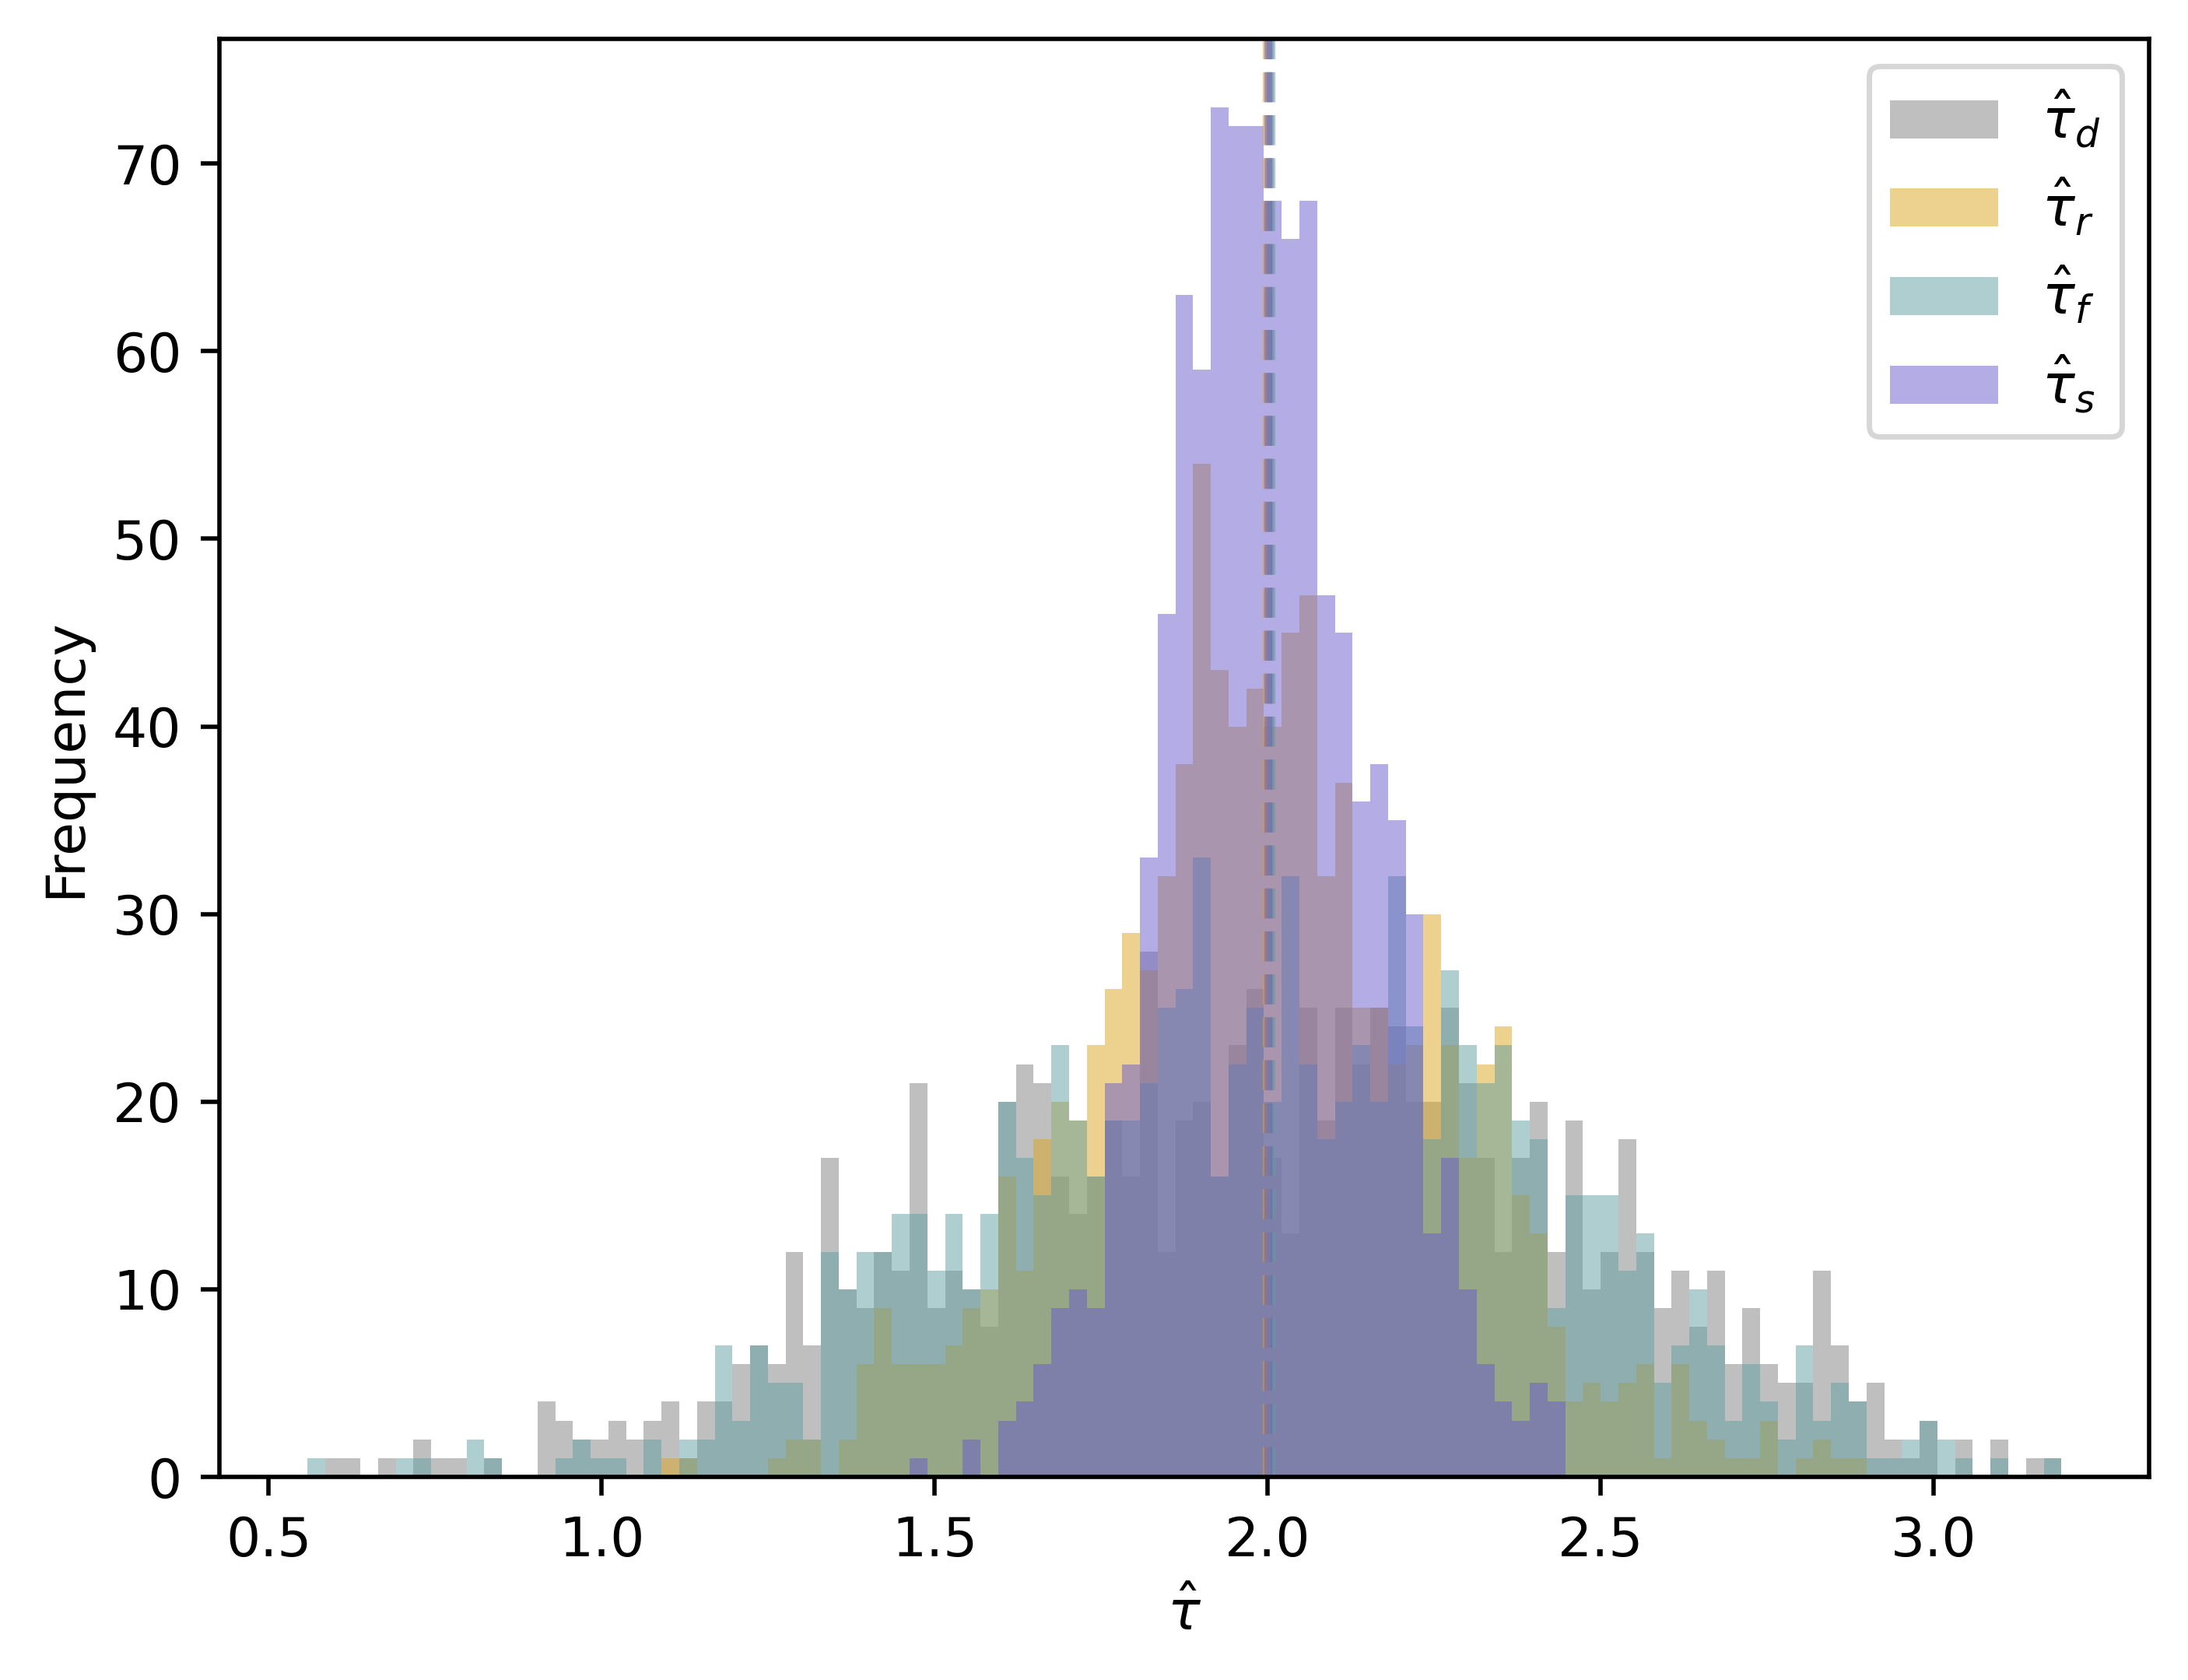

Sample size: 80 ATE_d: 2.003297441806425 ATE_r: 1.9983995110735167 ATE_ml: 2.0058631818829906 ATE_s: 2.000898438533901


In [20]:
for key in res:
    plt.figure(dpi=dpi)
    sim_res = res[key]
    # use this to first determine overall range, and manually set max and min with visual analysis
    bins_max = max(max(sim_res['two_est']),max(sim_res['reg_est']),max(sim_res['ml_est']),max(sim_res['s_est']))
    bins_min = min(min(sim_res['two_est']),min(sim_res['reg_est']),min(sim_res['ml_est']),min(sim_res['s_est']))
    #bins_max = 7
    #bins_min = -3
    bins_freq = 100
    bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
    plt.hist(sim_res['two_est'], bins = bins_range, color = colors['two'], label = r"$\hat{\tau}_d$", alpha=0.5)
    plt.hist(sim_res['reg_est'], bins = bins_range, color = colors['reg'], label=r"$\hat{\tau}_r$",alpha=0.5)
    plt.hist(sim_res['ml_est'], bins = bins_range, color = colors['ml'], label=r"$\hat{\tau}_{f}$",alpha=0.5)
    plt.hist(sim_res['s_est'], bins = bins_range, color = colors['mix'], label=r"$\hat{\tau}_{s}$",alpha=0.5)
    #plt.hist(sim_res['pair_est2'],bins=np.arange(-1,6,0.1), label='paired_est2',alpha=0.5)
    plt.axvline(np.mean(sim_res['two_est']), color = colors['two'], linestyle='--',alpha=0.5)
    plt.axvline(np.mean(sim_res['reg_est']), color = colors['reg'], linestyle='--',alpha=0.5)
    plt.axvline(np.mean(sim_res['ml_est']), color = colors['ml'], linestyle='--',alpha=0.5)
    plt.axvline(np.mean(sim_res['s_est']), color = colors['mix'], linestyle='--',alpha=0.5)
    plt.ylabel("Frequency")
    plt.xlabel(r"$\hat{\tau}$")
    plt.legend(loc=1)
    plt.savefig("plots/sec2_" + str(key) + "_ate.png")
    plt.show()
    print("Sample size:",sample_sizes[key], "ATE_d:", np.mean(sim_res['two_est']), "ATE_r:", 
          np.mean(sim_res['reg_est']),"ATE_ml:",np.mean(sim_res['ml_est']),"ATE_s:",np.mean(sim_res['s_est']))

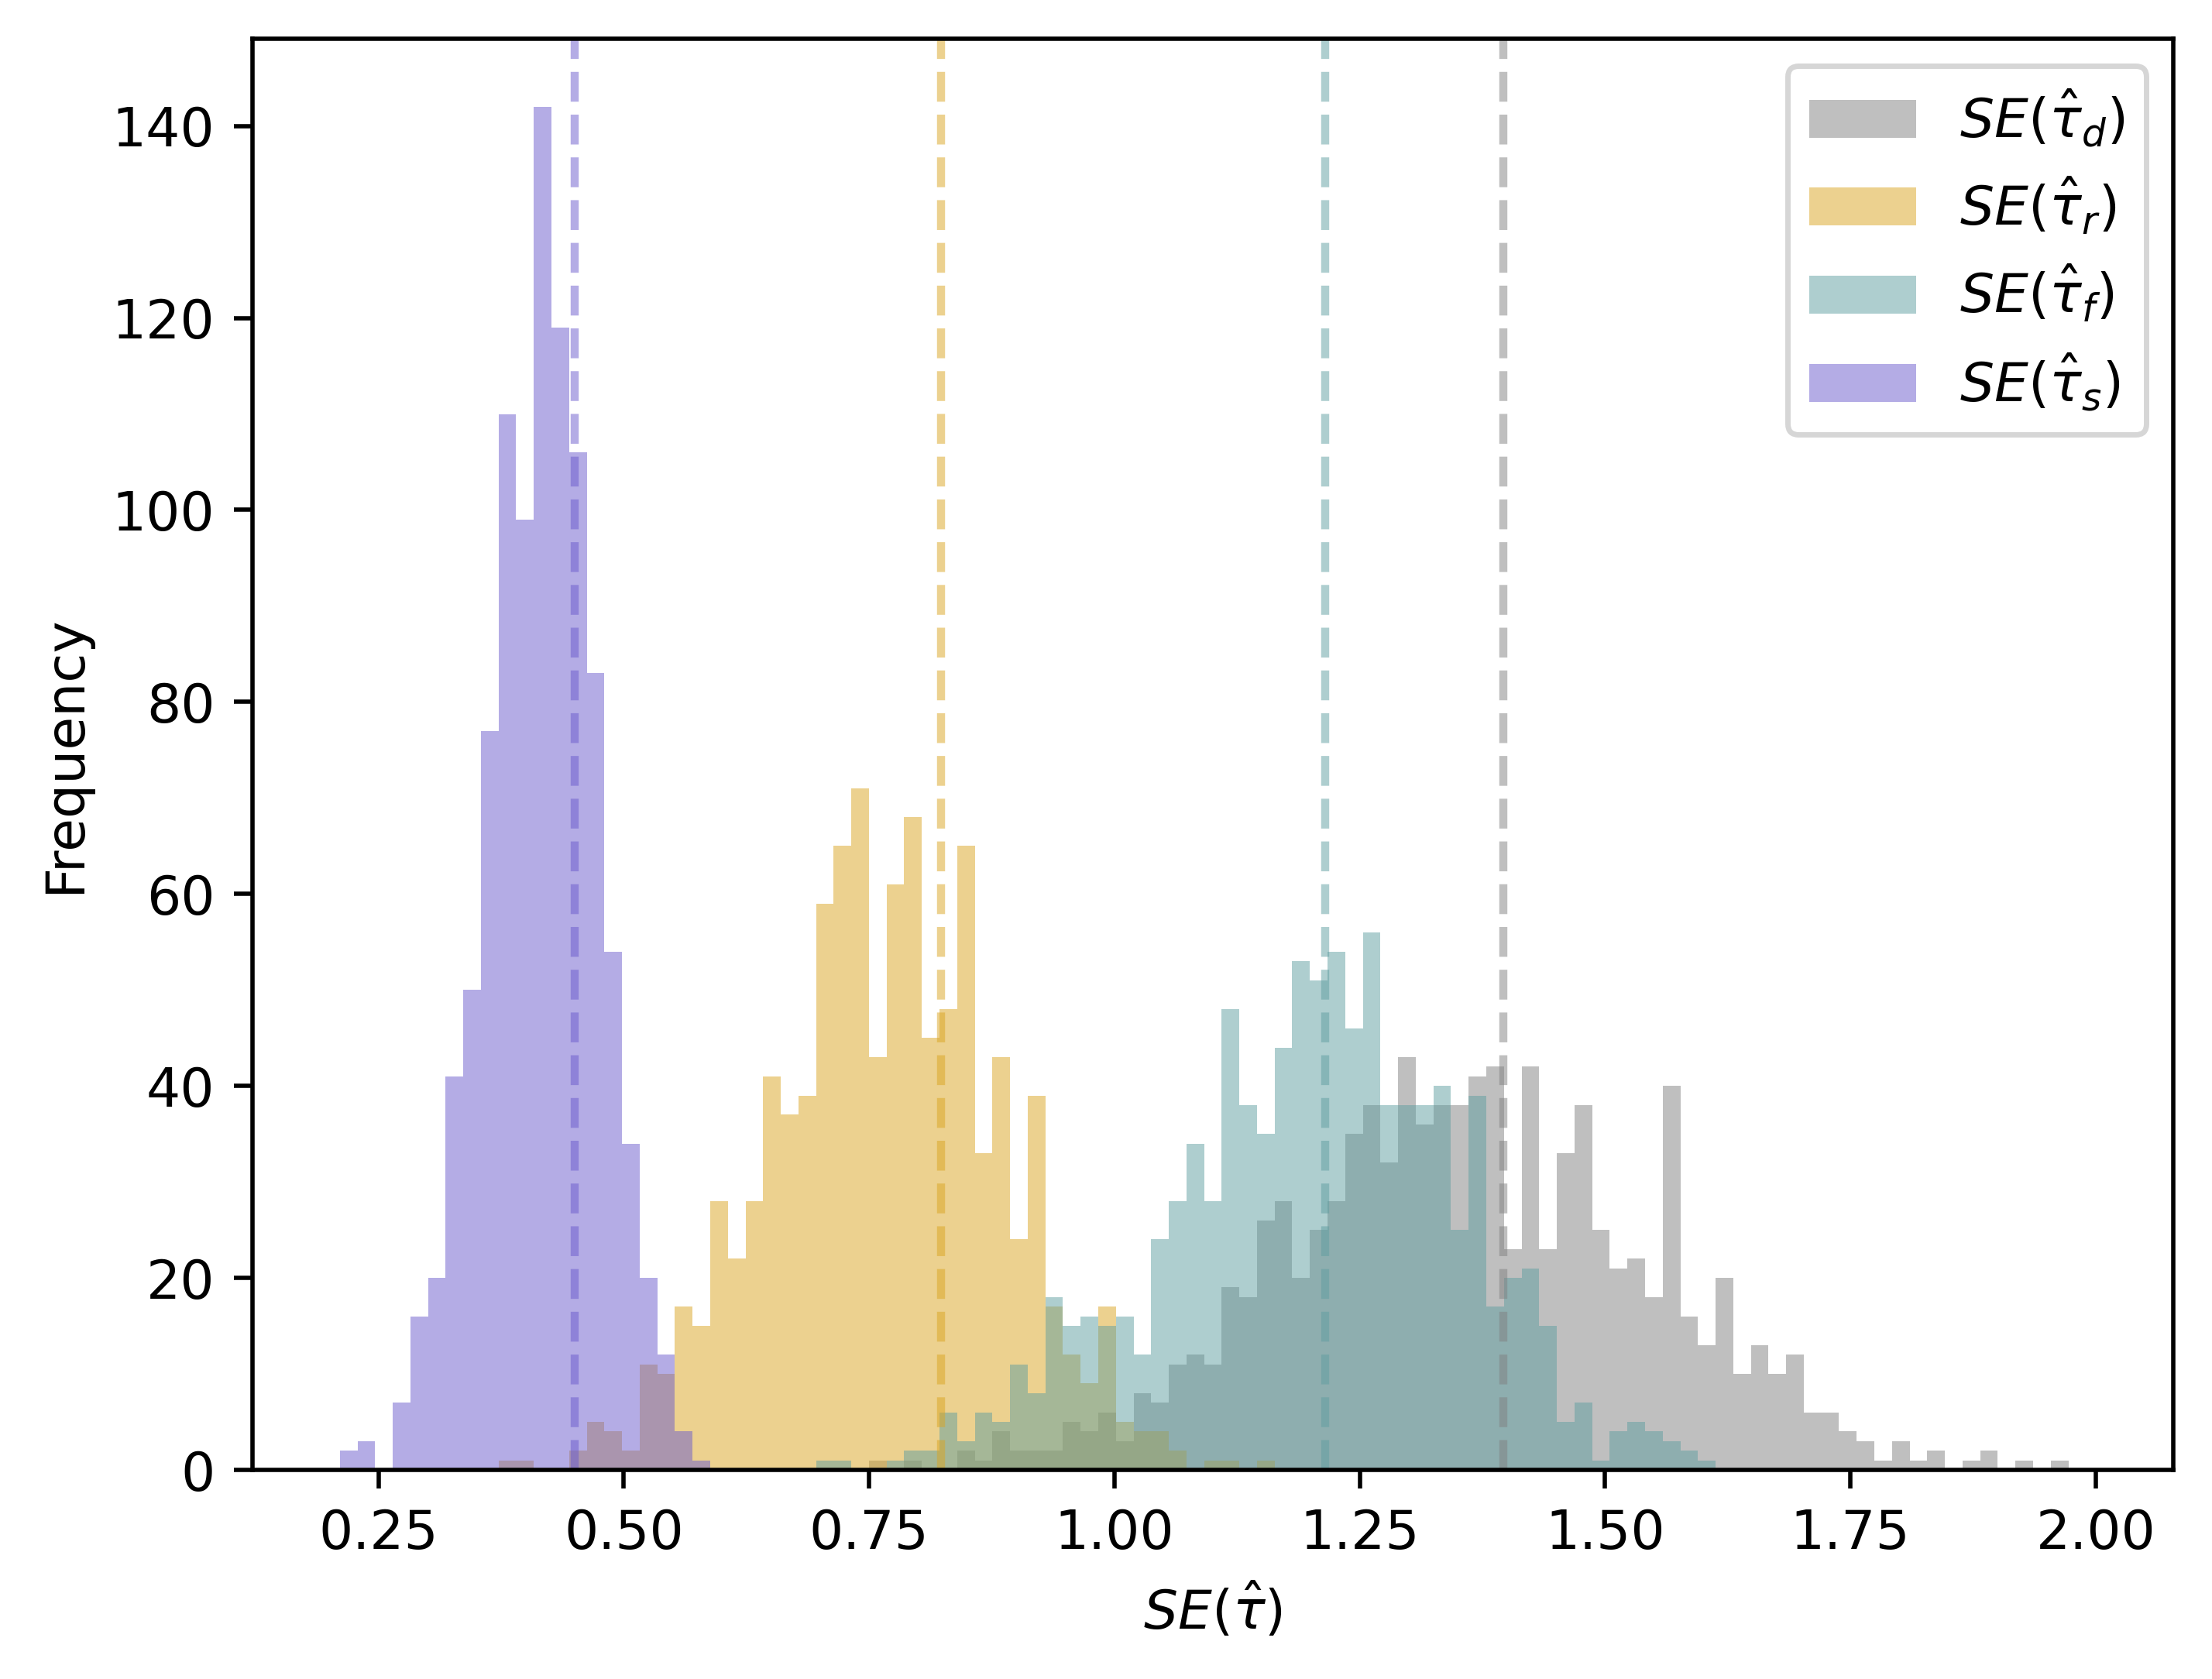

Std_d: 1.3971469144651147 Std_r: 0.8238463668835506 Std_ml:  1.2151663988922172 Std_s: 0.449748669408852 Var_red: 0.6780949342173981


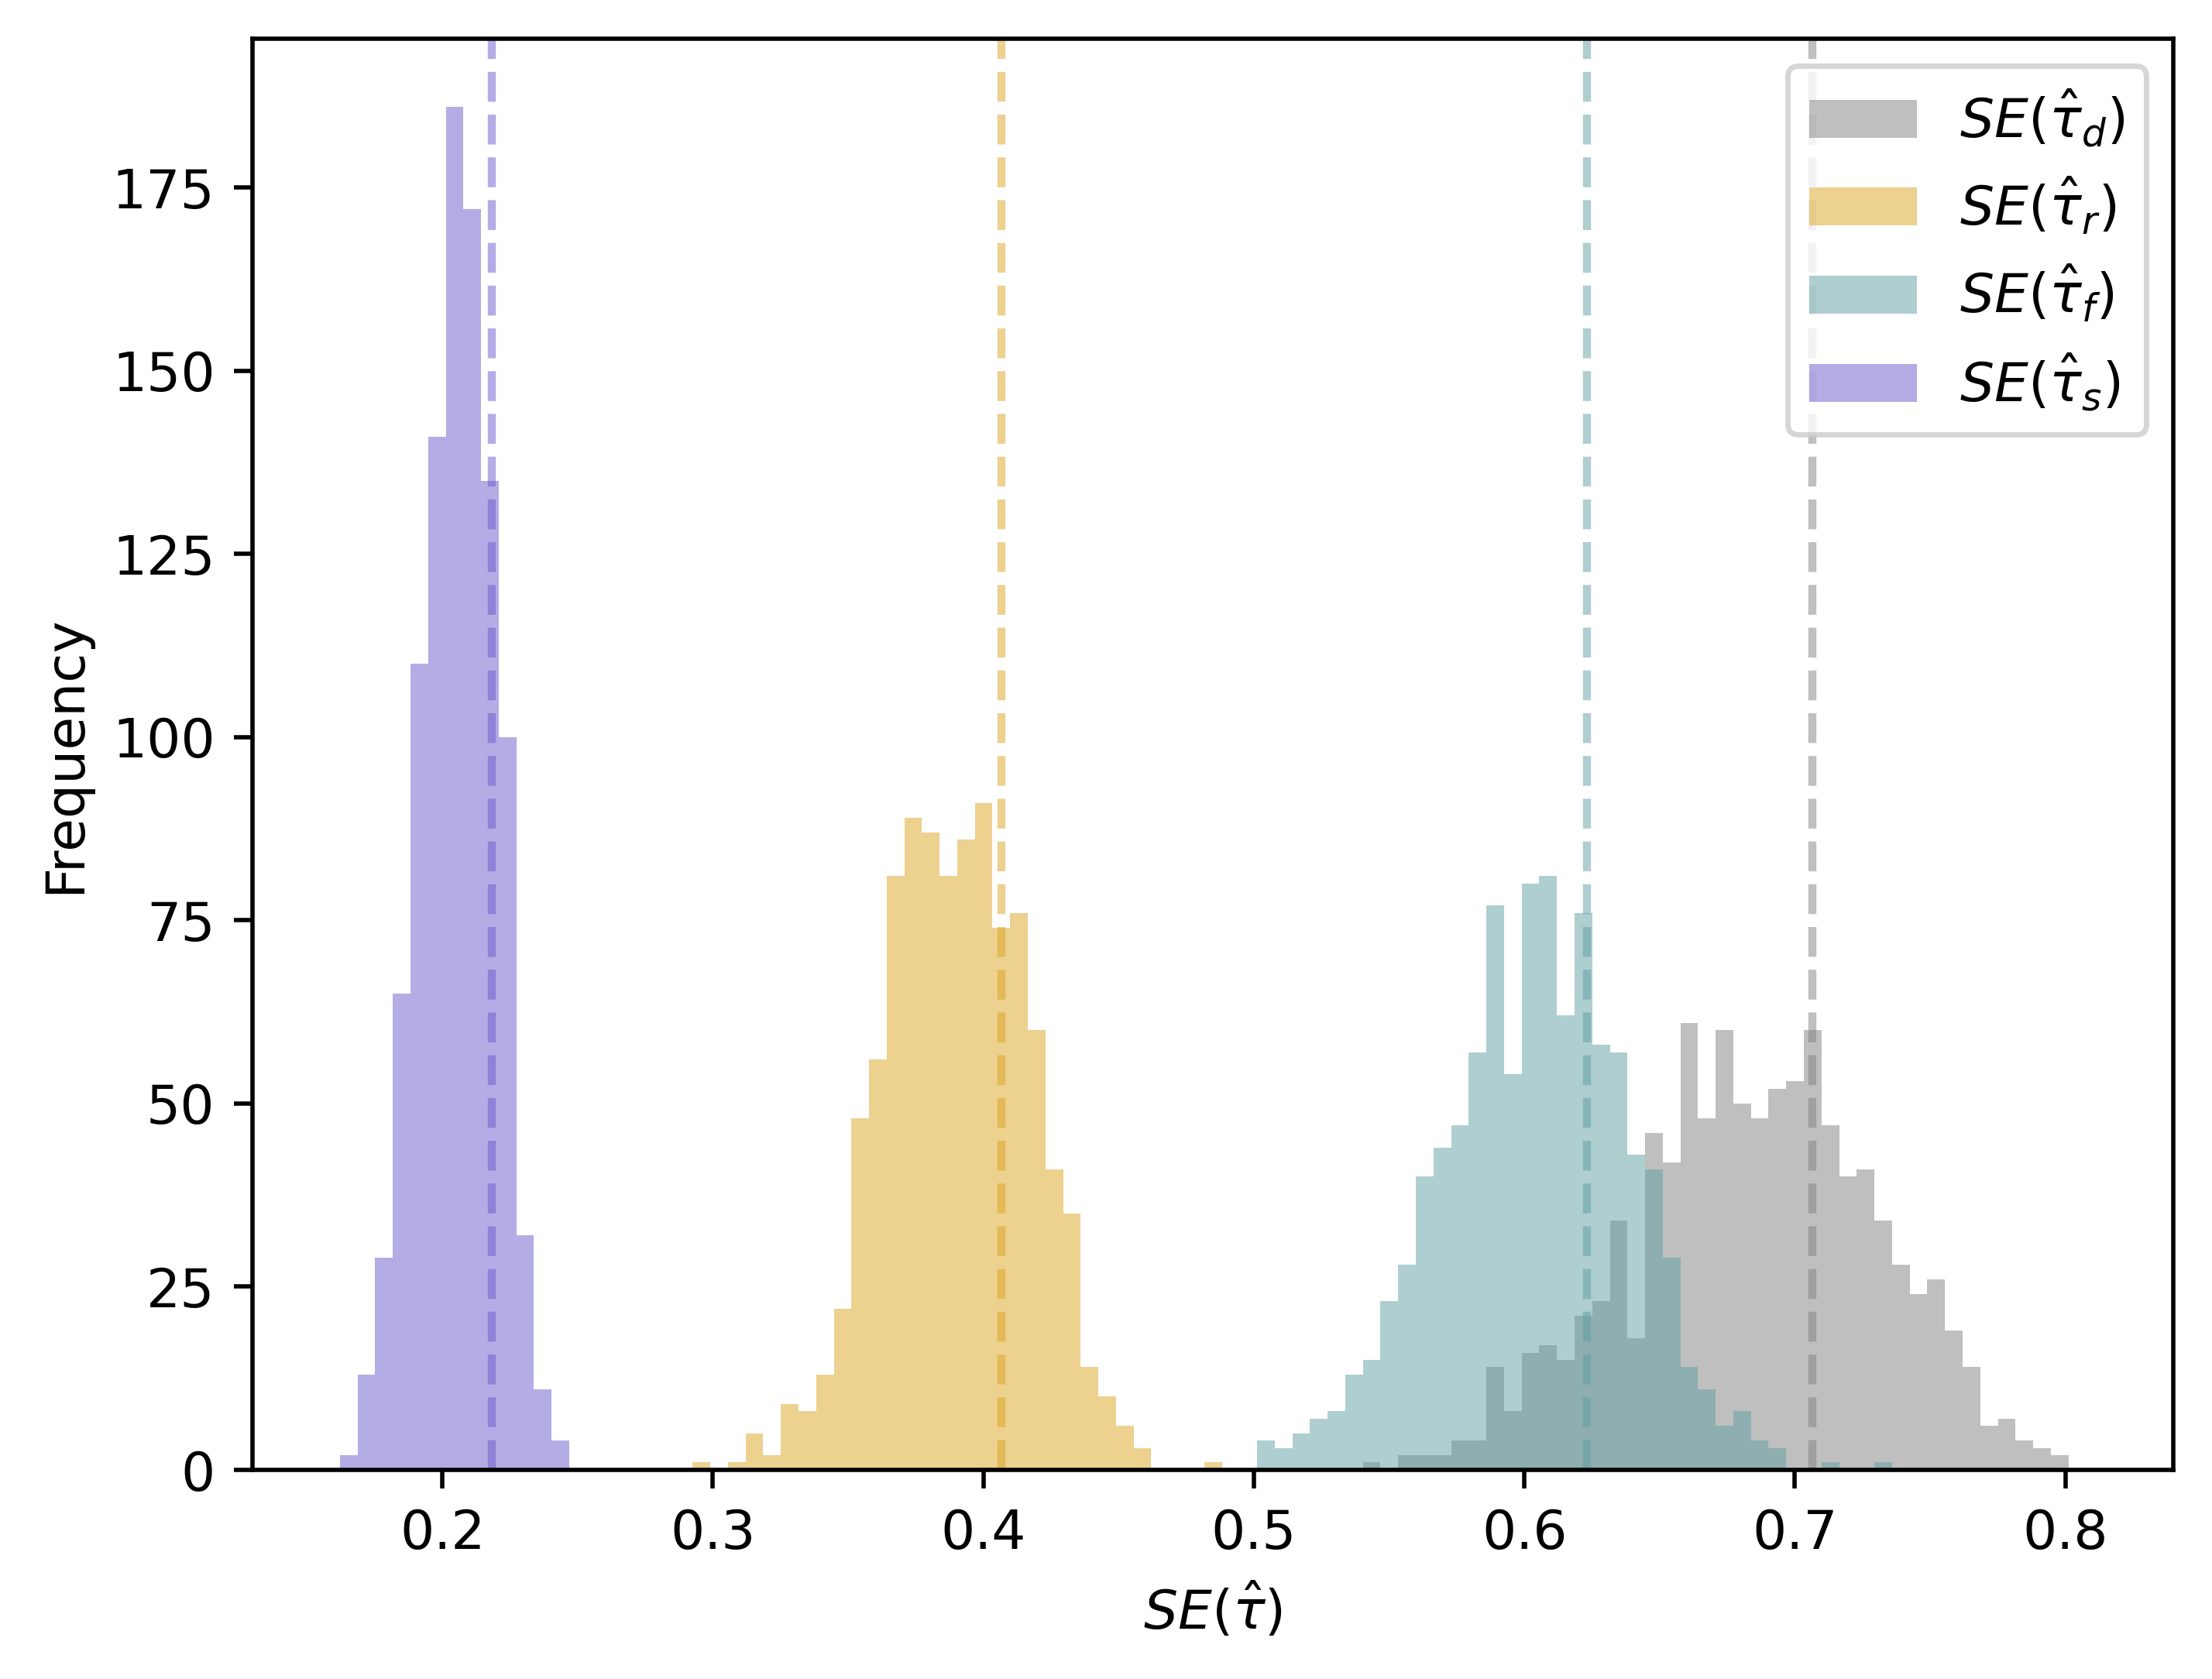

Std_d: 0.7068692647157091 Std_r: 0.40675158400232936 Std_ml:  0.6233156310727054 Std_s: 0.2183482090948842 Var_red: 0.691105243934039


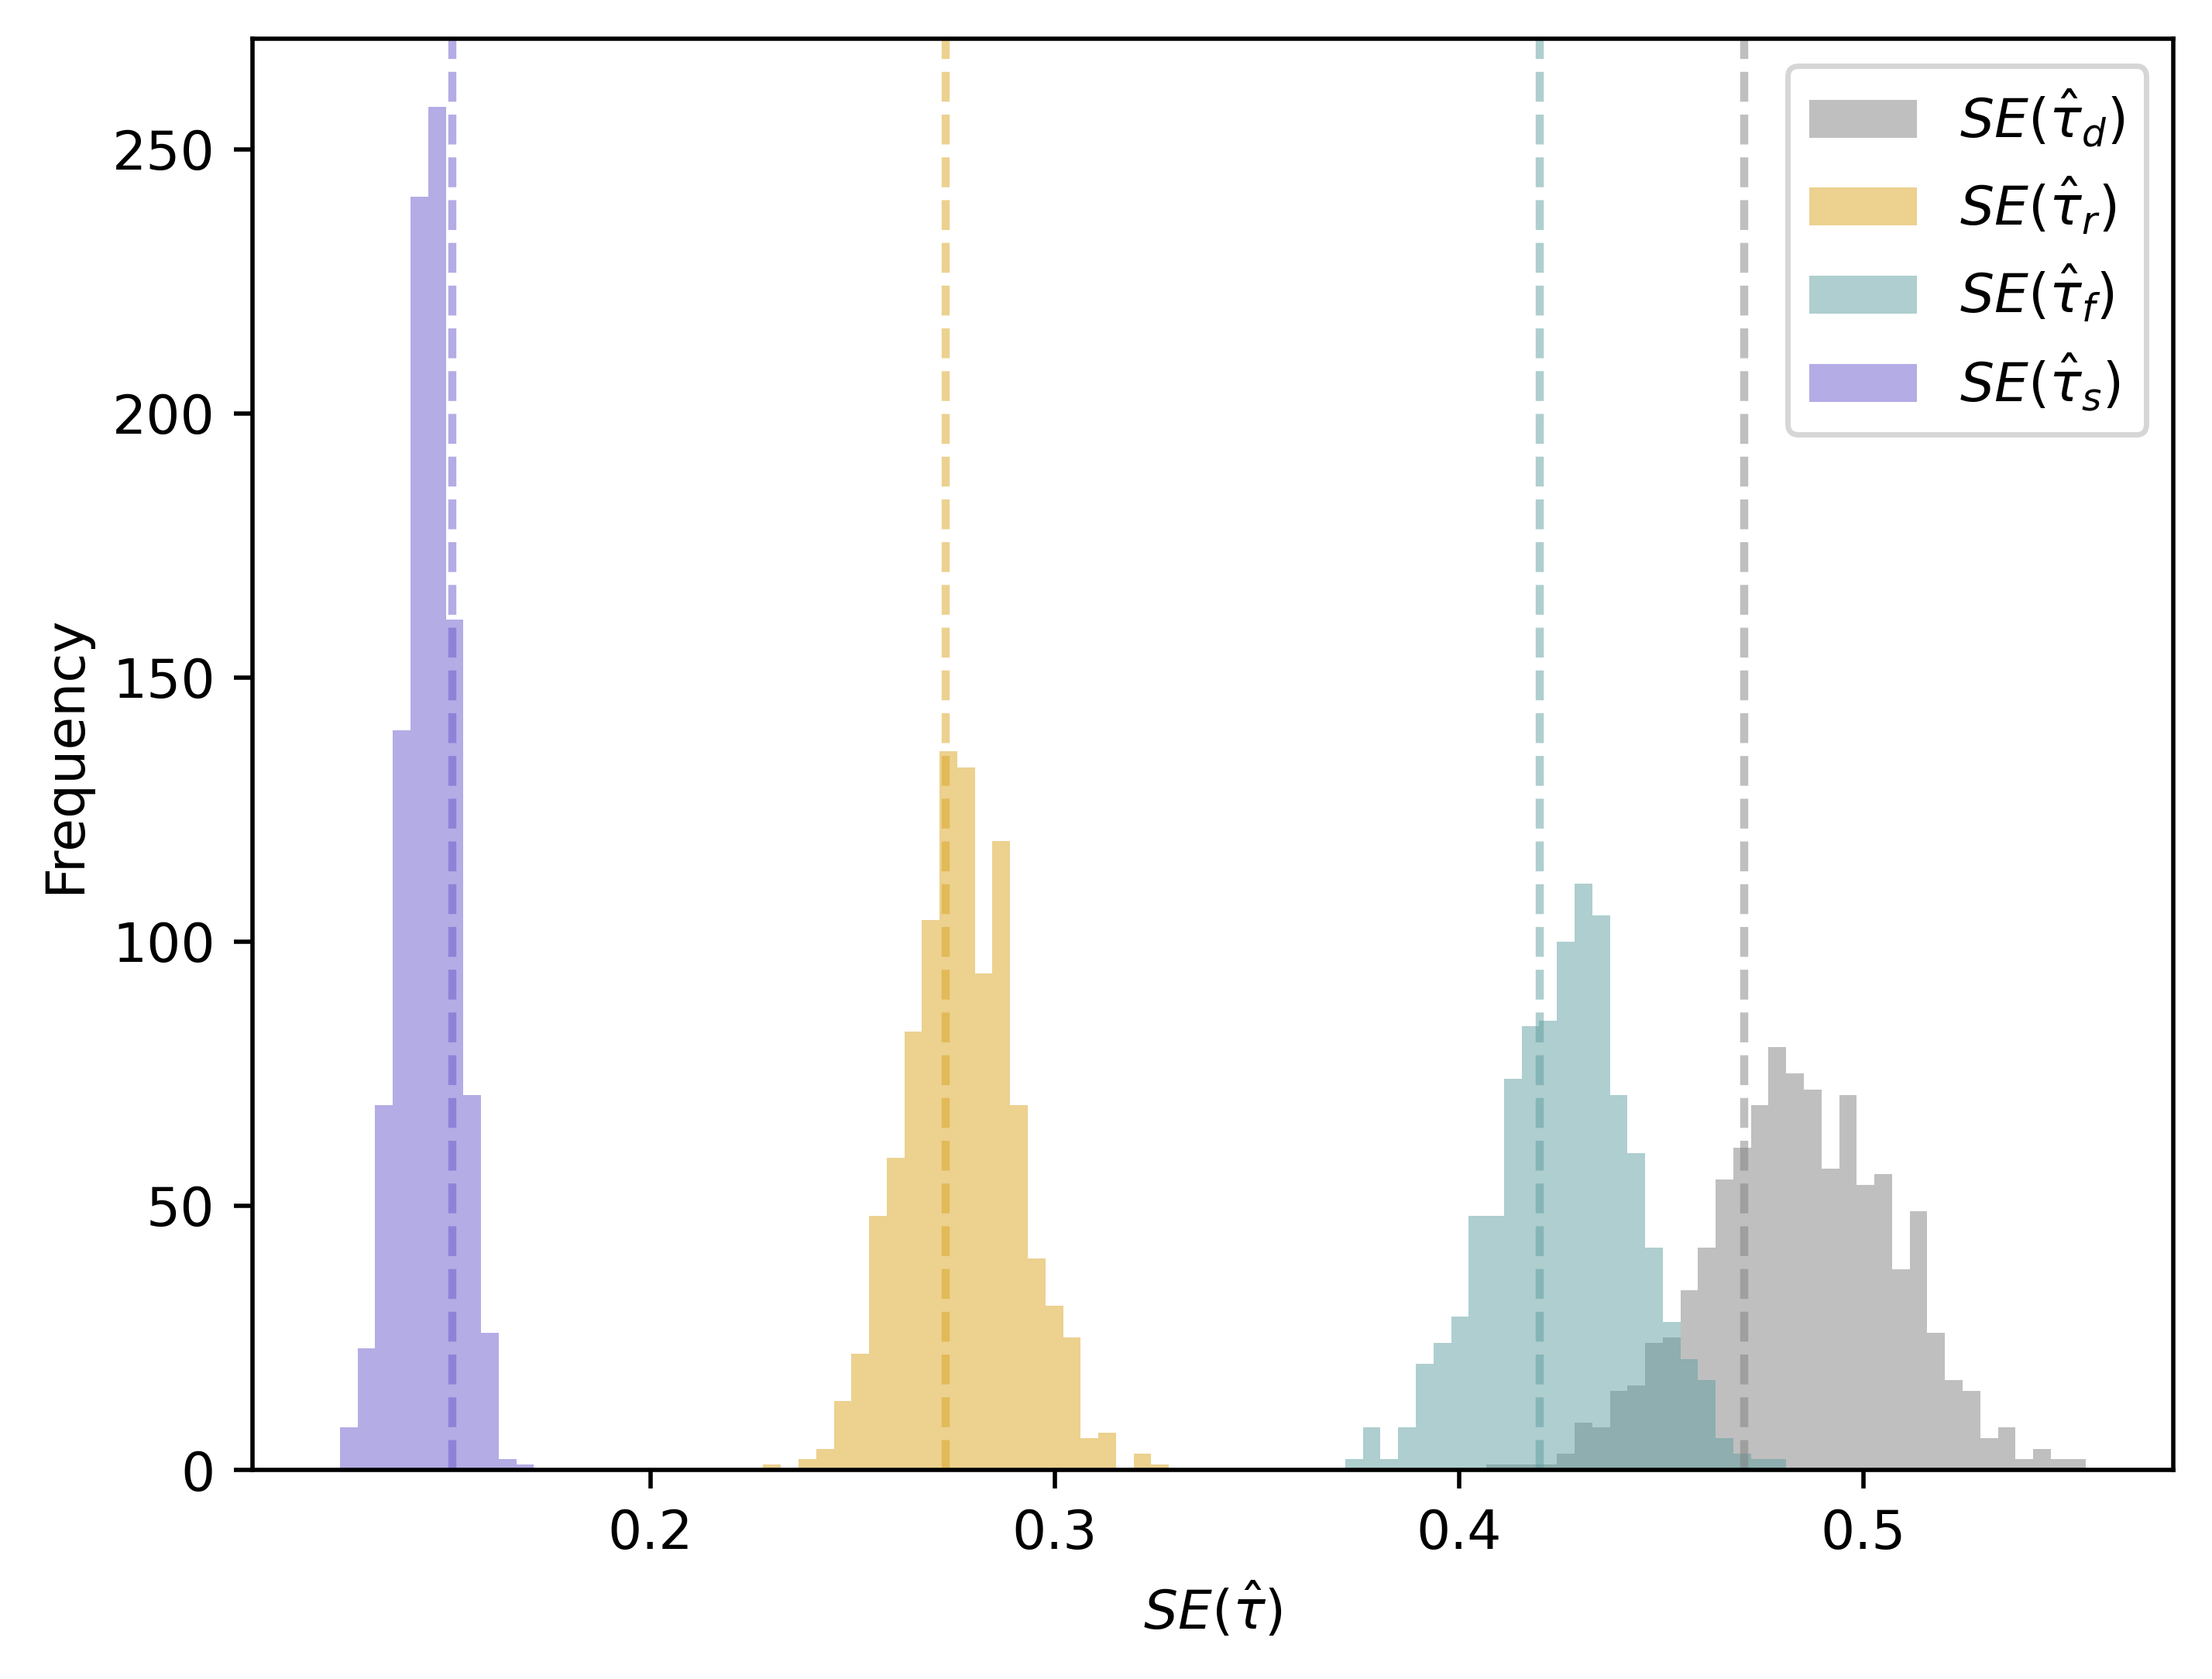

Std_d: 0.4707411297787625 Std_r: 0.27316795929107307 Std_ml:  0.4202832792711481 Std_s: 0.1511075000852246 Var_red: 0.6790008551913838


In [21]:
for key in res:
    plt.figure(dpi=dpi)
    sim_res = res[key]
    # use this to first determine overall range, and manually set max and min with visual analysis
    bins_max = max(max(sim_res['two_se']),max(sim_res['reg_se']),max(sim_res['ml_se']),max(sim_res['s_se']))
    bins_min = min(min(sim_res['two_se']),min(sim_res['reg_se']),min(sim_res['ml_se']),min(sim_res['s_se']))
    #bins_max = 2
    #bins_min = 0.25
    bins_freq = 100
    bins_range = np.arange(bins_min, bins_max, (bins_max - bins_min)/bins_freq)
    plt.hist(sim_res['two_se'], bins = bins_range, color = colors['two'], label = r"$SE(\hat{\tau}_d)$", alpha=0.5)
    plt.hist(sim_res['reg_se'], bins = bins_range, color = colors['reg'], label=r"$SE(\hat{\tau}_r)$",alpha=0.5)
    plt.hist(sim_res['ml_se'], bins = bins_range, color = colors['ml'], label=r"$SE(\hat{\tau}_{f})$",alpha=0.5)
    plt.hist(sim_res['s_se'], bins = bins_range, color = colors['mix'], label=r"$SE(\hat{\tau}_{s})$",alpha=0.5)
    plt.axvline(np.std(sim_res['two_est']), color = colors['two'], linestyle='--',alpha=0.5)
    plt.axvline(np.std(sim_res['reg_est']), color = colors['reg'], linestyle='--',alpha=0.5)
    plt.axvline(np.std(sim_res['ml_est']), color = colors['ml'], linestyle='--',alpha=0.5)
    plt.axvline(np.std(sim_res['s_est']), color = colors['mix'], linestyle='--',alpha=0.5)
    plt.ylabel("Frequency")
    plt.xlabel(r"$SE(\hat{\tau})$")
    plt.legend(loc=1)
    plt.savefig("plots/sec2_" + str(key) + "_se.png")
    plt.show()
    print("Std_d:", np.std(sim_res['two_est'],ddof=1), "Std_r:", np.std(sim_res['reg_est'],ddof=1), "Std_ml: ", np.std(sim_res['ml_est'],ddof=1),
          "Std_s:", np.std(sim_res['s_est'],ddof=1),"Var_red:", 1-np.std(sim_res['s_est'],ddof=1)/np.std(sim_res['two_est'],ddof=1))

In [ ]:
# when doing examples with the insurance data, maybe add some constant factor to
# outcomes with certain covariate (e.g. males) only in experiment data 
# to simulate differences in pre- and in- experiment data